<a href="https://colab.research.google.com/github/jademuun/car_insurance_MTPL/blob/master/Neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 --version

Python 3.7.10


In [ ]:
!pip install talos


     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 9.5MB 21.7MB/s 
     |████████████████████████████████| 5.4MB 32.5MB/s 
     |████████████████████████████████| 26.6MB 1.2MB/s 
     |████████████████████████████████| 2.6MB 64.7MB/s 
  Created wheel for wrangle: filename=wrangle-0.6.7-cp37-none-any.whl size=49894 sha256=01297d166cee30e3a7dbaad1fbad18627660e1266b6eb703ded953726b937754
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for chances: filename=chances-0.1.9-cp37-none-any.whl size=41610 sha256=3a0cc0b3f084fa716833d1c0bf9795a484e270ae275bb4a166f06762233552dc
  Stored in directory: /root/.cache/pip/wheels/75/33/46/c871b94249bd57d17797d049b3dff8e3a09c315afb67eb14c6
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-cp37-none-any.whl size=3603 sha256=2a5824a254fcd61a38cb2679fc871e04c0dcdae054ac17a9a6eacce477604a0a
  Stored in directory: /root/.cache/pip/

# Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import countplot
from matplotlib.pyplot import figure, show
import timeit

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend as K

from keras.activations import relu, tanh
from keras.optimizers import Adam, Nadam, SGD, RMSprop


import talos
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from talos.model.normalizers import lr_normalizer

# Additional preproccesing and functions

In [ ]:
claim = pd.read_csv('/content/drive/MyDrive/data/scaled.csv')
claim = claim.drop(claim.columns[[0, 1]], axis = 1)
train_idx = pd.read_csv('/content/drive/MyDrive/data/mylist.csv')

In [ ]:
train = claim.iloc[train_idx.iloc[:,0],:]
test = claim.drop(train_idx.iloc[:,0], axis = 0)

In [ ]:
# target
N_train = train.ClaimNb.values
N_test = test.ClaimNb.values

# exposure
v_train = train.Exposure.values
v_test = test.Exposure.values

# lv is offset - log(exposure)
lv_train = np.log(v_train)
lv_test = np.log(v_test)

x_train = train.drop(['ClaimNb', 'Exposure'], axis = 1).values
x_test = test.drop(['ClaimNb', 'Exposure'], axis = 1).values

In [ ]:
x_train.shape

(610212, 37)

In [103]:
# plotting the loss
def plot_loss(history, yran,  measure = 'loss',
              valmeasure = 'val_loss', val = True):
  plt.plot(history.history[measure], label=measure)
  if val:
    plt.plot(history.history[valmeasure], label=valmeasure)
  plt.ylim(yran)
  plt.xlabel('Epoch')
  plt.ylabel('Deviancia')
  plt.legend()
  plt.grid(True)

# logarithm limit in deviance

# deviance according to Wuthrix
def deviance(lambd, v, N, homogenous = False):
  log = 0
  NN = 0
  if homogenous is True:
    Mu = np.asarray(lambd * v)
  else:
    Mu = np.asarray(lambd)
  for n, mu  in zip(N, Mu):
    if n != 0:
      log += n * np.log(n / mu)
      NN += n
  result = 2 * (np.sum(Mu) - NN + log)/ N.shape[0]
  return result
  
def prediction(model):
  training = model.predict([x_train, lv_train]).flatten()
  testing = model.predict([x_test, lv_test]).flatten()
  print('Deviancia na trenovacej mnozine je: ', deviance(training, v_train, N_train))
  print('Deviancia na testovacej mnozine je: ', deviance(testing, v_test, N_test))

def poisson_deviance(y_true, y_pred):
  y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  return 2 * K.mean(y_pred - y_true + y_true * math_ops.log((y_true + K.epsilon()) /(y_pred + K.epsilon())), axis=-1)
 



# Homogenous portfolio

In [ ]:
lambda_hat_train = np.sum(N_train) / np.sum(v_train)
lambda_hat_test = np.sum(N_test) / np.sum(v_test)

In [ ]:
lambda_hat_train

0.10022331582809059

In [ ]:
lambda_hat_test

0.10412087195443295

In [ ]:
deviance(lambda_hat_train, v_train, N_train, True)

0.32935182815703434

In [ ]:
deviance(lambda_hat_test, v_test, N_test, True)

0.3385356624308628

In [86]:
N_test.mean()

0.0551466792525184

# Shallow model

## No offset

In [116]:
q0 = 37
q1 = 24
batch = 1024
epoch = 150

In [118]:
Design = tf.keras.Input(shape=(q0,), name = 'Design')
layer1  = layers.Dense(q1, activation = 'tanh' , name = 'Layer1')(Design)
Network = layers.Dense(1, activation= 'linear', name = 'Network')(layer1)
response = layers.Dense(1, activation='exponential',
                        name = 'Response', trainable=False,
                        kernel_initializer = tf.keras.initializers.Constant(1.),
                        bias_initializer = 
                        tf.keras.initializers.Constant(0.))(Network)

shallow_noofset = keras.Model(
                      inputs = Design,
                      outputs = response)

shallow_noofset.compile(loss = poisson_deviance, optimizer = 'Adam')

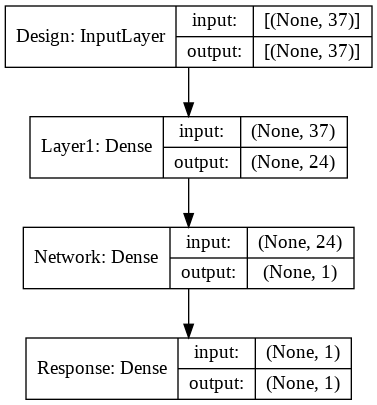

In [119]:
keras.utils.plot_model(shallow_noofset, "shallow_model.png", show_shapes=True)

## Basic


In [108]:
q0 = 37
q1 = 24
batch = 1024
epoch = 150

In [112]:
Design = tf.keras.Input(shape=(q0,), name = 'Design')
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
layer1  = layers.Dense(q1, activation = 'tanh' , name = 'Layer1')(Design)
Network = layers.Dense(1, activation= 'linear', name = 'Network')(layer1)

addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential',
                        name = 'Response', trainable=False,
                        kernel_initializer = tf.keras.initializers.Constant(1.),
                        bias_initializer = 
                        tf.keras.initializers.Constant(0.))(addition)

shallow_base = keras.Model(
                      inputs = [Design, LogVol],
                      outputs = response)

shallow_base.compile(loss = poisson_deviance, optimizer = 'Adam')

In [110]:
shallow_base.build(input_shape=(37,))
shallow_base.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 37)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 24)           912         Design[0][0]                     
__________________________________________________________________________________________________
Network (Dense)                 (None, 1)            25          Layer1[0][0]                     
__________________________________________________________________________________________________
LogVol (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________________

In [111]:
history = shallow_base.fit(
    #x = [x, lv],
    #y = y,
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose=2,
    epochs=epoch,
    batch_size = batch)


Epoch 1/150
596/596 - 1s - loss: 0.3449 - val_loss: 0.3325
Epoch 2/150
596/596 - 1s - loss: 0.3227 - val_loss: 0.3300
Epoch 3/150
596/596 - 1s - loss: 0.3208 - val_loss: 0.3291
Epoch 4/150
596/596 - 1s - loss: 0.3198 - val_loss: 0.3286
Epoch 5/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3281
Epoch 6/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3278
Epoch 7/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3279
Epoch 8/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3277
Epoch 9/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3279
Epoch 10/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3277
Epoch 11/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3280
Epoch 12/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3274
Epoch 13/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3282
Epoch 14/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3280
Epoch 15/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3275
Epoch 16/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3274
Epoch 17/150
596/596 - 1s - loss: 0.3177 - val_lo

In [113]:
prediction(shallow_base)

Deviancia na trenovacej mnozine je:  0.3141031893251166
Deviancia na testovacej mnozine je:  0.32694657699170115


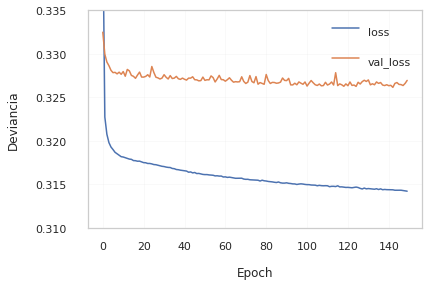

In [120]:
plot_loss(history, yran=[0.31, 0.335], val = True)

## MLE init

In [94]:
q0 = 37
g1 = 24
batch = 1024
epoch = 150

In [95]:
Design = tf.keras.Input(shape=(q0,), name = 'Design')
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
layer1  = layers.Dense(q1, activation = 'tanh' , name = 'Layer1')(Design)
Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                        kernel_initializer = tf.keras.initializers.Constant(0.),
                        bias_initializer =
                        tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer1)
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential'
, name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
bias_initializer = tf.keras.initializers.Constant(0.))(addition)
shallow = keras.Model(
                      inputs = [Design, LogVol],
                      outputs = response
  )
shallow.compile(loss = poisson_deviance, optimizer = 'Adam') 

shallow.build(input_shape=(37,))
shallow.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 37)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 24)           912         Design[0][0]                     
__________________________________________________________________________________________________
Network (Dense)                 (None, 1)            25          Layer1[0][0]                     
__________________________________________________________________________________________________
LogVol (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________________

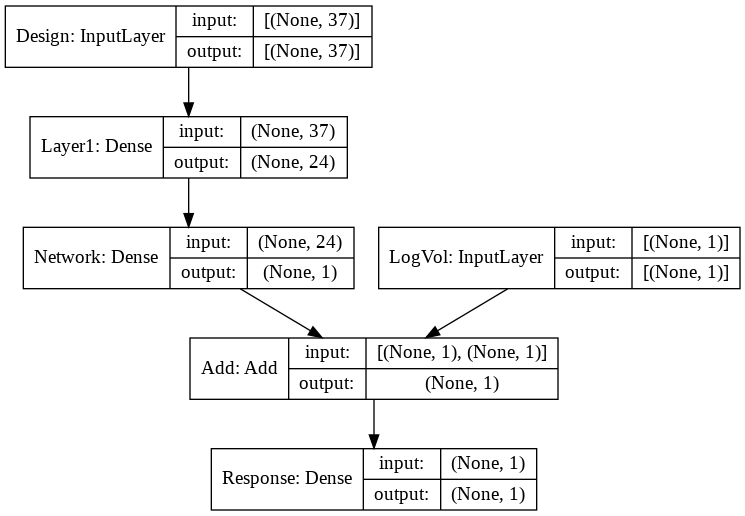

In [98]:
keras.utils.plot_model(shallow, "shallow_model.png", show_shapes=True)

In [99]:
history = shallow.fit(
    #x = [x, lv],
    #y = y,
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose=2,
    epochs=epoch,
    batch_size = batch)

Epoch 1/150
596/596 - 1s - loss: 0.3249 - val_loss: 0.3307
Epoch 2/150
596/596 - 1s - loss: 0.3202 - val_loss: 0.3281
Epoch 3/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3277
Epoch 4/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3277
Epoch 5/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3276
Epoch 6/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3279
Epoch 7/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3281
Epoch 8/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3280
Epoch 9/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3284
Epoch 11/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3275
Epoch 13/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 14/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 15/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 16/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 17/150
596/596 - 1s - loss: 0.3177 - val_lo

NameError: ignored

In [100]:
shallow.save('/content/drive/MyDrive/models/shallow_2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/shallow_2/assets


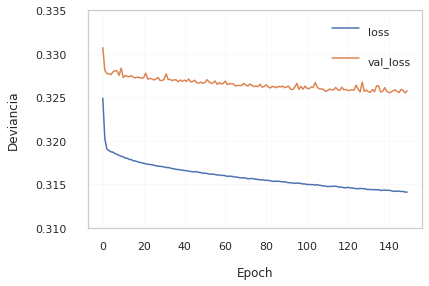

In [104]:
plot_loss(history, yran=[0.31, 0.335], val = True)

In [105]:
prediction(shallow)

Deviancia na trenovacej mnozine je:  0.3138057934738944
Deviancia na testovacej mnozine je:  0.3257563137677383


# Optimizer optimalization -  Shallow Net



In [ ]:
# hyperparametres
#batch  1024
epoch = 150
p = {'optimizer': [SGD, RMSprop, Nadam, Adam],
      'first_neuron': [16, 24, 32],
      'activation': ['relu', 'tanh'],
      'batch_size': [512, 1024, 2048],
      'lr': [0.002, 0.004, 0.01]
}


In [ ]:
def shallow_optim(x_train, N_train, x_test, N_test, params):
  Design = tf.keras.Input(shape=(37,), name = 'Design')
  LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
  layer1  = layers.Dense(params['first_neuron'], activation = params['activation'] , name = 'Layer1')(Design)
  Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                          kernel_initializer = tf.keras.initializers.Constant(0.),
                          bias_initializer =
                          tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer1)
  addition = layers.add([Network, LogVol], name = 'Add')
  response = layers.Dense(1, activation='exponential'
  , name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
  bias_initializer = tf.keras.initializers.Constant(0.))(addition)
  shallow = keras.Model(
      inputs = [Design, LogVol],
      outputs = response
  )
  shallow.compile(loss = poisson_deviance, optimizer = params['optimizer'](lr = params['lr'])) 

  #shallow.build(input_shape=(37,))
  #shallow.summary()
  history = shallow.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose = 2,
    epochs = epoch,
    batch_size = params['batch_size'])
  return history, shallow

In [ ]:
x_train.shape

(610212, 37)

In [ ]:
scan_shallow = talos.Scan(x=x_train, y=N_train, x_val= x_test, y_val=N_test , params=p, model=shallow_optim, experiment_name='shallow_optimalization_4', save_weights=True)

  0%|          | 0/216 [00:00<?, ?it/s]

Epoch 1/150
1192/1192 - 4s - loss: 0.3292 - val_loss: 0.3384
Epoch 2/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3382
Epoch 3/150
1192/1192 - 2s - loss: 0.3289 - val_loss: 0.3380
Epoch 4/150
1192/1192 - 2s - loss: 0.3287 - val_loss: 0.3379
Epoch 5/150
1192/1192 - 2s - loss: 0.3285 - val_loss: 0.3377
Epoch 6/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3375
Epoch 7/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3374
Epoch 8/150
1192/1192 - 2s - loss: 0.3281 - val_loss: 0.3372
Epoch 9/150
1192/1192 - 2s - loss: 0.3279 - val_loss: 0.3370
Epoch 10/150
1192/1192 - 2s - loss: 0.3278 - val_loss: 0.3369
Epoch 11/150
1192/1192 - 2s - loss: 0.3277 - val_loss: 0.3368
Epoch 12/150
1192/1192 - 2s - loss: 0.3275 - val_loss: 0.3366
Epoch 13/150
1192/1192 - 2s - loss: 0.3274 - val_loss: 0.3365
Epoch 14/150
1192/1192 - 2s - loss: 0.3273 - val_loss: 0.3364
Epoch 15/150
1192/1192 - 2s - loss: 0.3272 - val_loss: 0.3362
Epoch 16/150
1192/1192 - 2s - loss: 0.3271 - val_loss: 0.3361
Epoch 17/150
1192

  0%|          | 1/216 [04:11<15:02:25, 251.84s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3241 - val_loss: 0.3292
Epoch 2/150
1192/1192 - 2s - loss: 0.3195 - val_loss: 0.3275
Epoch 3/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3276
Epoch 4/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3274
Epoch 5/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3276
Epoch 6/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3274
Epoch 7/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3274
Epoch 8/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3281
Epoch 9/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3273
Epoch 10/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3275
Epoch 11/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3290
Epoch 12/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3272
Epoch 13/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3276
Epoch 14/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3272
Epoch 15/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3270
Epoch 16/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3271
Epoch 17/150
1192

  1%|          | 2/216 [08:45<15:21:16, 258.30s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3224 - val_loss: 0.3286
Epoch 2/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3278
Epoch 3/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3274
Epoch 4/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3273
Epoch 5/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3274
Epoch 6/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3270
Epoch 7/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3272
Epoch 8/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3271
Epoch 9/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3275
Epoch 10/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3268
Epoch 11/150
1192/1192 - 2s - loss: 0.3165 - val_loss: 0.3266
Epoch 12/150
1192/1192 - 2s - loss: 0.3163 - val_loss: 0.3271
Epoch 13/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3270
Epoch 14/150
1192/1192 - 2s - loss: 0.3161 - val_loss: 0.3263
Epoch 15/150
1192/1192 - 2s - loss: 0.3159 - val_loss: 0.3268
Epoch 16/150
1192/1192 - 2s - loss: 0.3158 - val_loss: 0.3268
Epoch 17/150
1192

  1%|▏         | 3/216 [14:13<16:31:24, 279.27s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3226 - val_loss: 0.3282
Epoch 2/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3274
Epoch 3/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3274
Epoch 4/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3269
Epoch 5/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3276
Epoch 6/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3267
Epoch 7/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3267
Epoch 8/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3267
Epoch 9/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3265
Epoch 10/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3267
Epoch 11/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3265
Epoch 12/150
1192/1192 - 2s - loss: 0.3161 - val_loss: 0.3267
Epoch 13/150
1192/1192 - 2s - loss: 0.3161 - val_loss: 0.3269
Epoch 14/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3265
Epoch 15/150
1192/1192 - 2s - loss: 0.3159 - val_loss: 0.3266
Epoch 16/150
1192/1192 - 2s - loss: 0.3158 - val_loss: 0.3264
Epoch 17/150
1192

  2%|▏         | 4/216 [18:28<16:00:56, 271.97s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3292 - val_loss: 0.3384
Epoch 2/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3382
Epoch 3/150
1192/1192 - 2s - loss: 0.3288 - val_loss: 0.3380
Epoch 4/150
1192/1192 - 2s - loss: 0.3287 - val_loss: 0.3378
Epoch 5/150
1192/1192 - 2s - loss: 0.3285 - val_loss: 0.3377
Epoch 6/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3375
Epoch 7/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3374
Epoch 8/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3373
Epoch 9/150
1192/1192 - 2s - loss: 0.3281 - val_loss: 0.3372
Epoch 10/150
1192/1192 - 2s - loss: 0.3280 - val_loss: 0.3371
Epoch 11/150
1192/1192 - 2s - loss: 0.3279 - val_loss: 0.3370
Epoch 12/150
1192/1192 - 2s - loss: 0.3279 - val_loss: 0.3369
Epoch 13/150
1192/1192 - 2s - loss: 0.3278 - val_loss: 0.3368
Epoch 14/150
1192/1192 - 2s - loss: 0.3277 - val_loss: 0.3368
Epoch 15/150
1192/1192 - 2s - loss: 0.3277 - val_loss: 0.3367
Epoch 16/150
1192/1192 - 2s - loss: 0.3276 - val_loss: 0.3366
Epoch 17/150
1192

  2%|▏         | 5/216 [22:35<15:30:35, 264.62s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3225 - val_loss: 0.3286
Epoch 2/150
1192/1192 - 2s - loss: 0.3193 - val_loss: 0.3297
Epoch 3/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3281
Epoch 4/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3277
Epoch 5/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3276
Epoch 6/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3277
Epoch 7/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3275
Epoch 8/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3274
Epoch 9/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3272
Epoch 10/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3274
Epoch 11/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3270
Epoch 12/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3272
Epoch 13/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3275
Epoch 14/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3272
Epoch 15/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3274
Epoch 16/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3271
Epoch 17/150
1192

  3%|▎         | 6/216 [27:08<15:35:03, 267.16s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3209 - val_loss: 0.3275
Epoch 2/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3281
Epoch 3/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3269
Epoch 4/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3274
Epoch 5/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3273
Epoch 6/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3281
Epoch 7/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3276
Epoch 8/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3276
Epoch 9/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3278
Epoch 10/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3274
Epoch 11/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3269
Epoch 12/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3269
Epoch 13/150
1192/1192 - 2s - loss: 0.3158 - val_loss: 0.3270
Epoch 14/150
1192/1192 - 2s - loss: 0.3156 - val_loss: 0.3265
Epoch 15/150
1192/1192 - 2s - loss: 0.3155 - val_loss: 0.3260
Epoch 16/150
1192/1192 - 2s - loss: 0.3153 - val_loss: 0.3274
Epoch 17/150
1192

  3%|▎         | 7/216 [32:37<16:34:51, 285.61s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3211 - val_loss: 0.3279
Epoch 2/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3279
Epoch 3/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3271
Epoch 4/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3271
Epoch 5/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3270
Epoch 6/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3272
Epoch 7/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3267
Epoch 8/150
1192/1192 - 2s - loss: 0.3165 - val_loss: 0.3274
Epoch 9/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3265
Epoch 10/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3265
Epoch 11/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3263
Epoch 12/150
1192/1192 - 2s - loss: 0.3156 - val_loss: 0.3269
Epoch 13/150
1192/1192 - 2s - loss: 0.3155 - val_loss: 0.3257
Epoch 14/150
1192/1192 - 2s - loss: 0.3152 - val_loss: 0.3257
Epoch 15/150
1192/1192 - 2s - loss: 0.3152 - val_loss: 0.3259
Epoch 16/150
1192/1192 - 2s - loss: 0.3148 - val_loss: 0.3253
Epoch 17/150
1192

  4%|▎         | 8/216 [36:49<15:55:13, 275.55s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3291 - val_loss: 0.3379
Epoch 2/150
1192/1192 - 2s - loss: 0.3286 - val_loss: 0.3375
Epoch 3/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3371
Epoch 4/150
1192/1192 - 2s - loss: 0.3280 - val_loss: 0.3368
Epoch 5/150
1192/1192 - 2s - loss: 0.3277 - val_loss: 0.3364
Epoch 6/150
1192/1192 - 2s - loss: 0.3274 - val_loss: 0.3361
Epoch 7/150
1192/1192 - 2s - loss: 0.3272 - val_loss: 0.3358
Epoch 8/150
1192/1192 - 2s - loss: 0.3270 - val_loss: 0.3356
Epoch 9/150
1192/1192 - 2s - loss: 0.3268 - val_loss: 0.3354
Epoch 10/150
1192/1192 - 2s - loss: 0.3266 - val_loss: 0.3351
Epoch 11/150
1192/1192 - 2s - loss: 0.3264 - val_loss: 0.3350
Epoch 12/150
1192/1192 - 2s - loss: 0.3262 - val_loss: 0.3348
Epoch 13/150
1192/1192 - 2s - loss: 0.3260 - val_loss: 0.3346
Epoch 14/150
1192/1192 - 2s - loss: 0.3258 - val_loss: 0.3344
Epoch 15/150
1192/1192 - 2s - loss: 0.3256 - val_loss: 0.3341
Epoch 16/150
1192/1192 - 2s - loss: 0.3254 - val_loss: 0.3340
Epoch 17/150
1192

  4%|▍         | 9/216 [40:52<15:16:35, 265.68s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3218 - val_loss: 0.3287
Epoch 2/150
1192/1192 - 2s - loss: 0.3196 - val_loss: 0.3280
Epoch 3/150
1192/1192 - 2s - loss: 0.3193 - val_loss: 0.3286
Epoch 4/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3277
Epoch 5/150
1192/1192 - 2s - loss: 0.3190 - val_loss: 0.3278
Epoch 6/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3285
Epoch 7/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3283
Epoch 8/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3283
Epoch 9/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3285
Epoch 10/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3278
Epoch 11/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3284
Epoch 12/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3279
Epoch 13/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3285
Epoch 14/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3281
Epoch 15/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3291
Epoch 16/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3283
Epoch 17/150
1192

  5%|▍         | 10/216 [45:22<15:16:45, 267.02s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3207 - val_loss: 0.3292
Epoch 2/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3280
Epoch 3/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3284
Epoch 4/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3279
Epoch 5/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3280
Epoch 6/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3273
Epoch 7/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3269
Epoch 8/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3263
Epoch 9/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3271
Epoch 10/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3268
Epoch 11/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3270
Epoch 12/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3267
Epoch 13/150
1192/1192 - 2s - loss: 0.3161 - val_loss: 0.3269
Epoch 14/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3275
Epoch 15/150
1192/1192 - 2s - loss: 0.3157 - val_loss: 0.3273
Epoch 16/150
1192/1192 - 2s - loss: 0.3157 - val_loss: 0.3266
Epoch 17/150
1192

  5%|▌         | 11/216 [50:50<16:14:38, 285.26s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3208 - val_loss: 0.3279
Epoch 2/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3274
Epoch 3/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3283
Epoch 4/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3277
Epoch 5/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3281
Epoch 6/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3269
Epoch 7/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3267
Epoch 8/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3269
Epoch 9/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3269
Epoch 10/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3272
Epoch 11/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3269
Epoch 12/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3268
Epoch 13/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3269
Epoch 14/150
1192/1192 - 2s - loss: 0.3165 - val_loss: 0.3275
Epoch 15/150
1192/1192 - 2s - loss: 0.3165 - val_loss: 0.3278
Epoch 16/150
1192/1192 - 2s - loss: 0.3165 - val_loss: 0.3271
Epoch 17/150
1192

  6%|▌         | 12/216 [55:01<15:35:16, 275.08s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
1192/1192 - 2s - loss: 0.3292 - val_loss: 0.3384
Epoch 3/150
1192/1192 - 2s - loss: 0.3291 - val_loss: 0.3383
Epoch 4/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3382
Epoch 5/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3381
Epoch 6/150
1192/1192 - 2s - loss: 0.3289 - val_loss: 0.3381
Epoch 7/150
1192/1192 - 2s - loss: 0.3288 - val_loss: 0.3380
Epoch 8/150
1192/1192 - 2s - loss: 0.3288 - val_loss: 0.3379
Epoch 9/150
1192/1192 - 2s - loss: 0.3287 - val_loss: 0.3378
Epoch 10/150
1192/1192 - 2s - loss: 0.3286 - val_loss: 0.3377
Epoch 11/150
1192/1192 - 2s - loss: 0.3286 - val_loss: 0.3377
Epoch 12/150
1192/1192 - 2s - loss: 0.3285 - val_loss: 0.3376
Epoch 13/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3375
Epoch 14/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3374
Epoch 15/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3374
Epoch 16/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3373
Epoch 17/150
1192

  6%|▌         | 13/216 [59:03<14:56:38, 265.02s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3238 - val_loss: 0.3291
Epoch 2/150
1192/1192 - 2s - loss: 0.3195 - val_loss: 0.3282
Epoch 3/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3277
Epoch 4/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3280
Epoch 5/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3278
Epoch 6/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3276
Epoch 7/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3273
Epoch 8/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3275
Epoch 9/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3275
Epoch 10/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3273
Epoch 11/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3271
Epoch 12/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3273
Epoch 13/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3274
Epoch 14/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3277
Epoch 15/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3272
Epoch 16/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3273
Epoch 17/150
1192

  6%|▋         | 14/216 [1:03:33<14:58:06, 266.77s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3219 - val_loss: 0.3286
Epoch 2/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3282
Epoch 3/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3273
Epoch 4/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3275
Epoch 5/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3268
Epoch 6/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3272
Epoch 7/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3269
Epoch 8/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3267
Epoch 9/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3265
Epoch 10/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3266
Epoch 11/150
1192/1192 - 2s - loss: 0.3163 - val_loss: 0.3266
Epoch 12/150
1192/1192 - 2s - loss: 0.3161 - val_loss: 0.3264
Epoch 13/150
1192/1192 - 2s - loss: 0.3159 - val_loss: 0.3268
Epoch 14/150
1192/1192 - 2s - loss: 0.3158 - val_loss: 0.3261
Epoch 15/150
1192/1192 - 2s - loss: 0.3156 - val_loss: 0.3258
Epoch 16/150
1192/1192 - 2s - loss: 0.3154 - val_loss: 0.3256
Epoch 17/150
1192

  7%|▋         | 15/216 [1:09:02<15:55:20, 285.18s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3214 - val_loss: 0.3283
Epoch 2/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3270
Epoch 3/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3270
Epoch 4/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3270
Epoch 5/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3266
Epoch 6/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3273
Epoch 7/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3276
Epoch 8/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3267
Epoch 9/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3266
Epoch 10/150
1192/1192 - 2s - loss: 0.3165 - val_loss: 0.3266
Epoch 11/150
1192/1192 - 2s - loss: 0.3163 - val_loss: 0.3265
Epoch 12/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3268
Epoch 13/150
1192/1192 - 2s - loss: 0.3161 - val_loss: 0.3266
Epoch 14/150
1192/1192 - 2s - loss: 0.3159 - val_loss: 0.3264
Epoch 15/150
1192/1192 - 2s - loss: 0.3159 - val_loss: 0.3266
Epoch 16/150
1192/1192 - 2s - loss: 0.3157 - val_loss: 0.3263
Epoch 17/150
1192

  7%|▋         | 16/216 [1:13:13<15:17:02, 275.11s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
1192/1192 - 2s - loss: 0.3292 - val_loss: 0.3383
Epoch 3/150
1192/1192 - 2s - loss: 0.3291 - val_loss: 0.3382
Epoch 4/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3381
Epoch 5/150
1192/1192 - 2s - loss: 0.3289 - val_loss: 0.3380
Epoch 6/150
1192/1192 - 2s - loss: 0.3288 - val_loss: 0.3379
Epoch 7/150
1192/1192 - 2s - loss: 0.3287 - val_loss: 0.3378
Epoch 8/150
1192/1192 - 2s - loss: 0.3287 - val_loss: 0.3377
Epoch 9/150
1192/1192 - 2s - loss: 0.3286 - val_loss: 0.3377
Epoch 10/150
1192/1192 - 2s - loss: 0.3285 - val_loss: 0.3376
Epoch 11/150
1192/1192 - 2s - loss: 0.3285 - val_loss: 0.3375
Epoch 12/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3374
Epoch 13/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3374
Epoch 14/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3373
Epoch 15/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3372
Epoch 16/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3372
Epoch 17/150
1192

  8%|▊         | 17/216 [1:17:15<14:39:11, 265.09s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3217 - val_loss: 0.3282
Epoch 2/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3290
Epoch 3/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3277
Epoch 4/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3278
Epoch 5/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3274
Epoch 6/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3286
Epoch 7/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3278
Epoch 8/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3287
Epoch 9/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3272
Epoch 10/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3273
Epoch 11/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3281
Epoch 12/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3271
Epoch 13/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3273
Epoch 14/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3275
Epoch 15/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3272
Epoch 16/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3278
Epoch 17/150
1192

  8%|▊         | 18/216 [1:21:46<14:40:34, 266.84s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3208 - val_loss: 0.3279
Epoch 2/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3279
Epoch 3/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3273
Epoch 4/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3269
Epoch 5/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3273
Epoch 6/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3269
Epoch 7/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3272
Epoch 8/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3278
Epoch 9/150
1192/1192 - 2s - loss: 0.3163 - val_loss: 0.3264
Epoch 10/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3270
Epoch 11/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3265
Epoch 12/150
1192/1192 - 2s - loss: 0.3158 - val_loss: 0.3268
Epoch 13/150
1192/1192 - 2s - loss: 0.3158 - val_loss: 0.3264
Epoch 14/150
1192/1192 - 2s - loss: 0.3155 - val_loss: 0.3268
Epoch 15/150
1192/1192 - 2s - loss: 0.3154 - val_loss: 0.3263
Epoch 16/150
1192/1192 - 2s - loss: 0.3153 - val_loss: 0.3273
Epoch 17/150
1192

  9%|▉         | 19/216 [1:27:13<15:35:27, 284.91s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3212 - val_loss: 0.3271
Epoch 2/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3290
Epoch 3/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3275
Epoch 4/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3270
Epoch 5/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3268
Epoch 6/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3274
Epoch 7/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3276
Epoch 8/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3264
Epoch 9/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3272
Epoch 10/150
1192/1192 - 2s - loss: 0.3156 - val_loss: 0.3276
Epoch 11/150
1192/1192 - 2s - loss: 0.3154 - val_loss: 0.3260
Epoch 12/150
1192/1192 - 2s - loss: 0.3151 - val_loss: 0.3259
Epoch 13/150
1192/1192 - 2s - loss: 0.3149 - val_loss: 0.3268
Epoch 14/150
1192/1192 - 2s - loss: 0.3147 - val_loss: 0.3256
Epoch 15/150
1192/1192 - 2s - loss: 0.3145 - val_loss: 0.3256
Epoch 16/150
1192/1192 - 2s - loss: 0.3144 - val_loss: 0.3252
Epoch 17/150
1192

  9%|▉         | 20/216 [1:31:25<14:58:10, 274.95s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3379
Epoch 2/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3373
Epoch 3/150
1192/1192 - 2s - loss: 0.3279 - val_loss: 0.3368
Epoch 4/150
1192/1192 - 2s - loss: 0.3275 - val_loss: 0.3364
Epoch 5/150
1192/1192 - 2s - loss: 0.3272 - val_loss: 0.3360
Epoch 6/150
1192/1192 - 2s - loss: 0.3269 - val_loss: 0.3357
Epoch 7/150
1192/1192 - 2s - loss: 0.3266 - val_loss: 0.3354
Epoch 8/150
1192/1192 - 2s - loss: 0.3264 - val_loss: 0.3351
Epoch 9/150
1192/1192 - 2s - loss: 0.3262 - val_loss: 0.3348
Epoch 10/150
1192/1192 - 2s - loss: 0.3259 - val_loss: 0.3345
Epoch 11/150
1192/1192 - 2s - loss: 0.3257 - val_loss: 0.3343
Epoch 12/150
1192/1192 - 2s - loss: 0.3255 - val_loss: 0.3340
Epoch 13/150
1192/1192 - 2s - loss: 0.3253 - val_loss: 0.3338
Epoch 14/150
1192/1192 - 2s - loss: 0.3251 - val_loss: 0.3336
Epoch 15/150
1192/1192 - 2s - loss: 0.3249 - val_loss: 0.3334
Epoch 16/150
1192/1192 - 2s - loss: 0.3247 - val_loss: 0.3331
Epoch 17/150
1192

 10%|▉         | 21/216 [1:35:26<14:21:06, 264.96s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3217 - val_loss: 0.3310
Epoch 2/150
1192/1192 - 2s - loss: 0.3195 - val_loss: 0.3290
Epoch 3/150
1192/1192 - 2s - loss: 0.3193 - val_loss: 0.3278
Epoch 4/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3279
Epoch 5/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3282
Epoch 6/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3280
Epoch 7/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3281
Epoch 8/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3275
Epoch 9/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3275
Epoch 10/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3292
Epoch 11/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3276
Epoch 12/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3280
Epoch 13/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3281
Epoch 14/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3284
Epoch 15/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3295
Epoch 16/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3282
Epoch 17/150
1192

 10%|█         | 22/216 [1:39:58<14:23:05, 266.93s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3208 - val_loss: 0.3283
Epoch 2/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3282
Epoch 3/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3278
Epoch 4/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3288
Epoch 5/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3273
Epoch 6/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3268
Epoch 7/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3283
Epoch 8/150
1192/1192 - 2s - loss: 0.3165 - val_loss: 0.3264
Epoch 9/150
1192/1192 - 2s - loss: 0.3163 - val_loss: 0.3265
Epoch 10/150
1192/1192 - 2s - loss: 0.3159 - val_loss: 0.3272
Epoch 11/150
1192/1192 - 2s - loss: 0.3157 - val_loss: 0.3263
Epoch 12/150
1192/1192 - 2s - loss: 0.3153 - val_loss: 0.3272
Epoch 13/150
1192/1192 - 2s - loss: 0.3149 - val_loss: 0.3252
Epoch 14/150
1192/1192 - 2s - loss: 0.3144 - val_loss: 0.3245
Epoch 15/150
1192/1192 - 2s - loss: 0.3139 - val_loss: 0.3243
Epoch 16/150
1192/1192 - 2s - loss: 0.3136 - val_loss: 0.3238
Epoch 17/150
1192

 11%|█         | 23/216 [1:45:27<15:18:13, 285.46s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3206 - val_loss: 0.3292
Epoch 2/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3278
Epoch 3/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3281
Epoch 4/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3274
Epoch 5/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3276
Epoch 6/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3272
Epoch 7/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3274
Epoch 8/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3274
Epoch 9/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3269
Epoch 10/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3264
Epoch 11/150
1192/1192 - 2s - loss: 0.3163 - val_loss: 0.3276
Epoch 12/150
1192/1192 - 2s - loss: 0.3161 - val_loss: 0.3270
Epoch 13/150
1192/1192 - 2s - loss: 0.3157 - val_loss: 0.3261
Epoch 14/150
1192/1192 - 2s - loss: 0.3154 - val_loss: 0.3253
Epoch 15/150
1192/1192 - 2s - loss: 0.3148 - val_loss: 0.3271
Epoch 16/150
1192/1192 - 2s - loss: 0.3148 - val_loss: 0.3286
Epoch 17/150
1192

 11%|█         | 24/216 [1:49:37<14:40:11, 275.06s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
1192/1192 - 2s - loss: 0.3292 - val_loss: 0.3384
Epoch 3/150
1192/1192 - 2s - loss: 0.3291 - val_loss: 0.3383
Epoch 4/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3383
Epoch 5/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3382
Epoch 6/150
1192/1192 - 2s - loss: 0.3289 - val_loss: 0.3381
Epoch 7/150
1192/1192 - 2s - loss: 0.3288 - val_loss: 0.3380
Epoch 8/150
1192/1192 - 2s - loss: 0.3287 - val_loss: 0.3379
Epoch 9/150
1192/1192 - 2s - loss: 0.3286 - val_loss: 0.3378
Epoch 10/150
1192/1192 - 2s - loss: 0.3286 - val_loss: 0.3378
Epoch 11/150
1192/1192 - 2s - loss: 0.3285 - val_loss: 0.3377
Epoch 12/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3376
Epoch 13/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3375
Epoch 14/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3374
Epoch 15/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3373
Epoch 16/150
1192/1192 - 2s - loss: 0.3281 - val_loss: 0.3372
Epoch 17/150
1192

 12%|█▏        | 25/216 [1:53:39<14:03:53, 265.10s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3229 - val_loss: 0.3294
Epoch 2/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3275
Epoch 3/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3280
Epoch 4/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3289
Epoch 5/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3276
Epoch 6/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3276
Epoch 7/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3278
Epoch 8/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3274
Epoch 9/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3283
Epoch 10/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3275
Epoch 11/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3272
Epoch 12/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3271
Epoch 13/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3270
Epoch 14/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3274
Epoch 15/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3268
Epoch 16/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3269
Epoch 17/150
1192

 12%|█▏        | 26/216 [1:58:11<14:05:59, 267.15s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3219 - val_loss: 0.3280
Epoch 2/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3271
Epoch 3/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3268
Epoch 4/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3271
Epoch 5/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3270
Epoch 6/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3270
Epoch 7/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3270
Epoch 8/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3268
Epoch 9/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3264
Epoch 10/150
1192/1192 - 2s - loss: 0.3158 - val_loss: 0.3268
Epoch 11/150
1192/1192 - 2s - loss: 0.3156 - val_loss: 0.3266
Epoch 12/150
1192/1192 - 2s - loss: 0.3155 - val_loss: 0.3264
Epoch 13/150
1192/1192 - 2s - loss: 0.3153 - val_loss: 0.3266
Epoch 14/150
1192/1192 - 2s - loss: 0.3151 - val_loss: 0.3262
Epoch 15/150
1192/1192 - 2s - loss: 0.3149 - val_loss: 0.3257
Epoch 16/150
1192/1192 - 2s - loss: 0.3148 - val_loss: 0.3257
Epoch 17/150
1192

 12%|█▎        | 27/216 [2:03:39<14:58:58, 285.39s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3219 - val_loss: 0.3280
Epoch 2/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3275
Epoch 3/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3272
Epoch 4/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3271
Epoch 5/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3269
Epoch 6/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3280
Epoch 7/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3278
Epoch 8/150
1192/1192 - 2s - loss: 0.3163 - val_loss: 0.3267
Epoch 9/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3270
Epoch 10/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3266
Epoch 11/150
1192/1192 - 2s - loss: 0.3158 - val_loss: 0.3270
Epoch 12/150
1192/1192 - 2s - loss: 0.3157 - val_loss: 0.3264
Epoch 13/150
1192/1192 - 2s - loss: 0.3155 - val_loss: 0.3269
Epoch 14/150
1192/1192 - 2s - loss: 0.3152 - val_loss: 0.3265
Epoch 15/150
1192/1192 - 2s - loss: 0.3152 - val_loss: 0.3267
Epoch 16/150
1192/1192 - 2s - loss: 0.3152 - val_loss: 0.3264
Epoch 17/150
1192

 13%|█▎        | 28/216 [2:07:51<14:22:30, 275.27s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3292 - val_loss: 0.3383
Epoch 2/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3381
Epoch 3/150
1192/1192 - 2s - loss: 0.3287 - val_loss: 0.3379
Epoch 4/150
1192/1192 - 2s - loss: 0.3285 - val_loss: 0.3376
Epoch 5/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3374
Epoch 6/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3373
Epoch 7/150
1192/1192 - 2s - loss: 0.3280 - val_loss: 0.3371
Epoch 8/150
1192/1192 - 2s - loss: 0.3278 - val_loss: 0.3369
Epoch 9/150
1192/1192 - 2s - loss: 0.3276 - val_loss: 0.3367
Epoch 10/150
1192/1192 - 2s - loss: 0.3275 - val_loss: 0.3366
Epoch 11/150
1192/1192 - 2s - loss: 0.3273 - val_loss: 0.3364
Epoch 12/150
1192/1192 - 2s - loss: 0.3272 - val_loss: 0.3363
Epoch 13/150
1192/1192 - 2s - loss: 0.3271 - val_loss: 0.3361
Epoch 14/150
1192/1192 - 2s - loss: 0.3269 - val_loss: 0.3360
Epoch 15/150
1192/1192 - 2s - loss: 0.3268 - val_loss: 0.3359
Epoch 16/150
1192/1192 - 2s - loss: 0.3267 - val_loss: 0.3357
Epoch 17/150
1192

 13%|█▎        | 29/216 [2:11:54<13:48:07, 265.71s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3216 - val_loss: 0.3282
Epoch 2/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3278
Epoch 3/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3296
Epoch 4/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3275
Epoch 5/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3276
Epoch 6/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3277
Epoch 7/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3277
Epoch 8/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3274
Epoch 9/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3274
Epoch 10/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3272
Epoch 11/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3273
Epoch 12/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3268
Epoch 13/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3278
Epoch 14/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3270
Epoch 15/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3275
Epoch 16/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3276
Epoch 17/150
1192

 14%|█▍        | 30/216 [2:16:26<13:49:33, 267.60s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3207 - val_loss: 0.3276
Epoch 2/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3280
Epoch 3/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3276
Epoch 4/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3272
Epoch 5/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3269
Epoch 6/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3275
Epoch 7/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3266
Epoch 8/150
1192/1192 - 2s - loss: 0.3163 - val_loss: 0.3269
Epoch 9/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3262
Epoch 10/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3265
Epoch 11/150
1192/1192 - 2s - loss: 0.3159 - val_loss: 0.3265
Epoch 12/150
1192/1192 - 2s - loss: 0.3156 - val_loss: 0.3264
Epoch 13/150
1192/1192 - 2s - loss: 0.3155 - val_loss: 0.3264
Epoch 14/150
1192/1192 - 2s - loss: 0.3153 - val_loss: 0.3265
Epoch 15/150
1192/1192 - 2s - loss: 0.3153 - val_loss: 0.3262
Epoch 16/150
1192/1192 - 2s - loss: 0.3152 - val_loss: 0.3261
Epoch 17/150
1192

 14%|█▍        | 31/216 [2:21:56<14:42:49, 286.32s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3209 - val_loss: 0.3271
Epoch 2/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3278
Epoch 3/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3274
Epoch 4/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3268
Epoch 5/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3274
Epoch 6/150
1192/1192 - 2s - loss: 0.3165 - val_loss: 0.3279
Epoch 7/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3273
Epoch 8/150
1192/1192 - 2s - loss: 0.3159 - val_loss: 0.3268
Epoch 9/150
1192/1192 - 2s - loss: 0.3158 - val_loss: 0.3266
Epoch 10/150
1192/1192 - 2s - loss: 0.3154 - val_loss: 0.3273
Epoch 11/150
1192/1192 - 2s - loss: 0.3154 - val_loss: 0.3263
Epoch 12/150
1192/1192 - 2s - loss: 0.3151 - val_loss: 0.3264
Epoch 13/150
1192/1192 - 2s - loss: 0.3149 - val_loss: 0.3266
Epoch 14/150
1192/1192 - 2s - loss: 0.3147 - val_loss: 0.3262
Epoch 15/150
1192/1192 - 2s - loss: 0.3146 - val_loss: 0.3262
Epoch 16/150
1192/1192 - 2s - loss: 0.3144 - val_loss: 0.3259
Epoch 17/150
1192

 15%|█▍        | 32/216 [2:26:07<14:05:40, 275.76s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3379
Epoch 2/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3374
Epoch 3/150
1192/1192 - 2s - loss: 0.3280 - val_loss: 0.3369
Epoch 4/150
1192/1192 - 2s - loss: 0.3276 - val_loss: 0.3364
Epoch 5/150
1192/1192 - 2s - loss: 0.3272 - val_loss: 0.3360
Epoch 6/150
1192/1192 - 2s - loss: 0.3269 - val_loss: 0.3357
Epoch 7/150
1192/1192 - 2s - loss: 0.3266 - val_loss: 0.3354
Epoch 8/150
1192/1192 - 2s - loss: 0.3263 - val_loss: 0.3351
Epoch 9/150
1192/1192 - 2s - loss: 0.3260 - val_loss: 0.3348
Epoch 10/150
1192/1192 - 2s - loss: 0.3257 - val_loss: 0.3345
Epoch 11/150
1192/1192 - 2s - loss: 0.3254 - val_loss: 0.3342
Epoch 12/150
1192/1192 - 2s - loss: 0.3252 - val_loss: 0.3340
Epoch 13/150
1192/1192 - 2s - loss: 0.3249 - val_loss: 0.3337
Epoch 14/150
1192/1192 - 2s - loss: 0.3247 - val_loss: 0.3334
Epoch 15/150
1192/1192 - 2s - loss: 0.3244 - val_loss: 0.3331
Epoch 16/150
1192/1192 - 2s - loss: 0.3242 - val_loss: 0.3330
Epoch 17/150
1192

 15%|█▌        | 33/216 [2:30:10<13:30:35, 265.77s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3217 - val_loss: 0.3280
Epoch 2/150
1192/1192 - 2s - loss: 0.3196 - val_loss: 0.3295
Epoch 3/150
1192/1192 - 2s - loss: 0.3194 - val_loss: 0.3299
Epoch 4/150
1192/1192 - 2s - loss: 0.3193 - val_loss: 0.3316
Epoch 5/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3286
Epoch 6/150
1192/1192 - 2s - loss: 0.3190 - val_loss: 0.3288
Epoch 7/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3282
Epoch 8/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3281
Epoch 9/150
1192/1192 - 2s - loss: 0.3190 - val_loss: 0.3290
Epoch 10/150
1192/1192 - 2s - loss: 0.3190 - val_loss: 0.3288
Epoch 11/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3288
Epoch 12/150
1192/1192 - 2s - loss: 0.3190 - val_loss: 0.3292
Epoch 13/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3297
Epoch 14/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3290
Epoch 15/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3282
Epoch 16/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3288
Epoch 17/150
1192

 16%|█▌        | 34/216 [2:34:42<13:31:54, 267.66s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3205 - val_loss: 0.3300
Epoch 2/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3278
Epoch 3/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3275
Epoch 4/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3274
Epoch 5/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3272
Epoch 6/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3275
Epoch 7/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3266
Epoch 8/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3269
Epoch 9/150
1192/1192 - 2s - loss: 0.3162 - val_loss: 0.3264
Epoch 10/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3271
Epoch 11/150
1192/1192 - 2s - loss: 0.3157 - val_loss: 0.3271
Epoch 12/150
1192/1192 - 2s - loss: 0.3154 - val_loss: 0.3258
Epoch 13/150
1192/1192 - 2s - loss: 0.3151 - val_loss: 0.3253
Epoch 14/150
1192/1192 - 2s - loss: 0.3144 - val_loss: 0.3279
Epoch 15/150
1192/1192 - 2s - loss: 0.3140 - val_loss: 0.3247
Epoch 16/150
1192/1192 - 2s - loss: 0.3134 - val_loss: 0.3255
Epoch 17/150
1192

 16%|█▌        | 35/216 [2:40:11<14:23:00, 286.08s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3209 - val_loss: 0.3282
Epoch 2/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3285
Epoch 3/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3276
Epoch 4/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3273
Epoch 5/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3275
Epoch 6/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3269
Epoch 7/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3269
Epoch 8/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3278
Epoch 9/150
1192/1192 - 2s - loss: 0.3165 - val_loss: 0.3264
Epoch 10/150
1192/1192 - 2s - loss: 0.3163 - val_loss: 0.3274
Epoch 11/150
1192/1192 - 2s - loss: 0.3160 - val_loss: 0.3269
Epoch 12/150
1192/1192 - 2s - loss: 0.3156 - val_loss: 0.3265
Epoch 13/150
1192/1192 - 2s - loss: 0.3154 - val_loss: 0.3271
Epoch 14/150
1192/1192 - 2s - loss: 0.3151 - val_loss: 0.3266
Epoch 15/150
1192/1192 - 2s - loss: 0.3149 - val_loss: 0.3258
Epoch 16/150
1192/1192 - 2s - loss: 0.3146 - val_loss: 0.3250
Epoch 17/150
1192

 17%|█▋        | 36/216 [2:44:23<13:48:02, 276.01s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3386
Epoch 2/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 3/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 4/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3385
Epoch 5/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 6/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 7/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3384
Epoch 8/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 9/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 10/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 11/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 12/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 13/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 14/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 15/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 16/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 17/150
596/596 - 1s - loss: 0.3289 - val_lo

 17%|█▋        | 37/216 [2:46:34<11:33:09, 232.34s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3249 - val_loss: 0.3302
Epoch 2/150
596/596 - 1s - loss: 0.3197 - val_loss: 0.3280
Epoch 3/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3276
Epoch 4/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 5/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3273
Epoch 6/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 7/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3274
Epoch 8/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3269
Epoch 9/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3270
Epoch 10/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3277
Epoch 11/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3268
Epoch 13/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3269
Epoch 14/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3269
Epoch 15/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3272
Epoch 16/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3267
Epoch 17/150
596/596 - 1s - loss: 0.3170 - val_lo

 18%|█▊        | 38/216 [2:48:59<10:11:45, 206.21s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3232 - val_loss: 0.3289
Epoch 2/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3276
Epoch 3/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3275
Epoch 4/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3276
Epoch 5/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3273
Epoch 6/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3269
Epoch 7/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3271
Epoch 8/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3270
Epoch 9/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3268
Epoch 10/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3270
Epoch 11/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3267
Epoch 12/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3266
Epoch 13/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3270
Epoch 14/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3276
Epoch 15/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3263
Epoch 16/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3265
Epoch 17/150
596/596 - 1s - loss: 0.3161 - val_lo

 18%|█▊        | 39/216 [2:51:50<9:37:20, 195.71s/it] 

Epoch 1/150
596/596 - 1s - loss: 0.3239 - val_loss: 0.3292
Epoch 2/150
596/596 - 1s - loss: 0.3192 - val_loss: 0.3279
Epoch 3/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3273
Epoch 4/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3270
Epoch 5/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 6/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 7/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3272
Epoch 8/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 9/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3269
Epoch 10/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3269
Epoch 11/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3269
Epoch 12/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 13/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3269
Epoch 14/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3266
Epoch 15/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3266
Epoch 16/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3270
Epoch 17/150
596/596 - 1s - loss: 0.3165 - val_lo

 19%|█▊        | 40/216 [2:54:05<8:40:26, 177.42s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 3/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 4/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 5/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 6/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3380
Epoch 7/150
596/596 - 1s - loss: 0.3288 - val_loss: 0.3379
Epoch 8/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 9/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 10/150
596/596 - 1s - loss: 0.3286 - val_loss: 0.3377
Epoch 11/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3376
Epoch 12/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3375
Epoch 13/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3375
Epoch 14/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3374
Epoch 15/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3373
Epoch 16/150
596/596 - 1s - loss: 0.3282 - val_loss: 0.3373
Epoch 17/150
596/596 - 1s - loss: 0.3282 - val_lo

 19%|█▉        | 41/216 [2:56:15<7:55:35, 163.06s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3232 - val_loss: 0.3283
Epoch 2/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3285
Epoch 3/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3286
Epoch 4/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3272
Epoch 5/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3286
Epoch 6/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3283
Epoch 7/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 8/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 9/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3272
Epoch 10/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3285
Epoch 11/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 12/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3272
Epoch 13/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3272
Epoch 14/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3268
Epoch 15/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3269
Epoch 16/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3266
Epoch 17/150
596/596 - 1s - loss: 0.3164 - val_lo

 19%|█▉        | 42/216 [2:58:39<7:36:45, 157.50s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3218 - val_loss: 0.3280
Epoch 2/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3278
Epoch 3/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3278
Epoch 4/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 5/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3276
Epoch 6/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3280
Epoch 7/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3274
Epoch 8/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3274
Epoch 9/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3275
Epoch 11/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3272
Epoch 12/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3271
Epoch 13/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3278
Epoch 14/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3270
Epoch 15/150
596/596 - 1s - loss: 0.3160 - val_loss: 0.3267
Epoch 16/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3262
Epoch 17/150
596/596 - 1s - loss: 0.3156 - val_lo

 20%|█▉        | 43/216 [3:01:29<7:45:11, 161.34s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3224 - val_loss: 0.3302
Epoch 2/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3279
Epoch 3/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3279
Epoch 4/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3273
Epoch 5/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3277
Epoch 6/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3279
Epoch 7/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 8/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3266
Epoch 9/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3266
Epoch 10/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3275
Epoch 11/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3270
Epoch 12/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3271
Epoch 13/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3266
Epoch 14/150
596/596 - 1s - loss: 0.3160 - val_loss: 0.3266
Epoch 15/150
596/596 - 1s - loss: 0.3160 - val_loss: 0.3265
Epoch 16/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3267
Epoch 17/150
596/596 - 1s - loss: 0.3157 - val_lo

 20%|██        | 44/216 [3:03:43<7:18:35, 153.00s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3383
Epoch 2/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3380
Epoch 3/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3377
Epoch 4/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3375
Epoch 5/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3373
Epoch 6/150
596/596 - 1s - loss: 0.3281 - val_loss: 0.3371
Epoch 7/150
596/596 - 1s - loss: 0.3280 - val_loss: 0.3369
Epoch 8/150
596/596 - 1s - loss: 0.3278 - val_loss: 0.3367
Epoch 9/150
596/596 - 1s - loss: 0.3277 - val_loss: 0.3365
Epoch 10/150
596/596 - 1s - loss: 0.3275 - val_loss: 0.3363
Epoch 11/150
596/596 - 1s - loss: 0.3274 - val_loss: 0.3362
Epoch 12/150
596/596 - 1s - loss: 0.3272 - val_loss: 0.3360
Epoch 13/150
596/596 - 1s - loss: 0.3271 - val_loss: 0.3358
Epoch 14/150
596/596 - 1s - loss: 0.3269 - val_loss: 0.3357
Epoch 15/150
596/596 - 1s - loss: 0.3268 - val_loss: 0.3355
Epoch 16/150
596/596 - 1s - loss: 0.3267 - val_loss: 0.3354
Epoch 17/150
596/596 - 1s - loss: 0.3265 - val_lo

 21%|██        | 45/216 [3:05:52<6:55:33, 145.81s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3212 - val_loss: 0.3304
Epoch 2/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3277
Epoch 3/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3285
Epoch 4/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3298
Epoch 5/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3268
Epoch 6/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3268
Epoch 7/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3266
Epoch 8/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 9/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3268
Epoch 10/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3262
Epoch 11/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3264
Epoch 12/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 13/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 14/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3268
Epoch 15/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3266
Epoch 16/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3267
Epoch 17/150
596/596 - 1s - loss: 0.3169 - val_lo

 21%|██▏       | 46/216 [3:08:15<6:51:11, 145.12s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3209 - val_loss: 0.3275
Epoch 2/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3280
Epoch 3/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 4/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3280
Epoch 5/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3288
Epoch 6/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3266
Epoch 7/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3268
Epoch 8/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3276
Epoch 9/150
596/596 - 1s - loss: 0.3159 - val_loss: 0.3271
Epoch 10/150
596/596 - 1s - loss: 0.3157 - val_loss: 0.3267
Epoch 11/150
596/596 - 1s - loss: 0.3154 - val_loss: 0.3254
Epoch 12/150
596/596 - 1s - loss: 0.3153 - val_loss: 0.3254
Epoch 13/150
596/596 - 1s - loss: 0.3149 - val_loss: 0.3249
Epoch 14/150
596/596 - 1s - loss: 0.3145 - val_loss: 0.3255
Epoch 15/150
596/596 - 1s - loss: 0.3142 - val_loss: 0.3256
Epoch 16/150
596/596 - 1s - loss: 0.3139 - val_loss: 0.3238
Epoch 17/150
596/596 - 1s - loss: 0.3134 - val_lo

 22%|██▏       | 47/216 [3:11:07<7:10:48, 152.95s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3209 - val_loss: 0.3282
Epoch 2/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3273
Epoch 3/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3283
Epoch 4/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3273
Epoch 5/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 6/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3279
Epoch 7/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3276
Epoch 8/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3264
Epoch 9/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3263
Epoch 10/150
596/596 - 1s - loss: 0.3160 - val_loss: 0.3261
Epoch 11/150
596/596 - 1s - loss: 0.3156 - val_loss: 0.3260
Epoch 12/150
596/596 - 1s - loss: 0.3154 - val_loss: 0.3259
Epoch 13/150
596/596 - 1s - loss: 0.3154 - val_loss: 0.3286
Epoch 14/150
596/596 - 1s - loss: 0.3153 - val_loss: 0.3258
Epoch 15/150
596/596 - 1s - loss: 0.3151 - val_loss: 0.3252
Epoch 16/150
596/596 - 1s - loss: 0.3151 - val_loss: 0.3256
Epoch 17/150
596/596 - 1s - loss: 0.3149 - val_lo

 22%|██▏       | 48/216 [3:13:20<6:51:46, 147.06s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3386
Epoch 2/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3386
Epoch 3/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 4/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3385
Epoch 5/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3385
Epoch 6/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 7/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3384
Epoch 8/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3384
Epoch 9/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 10/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 11/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 12/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 13/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 14/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 15/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 16/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 17/150
596/596 - 1s - loss: 0.3289 - val_lo

 23%|██▎       | 49/216 [3:15:30<6:34:46, 141.84s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3238 - val_loss: 0.3293
Epoch 2/150
596/596 - 1s - loss: 0.3195 - val_loss: 0.3276
Epoch 3/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3278
Epoch 4/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 5/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 6/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 7/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3273
Epoch 8/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3272
Epoch 9/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3282
Epoch 10/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3267
Epoch 11/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3269
Epoch 12/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3270
Epoch 13/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3269
Epoch 14/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 15/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3267
Epoch 16/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 17/150
596/596 - 1s - loss: 0.3168 - val_lo

 23%|██▎       | 50/216 [3:17:53<6:33:37, 142.28s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3232 - val_loss: 0.3288
Epoch 2/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3274
Epoch 3/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3274
Epoch 4/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 5/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3270
Epoch 6/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3273
Epoch 7/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 8/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 9/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3269
Epoch 10/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3268
Epoch 11/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3266
Epoch 12/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3271
Epoch 13/150
596/596 - 1s - loss: 0.3160 - val_loss: 0.3263
Epoch 14/150
596/596 - 1s - loss: 0.3159 - val_loss: 0.3263
Epoch 15/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3263
Epoch 16/150
596/596 - 1s - loss: 0.3157 - val_loss: 0.3264
Epoch 17/150
596/596 - 1s - loss: 0.3156 - val_lo

 24%|██▎       | 51/216 [3:20:44<6:55:04, 150.94s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3229 - val_loss: 0.3290
Epoch 2/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3279
Epoch 3/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3278
Epoch 4/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 5/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3273
Epoch 6/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3272
Epoch 7/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 8/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3275
Epoch 9/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3270
Epoch 10/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3269
Epoch 11/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3270
Epoch 12/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3272
Epoch 13/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3266
Epoch 14/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3276
Epoch 15/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3271
Epoch 16/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3270
Epoch 17/150
596/596 - 1s - loss: 0.3161 - val_lo

 24%|██▍       | 52/216 [3:22:58<6:38:24, 145.76s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3385
Epoch 3/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 4/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 5/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3383
Epoch 6/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 7/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 8/150
596/596 - 1s - loss: 0.3288 - val_loss: 0.3381
Epoch 9/150
596/596 - 1s - loss: 0.3288 - val_loss: 0.3380
Epoch 10/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3379
Epoch 11/150
596/596 - 1s - loss: 0.3286 - val_loss: 0.3379
Epoch 12/150
596/596 - 1s - loss: 0.3286 - val_loss: 0.3378
Epoch 13/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3377
Epoch 14/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3377
Epoch 15/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3376
Epoch 16/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3375
Epoch 17/150
596/596 - 1s - loss: 0.3283 - val_lo

 25%|██▍       | 53/216 [3:25:07<6:22:46, 140.90s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3221 - val_loss: 0.3283
Epoch 2/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3279
Epoch 3/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3274
Epoch 4/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3271
Epoch 5/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3269
Epoch 6/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 7/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3273
Epoch 8/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3271
Epoch 9/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3278
Epoch 10/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3269
Epoch 11/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3269
Epoch 12/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3269
Epoch 13/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3271
Epoch 14/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3269
Epoch 15/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3265
Epoch 16/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3265
Epoch 17/150
596/596 - 1s - loss: 0.3163 - val_lo

 25%|██▌       | 54/216 [3:27:31<6:22:32, 141.68s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3217 - val_loss: 0.3278
Epoch 2/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3270
Epoch 3/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3270
Epoch 4/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3272
Epoch 5/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3268
Epoch 6/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3271
Epoch 7/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3265
Epoch 8/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3265
Epoch 9/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3265
Epoch 10/150
596/596 - 1s - loss: 0.3157 - val_loss: 0.3262
Epoch 11/150
596/596 - 1s - loss: 0.3156 - val_loss: 0.3257
Epoch 12/150
596/596 - 1s - loss: 0.3154 - val_loss: 0.3263
Epoch 13/150
596/596 - 1s - loss: 0.3154 - val_loss: 0.3259
Epoch 14/150
596/596 - 1s - loss: 0.3151 - val_loss: 0.3259
Epoch 15/150
596/596 - 1s - loss: 0.3150 - val_loss: 0.3255
Epoch 16/150
596/596 - 1s - loss: 0.3149 - val_loss: 0.3258
Epoch 17/150
596/596 - 1s - loss: 0.3147 - val_lo

 25%|██▌       | 55/216 [3:30:22<6:43:51, 150.51s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3218 - val_loss: 0.3291
Epoch 2/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3274
Epoch 3/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 4/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3276
Epoch 5/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 6/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3277
Epoch 7/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3275
Epoch 8/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3275
Epoch 9/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3265
Epoch 10/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3267
Epoch 11/150
596/596 - 1s - loss: 0.3160 - val_loss: 0.3265
Epoch 12/150
596/596 - 1s - loss: 0.3159 - val_loss: 0.3265
Epoch 13/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3265
Epoch 14/150
596/596 - 1s - loss: 0.3156 - val_loss: 0.3261
Epoch 15/150
596/596 - 1s - loss: 0.3153 - val_loss: 0.3269
Epoch 16/150
596/596 - 1s - loss: 0.3153 - val_loss: 0.3260
Epoch 17/150
596/596 - 1s - loss: 0.3152 - val_lo

 26%|██▌       | 56/216 [3:32:35<6:27:31, 145.32s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3383
Epoch 2/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3380
Epoch 3/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3377
Epoch 4/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3375
Epoch 5/150
596/596 - 1s - loss: 0.3282 - val_loss: 0.3372
Epoch 6/150
596/596 - 1s - loss: 0.3280 - val_loss: 0.3370
Epoch 7/150
596/596 - 1s - loss: 0.3278 - val_loss: 0.3368
Epoch 8/150
596/596 - 1s - loss: 0.3276 - val_loss: 0.3366
Epoch 9/150
596/596 - 1s - loss: 0.3274 - val_loss: 0.3363
Epoch 10/150
596/596 - 1s - loss: 0.3272 - val_loss: 0.3362
Epoch 11/150
596/596 - 1s - loss: 0.3270 - val_loss: 0.3360
Epoch 12/150
596/596 - 1s - loss: 0.3269 - val_loss: 0.3358
Epoch 13/150
596/596 - 1s - loss: 0.3267 - val_loss: 0.3356
Epoch 14/150
596/596 - 1s - loss: 0.3266 - val_loss: 0.3355
Epoch 15/150
596/596 - 1s - loss: 0.3265 - val_loss: 0.3353
Epoch 16/150
596/596 - 1s - loss: 0.3263 - val_loss: 0.3352
Epoch 17/150
596/596 - 1s - loss: 0.3262 - val_lo

 26%|██▋       | 57/216 [3:34:45<6:12:34, 140.60s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3218 - val_loss: 0.3309
Epoch 2/150
596/596 - 1s - loss: 0.3192 - val_loss: 0.3280
Epoch 3/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3276
Epoch 4/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3284
Epoch 5/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3289
Epoch 6/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3277
Epoch 7/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3282
Epoch 8/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3273
Epoch 9/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3286
Epoch 11/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3272
Epoch 12/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3273
Epoch 13/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3278
Epoch 14/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3272
Epoch 15/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3277
Epoch 16/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3283
Epoch 17/150
596/596 - 1s - loss: 0.3168 - val_lo

 27%|██▋       | 58/216 [3:37:09<6:12:46, 141.56s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3208 - val_loss: 0.3278
Epoch 2/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3285
Epoch 3/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3269
Epoch 4/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3268
Epoch 5/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3279
Epoch 6/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3272
Epoch 7/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3266
Epoch 8/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3270
Epoch 9/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3266
Epoch 10/150
596/596 - 1s - loss: 0.3159 - val_loss: 0.3264
Epoch 11/150
596/596 - 1s - loss: 0.3157 - val_loss: 0.3268
Epoch 12/150
596/596 - 1s - loss: 0.3154 - val_loss: 0.3259
Epoch 13/150
596/596 - 1s - loss: 0.3152 - val_loss: 0.3284
Epoch 14/150
596/596 - 1s - loss: 0.3149 - val_loss: 0.3258
Epoch 15/150
596/596 - 1s - loss: 0.3148 - val_loss: 0.3258
Epoch 16/150
596/596 - 1s - loss: 0.3144 - val_loss: 0.3251
Epoch 17/150
596/596 - 1s - loss: 0.3140 - val_lo

 27%|██▋       | 59/216 [3:40:00<6:33:40, 150.45s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3207 - val_loss: 0.3284
Epoch 2/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3284
Epoch 3/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3271
Epoch 4/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3272
Epoch 5/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3282
Epoch 6/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3292
Epoch 7/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3274
Epoch 8/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3268
Epoch 9/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3272
Epoch 10/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3272
Epoch 11/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3267
Epoch 12/150
596/596 - 1s - loss: 0.3159 - val_loss: 0.3269
Epoch 13/150
596/596 - 1s - loss: 0.3156 - val_loss: 0.3267
Epoch 14/150
596/596 - 1s - loss: 0.3155 - val_loss: 0.3274
Epoch 15/150
596/596 - 1s - loss: 0.3153 - val_loss: 0.3270
Epoch 16/150
596/596 - 1s - loss: 0.3152 - val_loss: 0.3262
Epoch 17/150
596/596 - 1s - loss: 0.3152 - val_lo

 28%|██▊       | 60/216 [3:42:14<6:18:15, 145.48s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 3/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 4/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 5/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 6/150
596/596 - 1s - loss: 0.3288 - val_loss: 0.3380
Epoch 7/150
596/596 - 1s - loss: 0.3288 - val_loss: 0.3379
Epoch 8/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 9/150
596/596 - 1s - loss: 0.3286 - val_loss: 0.3377
Epoch 10/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3377
Epoch 11/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3376
Epoch 12/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3375
Epoch 13/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3374
Epoch 14/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3374
Epoch 15/150
596/596 - 1s - loss: 0.3282 - val_loss: 0.3373
Epoch 16/150
596/596 - 1s - loss: 0.3282 - val_loss: 0.3372
Epoch 17/150
596/596 - 1s - loss: 0.3281 - val_lo

 28%|██▊       | 61/216 [3:44:23<6:03:22, 140.66s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3234 - val_loss: 0.3289
Epoch 2/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3281
Epoch 3/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3270
Epoch 4/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3276
Epoch 5/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 6/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3275
Epoch 7/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3268
Epoch 8/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3279
Epoch 9/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3276
Epoch 11/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3267
Epoch 12/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3271
Epoch 13/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3273
Epoch 14/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3273
Epoch 15/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3269
Epoch 16/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3273
Epoch 17/150
596/596 - 1s - loss: 0.3166 - val_lo

 29%|██▊       | 62/216 [3:46:47<6:03:32, 141.64s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3230 - val_loss: 0.3285
Epoch 2/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3280
Epoch 3/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3276
Epoch 4/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3271
Epoch 5/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3277
Epoch 6/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 7/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3269
Epoch 8/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3273
Epoch 9/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3269
Epoch 10/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3265
Epoch 11/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3265
Epoch 12/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3265
Epoch 13/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3269
Epoch 14/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3264
Epoch 15/150
596/596 - 1s - loss: 0.3160 - val_loss: 0.3264
Epoch 16/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3267
Epoch 17/150
596/596 - 1s - loss: 0.3158 - val_lo

 29%|██▉       | 63/216 [3:49:37<6:22:57, 150.18s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3225 - val_loss: 0.3287
Epoch 2/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3272
Epoch 3/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 4/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 5/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 6/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3273
Epoch 7/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3269
Epoch 8/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3265
Epoch 9/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3267
Epoch 10/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3264
Epoch 11/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3265
Epoch 12/150
596/596 - 1s - loss: 0.3160 - val_loss: 0.3264
Epoch 13/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3264
Epoch 14/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3263
Epoch 15/150
596/596 - 1s - loss: 0.3157 - val_loss: 0.3267
Epoch 16/150
596/596 - 1s - loss: 0.3156 - val_loss: 0.3261
Epoch 17/150
596/596 - 1s - loss: 0.3155 - val_lo

 30%|██▉       | 64/216 [3:51:51<6:08:16, 145.37s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 2/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3381
Epoch 3/150
596/596 - 1s - loss: 0.3288 - val_loss: 0.3379
Epoch 4/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3377
Epoch 5/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3375
Epoch 6/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3374
Epoch 7/150
596/596 - 1s - loss: 0.3282 - val_loss: 0.3372
Epoch 8/150
596/596 - 1s - loss: 0.3281 - val_loss: 0.3371
Epoch 9/150
596/596 - 1s - loss: 0.3280 - val_loss: 0.3369
Epoch 10/150
596/596 - 1s - loss: 0.3279 - val_loss: 0.3368
Epoch 11/150
596/596 - 1s - loss: 0.3278 - val_loss: 0.3367
Epoch 12/150
596/596 - 1s - loss: 0.3277 - val_loss: 0.3366
Epoch 13/150
596/596 - 1s - loss: 0.3276 - val_loss: 0.3365
Epoch 14/150
596/596 - 1s - loss: 0.3275 - val_loss: 0.3364
Epoch 15/150
596/596 - 1s - loss: 0.3274 - val_loss: 0.3363
Epoch 16/150
596/596 - 1s - loss: 0.3273 - val_loss: 0.3362
Epoch 17/150
596/596 - 1s - loss: 0.3272 - val_lo

 30%|███       | 65/216 [3:54:01<5:53:50, 140.60s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3215 - val_loss: 0.3282
Epoch 2/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3276
Epoch 3/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3279
Epoch 4/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3271
Epoch 5/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3276
Epoch 6/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3277
Epoch 7/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3275
Epoch 8/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3289
Epoch 9/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3272
Epoch 10/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3270
Epoch 11/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3266
Epoch 12/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3268
Epoch 13/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3266
Epoch 14/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3267
Epoch 15/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3272
Epoch 16/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3267
Epoch 17/150
596/596 - 1s - loss: 0.3163 - val_lo

 31%|███       | 66/216 [3:56:25<5:54:20, 141.73s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3210 - val_loss: 0.3276
Epoch 2/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3276
Epoch 3/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3280
Epoch 4/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3272
Epoch 5/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3269
Epoch 6/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3268
Epoch 7/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3265
Epoch 8/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3268
Epoch 9/150
596/596 - 1s - loss: 0.3159 - val_loss: 0.3268
Epoch 10/150
596/596 - 1s - loss: 0.3157 - val_loss: 0.3266
Epoch 11/150
596/596 - 1s - loss: 0.3154 - val_loss: 0.3262
Epoch 12/150
596/596 - 1s - loss: 0.3153 - val_loss: 0.3267
Epoch 13/150
596/596 - 1s - loss: 0.3151 - val_loss: 0.3266
Epoch 14/150
596/596 - 1s - loss: 0.3150 - val_loss: 0.3259
Epoch 15/150
596/596 - 1s - loss: 0.3149 - val_loss: 0.3263
Epoch 16/150
596/596 - 1s - loss: 0.3148 - val_loss: 0.3258
Epoch 17/150
596/596 - 1s - loss: 0.3145 - val_lo

 31%|███       | 67/216 [3:59:16<6:13:27, 150.38s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3213 - val_loss: 0.3278
Epoch 2/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3279
Epoch 3/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3276
Epoch 4/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3267
Epoch 5/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3268
Epoch 6/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3268
Epoch 7/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3281
Epoch 8/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3261
Epoch 9/150
596/596 - 1s - loss: 0.3156 - val_loss: 0.3257
Epoch 10/150
596/596 - 1s - loss: 0.3153 - val_loss: 0.3265
Epoch 11/150
596/596 - 1s - loss: 0.3151 - val_loss: 0.3259
Epoch 12/150
596/596 - 1s - loss: 0.3149 - val_loss: 0.3263
Epoch 13/150
596/596 - 1s - loss: 0.3147 - val_loss: 0.3253
Epoch 14/150
596/596 - 1s - loss: 0.3146 - val_loss: 0.3266
Epoch 15/150
596/596 - 1s - loss: 0.3145 - val_loss: 0.3258
Epoch 16/150
596/596 - 1s - loss: 0.3143 - val_loss: 0.3292
Epoch 17/150
596/596 - 1s - loss: 0.3143 - val_lo

 31%|███▏      | 68/216 [4:01:30<5:58:58, 145.53s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3381
Epoch 2/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3377
Epoch 3/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3373
Epoch 4/150
596/596 - 1s - loss: 0.3280 - val_loss: 0.3370
Epoch 5/150
596/596 - 1s - loss: 0.3278 - val_loss: 0.3367
Epoch 6/150
596/596 - 1s - loss: 0.3275 - val_loss: 0.3364
Epoch 7/150
596/596 - 1s - loss: 0.3273 - val_loss: 0.3362
Epoch 8/150
596/596 - 1s - loss: 0.3272 - val_loss: 0.3360
Epoch 9/150
596/596 - 1s - loss: 0.3270 - val_loss: 0.3358
Epoch 10/150
596/596 - 1s - loss: 0.3268 - val_loss: 0.3357
Epoch 11/150
596/596 - 1s - loss: 0.3267 - val_loss: 0.3355
Epoch 12/150
596/596 - 1s - loss: 0.3266 - val_loss: 0.3354
Epoch 13/150
596/596 - 1s - loss: 0.3264 - val_loss: 0.3353
Epoch 14/150
596/596 - 1s - loss: 0.3263 - val_loss: 0.3351
Epoch 15/150
596/596 - 1s - loss: 0.3262 - val_loss: 0.3350
Epoch 16/150
596/596 - 1s - loss: 0.3261 - val_loss: 0.3349
Epoch 17/150
596/596 - 1s - loss: 0.3260 - val_lo

 32%|███▏      | 69/216 [4:03:39<5:44:26, 140.59s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3211 - val_loss: 0.3280
Epoch 2/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3283
Epoch 3/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3295
Epoch 4/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3274
Epoch 5/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3271
Epoch 6/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3274
Epoch 7/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3269
Epoch 8/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3268
Epoch 9/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3265
Epoch 10/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 11/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3266
Epoch 12/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3269
Epoch 13/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3265
Epoch 14/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3282
Epoch 15/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3263
Epoch 16/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3271
Epoch 17/150
596/596 - 1s - loss: 0.3167 - val_lo

 32%|███▏      | 70/216 [4:06:03<5:44:38, 141.64s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3206 - val_loss: 0.3289
Epoch 2/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3276
Epoch 3/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 4/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3272
Epoch 5/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3285
Epoch 6/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3271
Epoch 7/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3270
Epoch 8/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3272
Epoch 9/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3294
Epoch 10/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3269
Epoch 11/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3266
Epoch 12/150
596/596 - 1s - loss: 0.3154 - val_loss: 0.3284
Epoch 13/150
596/596 - 1s - loss: 0.3154 - val_loss: 0.3265
Epoch 14/150
596/596 - 1s - loss: 0.3152 - val_loss: 0.3263
Epoch 15/150
596/596 - 1s - loss: 0.3148 - val_loss: 0.3262
Epoch 16/150
596/596 - 1s - loss: 0.3146 - val_loss: 0.3255
Epoch 17/150
596/596 - 1s - loss: 0.3144 - val_lo

 33%|███▎      | 71/216 [4:08:53<6:03:11, 150.28s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3208 - val_loss: 0.3298
Epoch 2/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3281
Epoch 3/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3270
Epoch 4/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3286
Epoch 5/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3275
Epoch 6/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3266
Epoch 7/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3266
Epoch 8/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3264
Epoch 9/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3274
Epoch 10/150
596/596 - 1s - loss: 0.3155 - val_loss: 0.3267
Epoch 11/150
596/596 - 1s - loss: 0.3150 - val_loss: 0.3260
Epoch 12/150
596/596 - 1s - loss: 0.3151 - val_loss: 0.3256
Epoch 13/150
596/596 - 1s - loss: 0.3146 - val_loss: 0.3255
Epoch 14/150
596/596 - 1s - loss: 0.3144 - val_loss: 0.3257
Epoch 15/150
596/596 - 1s - loss: 0.3141 - val_loss: 0.3248
Epoch 16/150
596/596 - 1s - loss: 0.3138 - val_loss: 0.3245
Epoch 17/150
596/596 - 1s - loss: 0.3134 - val_lo

 33%|███▎      | 72/216 [4:11:08<5:49:12, 145.50s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3386
Epoch 2/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3386
Epoch 3/150
298/298 - 0s - loss: 0.3293 - val_loss: 0.3386
Epoch 4/150
298/298 - 0s - loss: 0.3293 - val_loss: 0.3386
Epoch 5/150
298/298 - 0s - loss: 0.3293 - val_loss: 0.3385
Epoch 6/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 7/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 8/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3385
Epoch 9/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3385
Epoch 10/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3385
Epoch 11/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3384
Epoch 12/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 13/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 14/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 15/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3384
Epoch 16/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3384
Epoch 17/150
298/298 - 0s - loss: 0.3291 - val_lo

 34%|███▍      | 73/216 [4:12:24<4:57:17, 124.74s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3260 - val_loss: 0.3324
Epoch 2/150
298/298 - 1s - loss: 0.3222 - val_loss: 0.3293
Epoch 3/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3281
Epoch 4/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3274
Epoch 5/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3276
Epoch 6/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3292
Epoch 7/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3278
Epoch 8/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 9/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3273
Epoch 10/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3268
Epoch 11/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 12/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3269
Epoch 13/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3269
Epoch 14/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3266
Epoch 16/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3273
Epoch 17/150
298/298 - 1s - loss: 0.3167 - val_lo

 34%|███▍      | 74/216 [4:13:47<4:25:39, 112.25s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3255 - val_loss: 0.3315
Epoch 2/150
298/298 - 1s - loss: 0.3205 - val_loss: 0.3280
Epoch 3/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3275
Epoch 4/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 5/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3276
Epoch 6/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 7/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 8/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3269
Epoch 9/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3276
Epoch 10/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 12/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3268
Epoch 13/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3269
Epoch 14/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3269
Epoch 15/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 16/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3266
Epoch 17/150
298/298 - 1s - loss: 0.3168 - val_lo

 35%|███▍      | 75/216 [4:15:23<4:12:01, 107.25s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3246 - val_loss: 0.3295
Epoch 2/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3277
Epoch 3/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3277
Epoch 4/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 5/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3274
Epoch 6/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3276
Epoch 8/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3275
Epoch 9/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3275
Epoch 10/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3271
Epoch 11/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3270
Epoch 12/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3269
Epoch 13/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 14/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3271
Epoch 15/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3270
Epoch 16/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3268
Epoch 17/150
298/298 - 1s - loss: 0.3166 - val_lo

 35%|███▌      | 76/216 [4:16:41<3:49:44, 98.46s/it] 

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3384
Epoch 3/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3383
Epoch 4/150
298/298 - 0s - loss: 0.3290 - val_loss: 0.3382
Epoch 5/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3381
Epoch 6/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3380
Epoch 7/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3379
Epoch 8/150
298/298 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 9/150
298/298 - 0s - loss: 0.3286 - val_loss: 0.3378
Epoch 10/150
298/298 - 0s - loss: 0.3285 - val_loss: 0.3377
Epoch 11/150
298/298 - 0s - loss: 0.3285 - val_loss: 0.3376
Epoch 12/150
298/298 - 0s - loss: 0.3284 - val_loss: 0.3376
Epoch 13/150
298/298 - 0s - loss: 0.3284 - val_loss: 0.3375
Epoch 14/150
298/298 - 0s - loss: 0.3283 - val_loss: 0.3374
Epoch 15/150
298/298 - 0s - loss: 0.3282 - val_loss: 0.3374
Epoch 16/150
298/298 - 0s - loss: 0.3282 - val_loss: 0.3373
Epoch 17/150
298/298 - 0s - loss: 0.3281 - val_lo

 36%|███▌      | 77/216 [4:17:56<3:32:12, 91.60s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3232 - val_loss: 0.3287
Epoch 2/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3272
Epoch 3/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3275
Epoch 4/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3276
Epoch 5/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3269
Epoch 6/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3271
Epoch 7/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 8/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 9/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 10/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3267
Epoch 11/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 12/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3272
Epoch 13/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3264
Epoch 14/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3267
Epoch 15/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3264
Epoch 16/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3265
Epoch 17/150
298/298 - 1s - loss: 0.3163 - val_lo

 36%|███▌      | 78/216 [4:19:20<3:24:55, 89.10s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3231 - val_loss: 0.3287
Epoch 2/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3279
Epoch 3/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 4/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 5/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3274
Epoch 6/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3272
Epoch 7/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 8/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3270
Epoch 10/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3278
Epoch 11/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 12/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3272
Epoch 13/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3269
Epoch 14/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3272
Epoch 15/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3270
Epoch 16/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3271
Epoch 17/150
298/298 - 1s - loss: 0.3165 - val_lo

 37%|███▋      | 79/216 [4:20:55<3:28:06, 91.14s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3237 - val_loss: 0.3284
Epoch 2/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3275
Epoch 3/150
298/298 - 0s - loss: 0.3181 - val_loss: 0.3274
Epoch 4/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3271
Epoch 5/150
298/298 - 0s - loss: 0.3175 - val_loss: 0.3272
Epoch 6/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 7/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3269
Epoch 8/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3273
Epoch 9/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3271
Epoch 10/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3268
Epoch 11/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3272
Epoch 12/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3267
Epoch 13/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3267
Epoch 14/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3272
Epoch 15/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3268
Epoch 16/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3267
Epoch 17/150
298/298 - 1s - loss: 0.3161 - val_lo

 37%|███▋      | 80/216 [4:22:13<3:17:38, 87.20s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 3/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3384
Epoch 4/150
298/298 - 0s - loss: 0.3290 - val_loss: 0.3383
Epoch 5/150
298/298 - 0s - loss: 0.3290 - val_loss: 0.3382
Epoch 6/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3381
Epoch 7/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3380
Epoch 8/150
298/298 - 0s - loss: 0.3287 - val_loss: 0.3379
Epoch 9/150
298/298 - 0s - loss: 0.3287 - val_loss: 0.3379
Epoch 10/150
298/298 - 1s - loss: 0.3286 - val_loss: 0.3378
Epoch 11/150
298/298 - 0s - loss: 0.3285 - val_loss: 0.3377
Epoch 12/150
298/298 - 1s - loss: 0.3285 - val_loss: 0.3376
Epoch 13/150
298/298 - 0s - loss: 0.3284 - val_loss: 0.3376
Epoch 14/150
298/298 - 0s - loss: 0.3283 - val_loss: 0.3375
Epoch 15/150
298/298 - 1s - loss: 0.3283 - val_loss: 0.3374
Epoch 16/150
298/298 - 0s - loss: 0.3282 - val_loss: 0.3374
Epoch 17/150
298/298 - 0s - loss: 0.3282 - val_lo

 38%|███▊      | 81/216 [4:23:29<3:08:29, 83.78s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3220 - val_loss: 0.3280
Epoch 2/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3279
Epoch 3/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3272
Epoch 4/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 5/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3272
Epoch 6/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3268
Epoch 7/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3269
Epoch 8/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 9/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3273
Epoch 10/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3267
Epoch 11/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3265
Epoch 12/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3261
Epoch 13/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3266
Epoch 14/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3267
Epoch 16/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3272
Epoch 17/150
298/298 - 1s - loss: 0.3160 - val_lo

 38%|███▊      | 82/216 [4:24:52<3:06:30, 83.51s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3214 - val_loss: 0.3283
Epoch 2/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3286
Epoch 3/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 4/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3274
Epoch 5/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3275
Epoch 6/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3273
Epoch 7/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3267
Epoch 8/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3266
Epoch 9/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3265
Epoch 10/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3265
Epoch 12/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3268
Epoch 13/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3270
Epoch 14/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3262
Epoch 15/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3263
Epoch 16/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3263
Epoch 17/150
298/298 - 1s - loss: 0.3155 - val_lo

 38%|███▊      | 83/216 [4:26:28<3:13:38, 87.36s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3217 - val_loss: 0.3276
Epoch 2/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3290
Epoch 3/150
298/298 - 0s - loss: 0.3179 - val_loss: 0.3278
Epoch 4/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 5/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3267
Epoch 6/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3277
Epoch 7/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3265
Epoch 8/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3267
Epoch 9/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3264
Epoch 10/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3263
Epoch 11/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3265
Epoch 12/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3280
Epoch 13/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3269
Epoch 14/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3257
Epoch 15/150
298/298 - 0s - loss: 0.3155 - val_loss: 0.3256
Epoch 16/150
298/298 - 1s - loss: 0.3151 - val_loss: 0.3258
Epoch 17/150
298/298 - 1s - loss: 0.3151 - val_lo

 39%|███▉      | 84/216 [4:27:46<3:05:57, 84.52s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
298/298 - 0s - loss: 0.3293 - val_loss: 0.3385
Epoch 3/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3384
Epoch 4/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3384
Epoch 5/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 6/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 7/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 8/150
298/298 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 9/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3381
Epoch 10/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3380
Epoch 11/150
298/298 - 0s - loss: 0.3287 - val_loss: 0.3380
Epoch 12/150
298/298 - 0s - loss: 0.3287 - val_loss: 0.3379
Epoch 13/150
298/298 - 0s - loss: 0.3287 - val_loss: 0.3379
Epoch 14/150
298/298 - 0s - loss: 0.3286 - val_loss: 0.3378
Epoch 15/150
298/298 - 0s - loss: 0.3286 - val_loss: 0.3378
Epoch 16/150
298/298 - 0s - loss: 0.3285 - val_loss: 0.3377
Epoch 17/150
298/298 - 0s - loss: 0.3285 - val_lo

 39%|███▉      | 85/216 [4:29:02<2:58:52, 81.93s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3249 - val_loss: 0.3309
Epoch 2/150
298/298 - 1s - loss: 0.3205 - val_loss: 0.3286
Epoch 3/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3277
Epoch 4/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3280
Epoch 5/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3278
Epoch 6/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3277
Epoch 8/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3270
Epoch 10/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3271
Epoch 11/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 12/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3281
Epoch 13/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3272
Epoch 14/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3273
Epoch 15/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3276
Epoch 16/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3279
Epoch 17/150
298/298 - 1s - loss: 0.3166 - val_lo

 40%|███▉      | 86/216 [4:30:25<2:57:59, 82.15s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3243 - val_loss: 0.3296
Epoch 2/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3278
Epoch 3/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3274
Epoch 4/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 5/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3269
Epoch 6/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3268
Epoch 7/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3269
Epoch 8/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 10/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3268
Epoch 11/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3272
Epoch 12/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3270
Epoch 13/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3267
Epoch 14/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3268
Epoch 16/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3266
Epoch 17/150
298/298 - 1s - loss: 0.3162 - val_lo

 40%|████      | 87/216 [4:32:01<3:05:21, 86.21s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3243 - val_loss: 0.3299
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3276
Epoch 3/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 4/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 5/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 6/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3270
Epoch 7/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3268
Epoch 8/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3270
Epoch 9/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3268
Epoch 10/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3263
Epoch 11/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3265
Epoch 12/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3261
Epoch 13/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3266
Epoch 14/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3261
Epoch 15/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3261
Epoch 16/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3263
Epoch 17/150
298/298 - 1s - loss: 0.3157 - val_lo

 41%|████      | 88/216 [4:33:18<2:58:27, 83.65s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3386
Epoch 2/150
298/298 - 0s - loss: 0.3293 - val_loss: 0.3385
Epoch 3/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3385
Epoch 4/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 5/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 6/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 7/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3383
Epoch 8/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3382
Epoch 9/150
298/298 - 0s - loss: 0.3290 - val_loss: 0.3382
Epoch 10/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3381
Epoch 11/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3381
Epoch 12/150
298/298 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 13/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3380
Epoch 14/150
298/298 - 1s - loss: 0.3289 - val_loss: 0.3380
Epoch 15/150
298/298 - 1s - loss: 0.3288 - val_loss: 0.3379
Epoch 16/150
298/298 - 1s - loss: 0.3288 - val_loss: 0.3379
Epoch 17/150
298/298 - 1s - loss: 0.3288 - val_lo

 41%|████      | 89/216 [4:34:34<2:52:04, 81.30s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3225 - val_loss: 0.3281
Epoch 2/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3275
Epoch 3/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3277
Epoch 4/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3288
Epoch 5/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3287
Epoch 7/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3269
Epoch 8/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3268
Epoch 9/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3267
Epoch 10/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3267
Epoch 11/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3275
Epoch 12/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3267
Epoch 13/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3266
Epoch 14/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3263
Epoch 15/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3265
Epoch 16/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3262
Epoch 17/150
298/298 - 1s - loss: 0.3161 - val_lo

 42%|████▏     | 90/216 [4:35:57<2:51:58, 81.89s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3220 - val_loss: 0.3292
Epoch 2/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3275
Epoch 3/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 4/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3275
Epoch 5/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3275
Epoch 6/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3275
Epoch 7/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3271
Epoch 8/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3266
Epoch 9/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3267
Epoch 10/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3267
Epoch 11/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3265
Epoch 12/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3262
Epoch 13/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3263
Epoch 14/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3258
Epoch 16/150
298/298 - 1s - loss: 0.3152 - val_loss: 0.3264
Epoch 17/150
298/298 - 1s - loss: 0.3151 - val_lo

 42%|████▏     | 91/216 [4:37:33<2:59:22, 86.10s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3216 - val_loss: 0.3284
Epoch 2/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3276
Epoch 3/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3271
Epoch 4/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3281
Epoch 5/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3281
Epoch 8/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3267
Epoch 9/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3266
Epoch 10/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3283
Epoch 11/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3269
Epoch 12/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3270
Epoch 13/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3267
Epoch 14/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3267
Epoch 16/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3260
Epoch 17/150
298/298 - 1s - loss: 0.3156 - val_lo

 43%|████▎     | 92/216 [4:38:51<2:52:56, 83.68s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3383
Epoch 3/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3382
Epoch 4/150
298/298 - 0s - loss: 0.3290 - val_loss: 0.3381
Epoch 5/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3380
Epoch 6/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3379
Epoch 7/150
298/298 - 0s - loss: 0.3287 - val_loss: 0.3378
Epoch 8/150
298/298 - 0s - loss: 0.3286 - val_loss: 0.3377
Epoch 9/150
298/298 - 0s - loss: 0.3285 - val_loss: 0.3376
Epoch 10/150
298/298 - 0s - loss: 0.3285 - val_loss: 0.3375
Epoch 11/150
298/298 - 1s - loss: 0.3284 - val_loss: 0.3374
Epoch 12/150
298/298 - 0s - loss: 0.3283 - val_loss: 0.3373
Epoch 13/150
298/298 - 0s - loss: 0.3282 - val_loss: 0.3372
Epoch 14/150
298/298 - 0s - loss: 0.3282 - val_loss: 0.3371
Epoch 15/150
298/298 - 0s - loss: 0.3281 - val_loss: 0.3370
Epoch 16/150
298/298 - 0s - loss: 0.3280 - val_loss: 0.3370
Epoch 17/150
298/298 - 0s - loss: 0.3279 - val_lo

 43%|████▎     | 93/216 [4:40:07<2:46:45, 81.34s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3216 - val_loss: 0.3276
Epoch 2/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3275
Epoch 3/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3273
Epoch 4/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 5/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3277
Epoch 6/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3280
Epoch 7/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3283
Epoch 8/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3281
Epoch 9/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3273
Epoch 10/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3284
Epoch 11/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3272
Epoch 12/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3271
Epoch 13/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3269
Epoch 14/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3271
Epoch 15/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3267
Epoch 16/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3265
Epoch 17/150
298/298 - 1s - loss: 0.3161 - val_lo

 44%|████▎     | 94/216 [4:41:30<2:46:31, 81.90s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3211 - val_loss: 0.3275
Epoch 2/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3272
Epoch 3/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3271
Epoch 4/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3269
Epoch 5/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3269
Epoch 6/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3272
Epoch 7/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3269
Epoch 8/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3264
Epoch 9/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3276
Epoch 10/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3259
Epoch 11/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3264
Epoch 12/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3256
Epoch 13/150
298/298 - 1s - loss: 0.3151 - val_loss: 0.3259
Epoch 14/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3254
Epoch 15/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3259
Epoch 16/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3251
Epoch 17/150
298/298 - 1s - loss: 0.3143 - val_lo

 44%|████▍     | 95/216 [4:43:07<2:53:55, 86.25s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3214 - val_loss: 0.3284
Epoch 2/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3278
Epoch 3/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3269
Epoch 4/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3279
Epoch 5/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 6/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 7/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3269
Epoch 8/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3274
Epoch 9/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3270
Epoch 10/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3271
Epoch 11/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3293
Epoch 12/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3268
Epoch 13/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3264
Epoch 14/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3266
Epoch 15/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3266
Epoch 16/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3274
Epoch 17/150
298/298 - 1s - loss: 0.3155 - val_lo

 44%|████▍     | 96/216 [4:44:25<2:47:46, 83.89s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3386
Epoch 2/150
298/298 - 0s - loss: 0.3293 - val_loss: 0.3386
Epoch 3/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 4/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3385
Epoch 5/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3385
Epoch 6/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3385
Epoch 7/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3384
Epoch 8/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3384
Epoch 9/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3384
Epoch 10/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3383
Epoch 11/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3383
Epoch 12/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3383
Epoch 13/150
298/298 - 0s - loss: 0.3290 - val_loss: 0.3383
Epoch 14/150
298/298 - 0s - loss: 0.3290 - val_loss: 0.3382
Epoch 15/150
298/298 - 1s - loss: 0.3289 - val_loss: 0.3382
Epoch 16/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3382
Epoch 17/150
298/298 - 1s - loss: 0.3289 - val_lo

 45%|████▍     | 97/216 [4:45:41<2:41:51, 81.61s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3244 - val_loss: 0.3300
Epoch 2/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3278
Epoch 3/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3282
Epoch 4/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 5/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3269
Epoch 6/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3268
Epoch 7/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3270
Epoch 8/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3270
Epoch 10/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3275
Epoch 12/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3267
Epoch 13/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3266
Epoch 14/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3276
Epoch 15/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3265
Epoch 16/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3262
Epoch 17/150
298/298 - 1s - loss: 0.3162 - val_lo

 45%|████▌     | 98/216 [4:47:05<2:41:24, 82.07s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3233 - val_loss: 0.3282
Epoch 2/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3274
Epoch 3/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 4/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3273
Epoch 5/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3269
Epoch 7/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3270
Epoch 8/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3266
Epoch 9/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3274
Epoch 10/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3266
Epoch 11/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3266
Epoch 12/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3270
Epoch 13/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3266
Epoch 14/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3264
Epoch 15/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3269
Epoch 16/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3268
Epoch 17/150
298/298 - 1s - loss: 0.3159 - val_lo

 46%|████▌     | 99/216 [4:48:41<2:48:15, 86.29s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3239 - val_loss: 0.3290
Epoch 2/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3274
Epoch 3/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3273
Epoch 4/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 5/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 7/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3273
Epoch 8/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3273
Epoch 9/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3272
Epoch 10/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3271
Epoch 11/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3276
Epoch 12/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3273
Epoch 13/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3272
Epoch 14/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3273
Epoch 15/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3269
Epoch 16/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3271
Epoch 17/150
298/298 - 1s - loss: 0.3157 - val_lo

 46%|████▋     | 100/216 [4:49:59<2:42:02, 83.82s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3386
Epoch 2/150
298/298 - 0s - loss: 0.3293 - val_loss: 0.3385
Epoch 3/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3384
Epoch 4/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3384
Epoch 5/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3383
Epoch 6/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3383
Epoch 7/150
298/298 - 0s - loss: 0.3290 - val_loss: 0.3382
Epoch 8/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 9/150
298/298 - 1s - loss: 0.3289 - val_loss: 0.3382
Epoch 10/150
298/298 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 11/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3381
Epoch 12/150
298/298 - 1s - loss: 0.3288 - val_loss: 0.3380
Epoch 13/150
298/298 - 1s - loss: 0.3287 - val_loss: 0.3380
Epoch 14/150
298/298 - 1s - loss: 0.3287 - val_loss: 0.3379
Epoch 15/150
298/298 - 0s - loss: 0.3287 - val_loss: 0.3379
Epoch 16/150
298/298 - 0s - loss: 0.3286 - val_loss: 0.3379
Epoch 17/150
298/298 - 0s - loss: 0.3286 - val_lo

 47%|████▋     | 101/216 [4:51:15<2:36:14, 81.52s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3227 - val_loss: 0.3292
Epoch 2/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3276
Epoch 3/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3292
Epoch 4/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3281
Epoch 5/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3274
Epoch 6/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3277
Epoch 7/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3267
Epoch 8/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3273
Epoch 9/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3277
Epoch 10/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3281
Epoch 11/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3267
Epoch 12/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3274
Epoch 13/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3262
Epoch 14/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3264
Epoch 15/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3270
Epoch 16/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3259
Epoch 17/150
298/298 - 1s - loss: 0.3156 - val_lo

 47%|████▋     | 102/216 [4:52:38<2:36:01, 82.12s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3217 - val_loss: 0.3277
Epoch 2/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3271
Epoch 4/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3274
Epoch 5/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3271
Epoch 6/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3271
Epoch 7/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3269
Epoch 8/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3276
Epoch 9/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3273
Epoch 10/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3280
Epoch 11/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3270
Epoch 12/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3266
Epoch 13/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3269
Epoch 14/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3270
Epoch 16/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3266
Epoch 17/150
298/298 - 1s - loss: 0.3152 - val_lo

 48%|████▊     | 103/216 [4:54:14<2:42:28, 86.27s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3225 - val_loss: 0.3283
Epoch 2/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3273
Epoch 3/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3284
Epoch 4/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3274
Epoch 5/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3271
Epoch 6/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3265
Epoch 7/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3269
Epoch 8/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3268
Epoch 9/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3278
Epoch 10/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3268
Epoch 11/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3262
Epoch 12/150
298/298 - 1s - loss: 0.3151 - val_loss: 0.3261
Epoch 13/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3258
Epoch 14/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3256
Epoch 15/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3258
Epoch 16/150
298/298 - 1s - loss: 0.3144 - val_loss: 0.3258
Epoch 17/150
298/298 - 1s - loss: 0.3143 - val_lo

 48%|████▊     | 104/216 [4:55:34<2:37:23, 84.32s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3383
Epoch 3/150
298/298 - 0s - loss: 0.3290 - val_loss: 0.3382
Epoch 4/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3380
Epoch 5/150
298/298 - 0s - loss: 0.3287 - val_loss: 0.3379
Epoch 6/150
298/298 - 1s - loss: 0.3286 - val_loss: 0.3377
Epoch 7/150
298/298 - 0s - loss: 0.3285 - val_loss: 0.3376
Epoch 8/150
298/298 - 0s - loss: 0.3283 - val_loss: 0.3375
Epoch 9/150
298/298 - 0s - loss: 0.3282 - val_loss: 0.3373
Epoch 10/150
298/298 - 0s - loss: 0.3281 - val_loss: 0.3372
Epoch 11/150
298/298 - 0s - loss: 0.3280 - val_loss: 0.3371
Epoch 12/150
298/298 - 0s - loss: 0.3279 - val_loss: 0.3370
Epoch 13/150
298/298 - 0s - loss: 0.3278 - val_loss: 0.3368
Epoch 14/150
298/298 - 0s - loss: 0.3277 - val_loss: 0.3367
Epoch 15/150
298/298 - 0s - loss: 0.3275 - val_loss: 0.3366
Epoch 16/150
298/298 - 0s - loss: 0.3274 - val_loss: 0.3365
Epoch 17/150
298/298 - 1s - loss: 0.3273 - val_lo

 49%|████▊     | 105/216 [4:56:50<2:31:22, 81.82s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3212 - val_loss: 0.3274
Epoch 2/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3279
Epoch 3/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3270
Epoch 4/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3270
Epoch 5/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3291
Epoch 6/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3271
Epoch 7/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3278
Epoch 8/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3273
Epoch 9/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3269
Epoch 10/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3268
Epoch 11/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3267
Epoch 12/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3261
Epoch 13/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3268
Epoch 14/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3270
Epoch 15/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3264
Epoch 16/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3264
Epoch 17/150
298/298 - 1s - loss: 0.3158 - val_lo

 49%|████▉     | 106/216 [4:58:14<2:30:57, 82.34s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3209 - val_loss: 0.3286
Epoch 2/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3278
Epoch 3/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3281
Epoch 4/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3278
Epoch 5/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3275
Epoch 6/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3269
Epoch 7/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3268
Epoch 8/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3273
Epoch 9/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3265
Epoch 10/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3267
Epoch 11/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3266
Epoch 12/150
298/298 - 1s - loss: 0.3151 - val_loss: 0.3267
Epoch 13/150
298/298 - 1s - loss: 0.3150 - val_loss: 0.3264
Epoch 14/150
298/298 - 1s - loss: 0.3147 - val_loss: 0.3252
Epoch 15/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3260
Epoch 16/150
298/298 - 1s - loss: 0.3143 - val_loss: 0.3259
Epoch 17/150
298/298 - 1s - loss: 0.3142 - val_lo

 50%|████▉     | 107/216 [4:59:50<2:37:01, 86.44s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3210 - val_loss: 0.3275
Epoch 2/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3282
Epoch 3/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3277
Epoch 4/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3272
Epoch 5/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3266
Epoch 6/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3268
Epoch 7/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3266
Epoch 8/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3270
Epoch 9/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3267
Epoch 10/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3267
Epoch 11/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3261
Epoch 12/150
298/298 - 1s - loss: 0.3152 - val_loss: 0.3265
Epoch 13/150
298/298 - 1s - loss: 0.3151 - val_loss: 0.3262
Epoch 14/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3259
Epoch 15/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3255
Epoch 16/150
298/298 - 1s - loss: 0.3144 - val_loss: 0.3248
Epoch 17/150
298/298 - 1s - loss: 0.3140 - val_lo

 50%|█████     | 108/216 [5:01:08<2:31:23, 84.11s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3292 - val_loss: 0.3383
Epoch 2/150
1192/1192 - 2s - loss: 0.3290 - val_loss: 0.3381
Epoch 3/150
1192/1192 - 2s - loss: 0.3287 - val_loss: 0.3378
Epoch 4/150
1192/1192 - 2s - loss: 0.3285 - val_loss: 0.3376
Epoch 5/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3374
Epoch 6/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3372
Epoch 7/150
1192/1192 - 2s - loss: 0.3280 - val_loss: 0.3371
Epoch 8/150
1192/1192 - 2s - loss: 0.3279 - val_loss: 0.3369
Epoch 9/150
1192/1192 - 2s - loss: 0.3277 - val_loss: 0.3368
Epoch 10/150
1192/1192 - 2s - loss: 0.3276 - val_loss: 0.3366
Epoch 11/150
1192/1192 - 2s - loss: 0.3275 - val_loss: 0.3365
Epoch 12/150
1192/1192 - 2s - loss: 0.3274 - val_loss: 0.3364
Epoch 13/150
1192/1192 - 2s - loss: 0.3273 - val_loss: 0.3362
Epoch 14/150
1192/1192 - 2s - loss: 0.3272 - val_loss: 0.3361
Epoch 15/150
1192/1192 - 2s - loss: 0.3271 - val_loss: 0.3360
Epoch 16/150
1192/1192 - 2s - loss: 0.3270 - val_loss: 0.3359
Epoch 17/150
1192

 50%|█████     | 109/216 [5:05:12<3:55:14, 131.91s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3232 - val_loss: 0.3290
Epoch 2/150
1192/1192 - 2s - loss: 0.3197 - val_loss: 0.3279
Epoch 3/150
1192/1192 - 2s - loss: 0.3194 - val_loss: 0.3280
Epoch 4/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3279
Epoch 5/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3280
Epoch 6/150
1192/1192 - 2s - loss: 0.3190 - val_loss: 0.3277
Epoch 7/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3277
Epoch 8/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3279
Epoch 9/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3277
Epoch 10/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3277
Epoch 11/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3276
Epoch 12/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3280
Epoch 13/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3278
Epoch 14/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3274
Epoch 15/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3277
Epoch 16/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3280
Epoch 17/150
1192

 51%|█████     | 110/216 [5:09:43<5:07:00, 173.78s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3224 - val_loss: 0.3281
Epoch 2/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3275
Epoch 3/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3274
Epoch 4/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3274
Epoch 5/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3271
Epoch 6/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3272
Epoch 7/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3271
Epoch 8/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3280
Epoch 9/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3275
Epoch 10/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3272
Epoch 11/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3269
Epoch 12/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3267
Epoch 13/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3270
Epoch 14/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3271
Epoch 15/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3270
Epoch 16/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3267
Epoch 17/150
1192

 51%|█████▏    | 111/216 [5:15:11<6:25:09, 220.09s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3224 - val_loss: 0.3280
Epoch 2/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3278
Epoch 3/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3275
Epoch 4/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3273
Epoch 5/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3272
Epoch 6/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3277
Epoch 7/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3272
Epoch 8/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3272
Epoch 9/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3272
Epoch 10/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3274
Epoch 11/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3271
Epoch 12/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3273
Epoch 13/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3270
Epoch 14/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3268
Epoch 15/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3271
Epoch 16/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3269
Epoch 17/150
1192

 52%|█████▏    | 112/216 [5:19:23<6:37:51, 229.54s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3293 - val_loss: 0.3384
Epoch 2/150
1192/1192 - 2s - loss: 0.3291 - val_loss: 0.3382
Epoch 3/150
1192/1192 - 2s - loss: 0.3289 - val_loss: 0.3380
Epoch 4/150
1192/1192 - 2s - loss: 0.3288 - val_loss: 0.3379
Epoch 5/150
1192/1192 - 2s - loss: 0.3286 - val_loss: 0.3377
Epoch 6/150
1192/1192 - 2s - loss: 0.3285 - val_loss: 0.3376
Epoch 7/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3375
Epoch 8/150
1192/1192 - 2s - loss: 0.3283 - val_loss: 0.3373
Epoch 9/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3372
Epoch 10/150
1192/1192 - 2s - loss: 0.3280 - val_loss: 0.3371
Epoch 11/150
1192/1192 - 2s - loss: 0.3279 - val_loss: 0.3370
Epoch 12/150
1192/1192 - 2s - loss: 0.3278 - val_loss: 0.3369
Epoch 13/150
1192/1192 - 2s - loss: 0.3277 - val_loss: 0.3368
Epoch 14/150
1192/1192 - 2s - loss: 0.3276 - val_loss: 0.3366
Epoch 15/150
1192/1192 - 2s - loss: 0.3275 - val_loss: 0.3365
Epoch 16/150
1192/1192 - 2s - loss: 0.3274 - val_loss: 0.3364
Epoch 17/150
1192

 52%|█████▏    | 113/216 [5:23:26<6:41:02, 233.61s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3220 - val_loss: 0.3282
Epoch 2/150
1192/1192 - 2s - loss: 0.3195 - val_loss: 0.3280
Epoch 3/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3277
Epoch 4/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3277
Epoch 5/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3278
Epoch 6/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3279
Epoch 7/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3278
Epoch 8/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3276
Epoch 9/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3275
Epoch 10/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3280
Epoch 11/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3276
Epoch 12/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3273
Epoch 13/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3279
Epoch 14/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3276
Epoch 15/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3275
Epoch 16/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3274
Epoch 17/150
1192

 53%|█████▎    | 114/216 [5:27:59<6:57:06, 245.35s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3213 - val_loss: 0.3283
Epoch 2/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3279
Epoch 3/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3276
Epoch 4/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3276
Epoch 5/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3278
Epoch 6/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3286
Epoch 7/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3271
Epoch 8/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3271
Epoch 9/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3272
Epoch 10/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3269
Epoch 11/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3271
Epoch 12/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3269
Epoch 13/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3276
Epoch 14/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3271
Epoch 15/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3273
Epoch 16/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3290
Epoch 17/150
1192

 53%|█████▎    | 115/216 [5:33:27<7:34:52, 270.22s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3212 - val_loss: 0.3288
Epoch 2/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3280
Epoch 3/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3279
Epoch 4/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3273
Epoch 5/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3272
Epoch 6/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3272
Epoch 7/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3271
Epoch 8/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3268
Epoch 9/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3281
Epoch 10/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3269
Epoch 11/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3290
Epoch 12/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3271
Epoch 13/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3268
Epoch 14/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3267
Epoch 15/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3268
Epoch 16/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3268
Epoch 17/150
1192

 54%|█████▎    | 116/216 [5:37:39<7:21:04, 264.65s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3287 - val_loss: 0.3374
Epoch 2/150
1192/1192 - 2s - loss: 0.3278 - val_loss: 0.3365
Epoch 3/150
1192/1192 - 2s - loss: 0.3271 - val_loss: 0.3358
Epoch 4/150
1192/1192 - 2s - loss: 0.3266 - val_loss: 0.3354
Epoch 5/150
1192/1192 - 2s - loss: 0.3263 - val_loss: 0.3350
Epoch 6/150
1192/1192 - 2s - loss: 0.3260 - val_loss: 0.3346
Epoch 7/150
1192/1192 - 2s - loss: 0.3257 - val_loss: 0.3344
Epoch 8/150
1192/1192 - 2s - loss: 0.3255 - val_loss: 0.3341
Epoch 9/150
1192/1192 - 2s - loss: 0.3252 - val_loss: 0.3339
Epoch 10/150
1192/1192 - 2s - loss: 0.3250 - val_loss: 0.3337
Epoch 11/150
1192/1192 - 2s - loss: 0.3248 - val_loss: 0.3335
Epoch 12/150
1192/1192 - 2s - loss: 0.3246 - val_loss: 0.3333
Epoch 13/150
1192/1192 - 2s - loss: 0.3244 - val_loss: 0.3331
Epoch 14/150
1192/1192 - 2s - loss: 0.3242 - val_loss: 0.3329
Epoch 15/150
1192/1192 - 2s - loss: 0.3240 - val_loss: 0.3327
Epoch 16/150
1192/1192 - 2s - loss: 0.3238 - val_loss: 0.3325
Epoch 17/150
1192

 54%|█████▍    | 117/216 [5:41:42<7:06:02, 258.21s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3219 - val_loss: 0.3292
Epoch 2/150
1192/1192 - 2s - loss: 0.3197 - val_loss: 0.3277
Epoch 3/150
1192/1192 - 2s - loss: 0.3194 - val_loss: 0.3278
Epoch 4/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3278
Epoch 5/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3288
Epoch 6/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3278
Epoch 7/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3296
Epoch 8/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3278
Epoch 9/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3283
Epoch 10/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3291
Epoch 11/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3283
Epoch 12/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3280
Epoch 13/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3276
Epoch 14/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3281
Epoch 15/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3321
Epoch 16/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3279
Epoch 17/150
1192

 55%|█████▍    | 118/216 [5:46:14<7:08:28, 262.33s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3210 - val_loss: 0.3282
Epoch 2/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3278
Epoch 3/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3284
Epoch 4/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3274
Epoch 5/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3276
Epoch 6/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3270
Epoch 7/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3272
Epoch 8/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3266
Epoch 9/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3271
Epoch 10/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3268
Epoch 11/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3267
Epoch 12/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3264
Epoch 13/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3269
Epoch 14/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3270
Epoch 15/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3281
Epoch 16/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3267
Epoch 17/150
1192

 55%|█████▌    | 119/216 [5:51:41<7:35:39, 281.85s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3213 - val_loss: 0.3284
Epoch 2/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3276
Epoch 3/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3270
Epoch 4/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3273
Epoch 5/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3271
Epoch 6/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3275
Epoch 7/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3269
Epoch 8/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3274
Epoch 9/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3276
Epoch 10/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3264
Epoch 11/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3268
Epoch 12/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3271
Epoch 13/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3266
Epoch 14/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3274
Epoch 15/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3265
Epoch 16/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3268
Epoch 17/150
1192

 56%|█████▌    | 120/216 [5:55:54<7:17:05, 273.18s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3291 - val_loss: 0.3382
Epoch 2/150
1192/1192 - 2s - loss: 0.3287 - val_loss: 0.3378
Epoch 3/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3374
Epoch 4/150
1192/1192 - 2s - loss: 0.3281 - val_loss: 0.3371
Epoch 5/150
1192/1192 - 2s - loss: 0.3278 - val_loss: 0.3369
Epoch 6/150
1192/1192 - 2s - loss: 0.3276 - val_loss: 0.3367
Epoch 7/150
1192/1192 - 2s - loss: 0.3274 - val_loss: 0.3364
Epoch 8/150
1192/1192 - 2s - loss: 0.3272 - val_loss: 0.3363
Epoch 9/150
1192/1192 - 2s - loss: 0.3270 - val_loss: 0.3361
Epoch 10/150
1192/1192 - 2s - loss: 0.3269 - val_loss: 0.3360
Epoch 11/150
1192/1192 - 2s - loss: 0.3268 - val_loss: 0.3358
Epoch 12/150
1192/1192 - 2s - loss: 0.3267 - val_loss: 0.3357
Epoch 13/150
1192/1192 - 2s - loss: 0.3266 - val_loss: 0.3356
Epoch 14/150
1192/1192 - 2s - loss: 0.3265 - val_loss: 0.3355
Epoch 15/150
1192/1192 - 2s - loss: 0.3264 - val_loss: 0.3354
Epoch 16/150
1192/1192 - 2s - loss: 0.3263 - val_loss: 0.3353
Epoch 17/150
1192

 56%|█████▌    | 121/216 [5:59:57<6:58:06, 264.07s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3225 - val_loss: 0.3283
Epoch 2/150
1192/1192 - 2s - loss: 0.3195 - val_loss: 0.3277
Epoch 3/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3282
Epoch 4/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3283
Epoch 5/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3274
Epoch 6/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3282
Epoch 7/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3282
Epoch 8/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3282
Epoch 9/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3278
Epoch 10/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3289
Epoch 11/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3275
Epoch 12/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3278
Epoch 13/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3276
Epoch 14/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3277
Epoch 15/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3275
Epoch 16/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3281
Epoch 17/150
1192

 56%|█████▋    | 122/216 [6:04:31<6:58:07, 266.89s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3217 - val_loss: 0.3283
Epoch 2/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3281
Epoch 3/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3276
Epoch 4/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3275
Epoch 5/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3273
Epoch 6/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3277
Epoch 7/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3272
Epoch 8/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3282
Epoch 9/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3269
Epoch 10/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3272
Epoch 11/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3269
Epoch 12/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3274
Epoch 13/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3272
Epoch 14/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3273
Epoch 15/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3273
Epoch 16/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3267
Epoch 17/150
1192

 57%|█████▋    | 123/216 [6:10:01<7:23:13, 285.95s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3224 - val_loss: 0.3284
Epoch 2/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3275
Epoch 3/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3278
Epoch 4/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3275
Epoch 5/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3273
Epoch 6/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3274
Epoch 7/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3274
Epoch 8/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3272
Epoch 9/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3273
Epoch 10/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3273
Epoch 11/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3276
Epoch 12/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3274
Epoch 13/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3277
Epoch 14/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3270
Epoch 15/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3267
Epoch 16/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3269
Epoch 17/150
1192

 57%|█████▋    | 124/216 [6:14:15<7:03:43, 276.35s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3291 - val_loss: 0.3380
Epoch 2/150
1192/1192 - 2s - loss: 0.3286 - val_loss: 0.3375
Epoch 3/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3370
Epoch 4/150
1192/1192 - 2s - loss: 0.3278 - val_loss: 0.3367
Epoch 5/150
1192/1192 - 2s - loss: 0.3276 - val_loss: 0.3364
Epoch 6/150
1192/1192 - 2s - loss: 0.3274 - val_loss: 0.3362
Epoch 7/150
1192/1192 - 2s - loss: 0.3272 - val_loss: 0.3360
Epoch 8/150
1192/1192 - 2s - loss: 0.3271 - val_loss: 0.3359
Epoch 9/150
1192/1192 - 2s - loss: 0.3269 - val_loss: 0.3357
Epoch 10/150
1192/1192 - 2s - loss: 0.3268 - val_loss: 0.3356
Epoch 11/150
1192/1192 - 2s - loss: 0.3267 - val_loss: 0.3354
Epoch 12/150
1192/1192 - 2s - loss: 0.3266 - val_loss: 0.3353
Epoch 13/150
1192/1192 - 2s - loss: 0.3265 - val_loss: 0.3352
Epoch 14/150
1192/1192 - 2s - loss: 0.3264 - val_loss: 0.3351
Epoch 15/150
1192/1192 - 2s - loss: 0.3263 - val_loss: 0.3350
Epoch 16/150
1192/1192 - 2s - loss: 0.3262 - val_loss: 0.3349
Epoch 17/150
1192

 58%|█████▊    | 125/216 [6:18:20<6:44:57, 267.01s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3218 - val_loss: 0.3285
Epoch 2/150
1192/1192 - 2s - loss: 0.3197 - val_loss: 0.3287
Epoch 3/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3275
Epoch 4/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3283
Epoch 5/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3280
Epoch 6/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3278
Epoch 7/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3277
Epoch 8/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3276
Epoch 9/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3277
Epoch 10/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3275
Epoch 11/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3275
Epoch 12/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3276
Epoch 13/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3281
Epoch 14/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3274
Epoch 15/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3273
Epoch 16/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3279
Epoch 17/150
1192

 58%|█████▊    | 126/216 [6:22:53<6:43:17, 268.86s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3212 - val_loss: 0.3288
Epoch 2/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3278
Epoch 3/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3278
Epoch 4/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3276
Epoch 5/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3271
Epoch 6/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3272
Epoch 7/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3273
Epoch 8/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3274
Epoch 9/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3269
Epoch 10/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3274
Epoch 11/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3269
Epoch 12/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3273
Epoch 13/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3272
Epoch 14/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3267
Epoch 15/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3274
Epoch 16/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3267
Epoch 17/150
1192

 59%|█████▉    | 127/216 [6:28:27<7:07:33, 288.24s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3213 - val_loss: 0.3281
Epoch 2/150
1192/1192 - 2s - loss: 0.3190 - val_loss: 0.3279
Epoch 3/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3278
Epoch 4/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3291
Epoch 5/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3273
Epoch 6/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3274
Epoch 7/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3271
Epoch 8/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3269
Epoch 9/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3269
Epoch 10/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3265
Epoch 11/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3270
Epoch 12/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3268
Epoch 13/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3271
Epoch 14/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3267
Epoch 15/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3265
Epoch 16/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3266
Epoch 17/150
1192

 59%|█████▉    | 128/216 [6:32:40<6:47:18, 277.71s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3286 - val_loss: 0.3370
Epoch 2/150
1192/1192 - 2s - loss: 0.3274 - val_loss: 0.3360
Epoch 3/150
1192/1192 - 2s - loss: 0.3267 - val_loss: 0.3353
Epoch 4/150
1192/1192 - 2s - loss: 0.3262 - val_loss: 0.3348
Epoch 5/150
1192/1192 - 2s - loss: 0.3258 - val_loss: 0.3343
Epoch 6/150
1192/1192 - 2s - loss: 0.3254 - val_loss: 0.3340
Epoch 7/150
1192/1192 - 2s - loss: 0.3250 - val_loss: 0.3336
Epoch 8/150
1192/1192 - 2s - loss: 0.3247 - val_loss: 0.3333
Epoch 9/150
1192/1192 - 2s - loss: 0.3244 - val_loss: 0.3330
Epoch 10/150
1192/1192 - 2s - loss: 0.3241 - val_loss: 0.3327
Epoch 11/150
1192/1192 - 2s - loss: 0.3238 - val_loss: 0.3324
Epoch 12/150
1192/1192 - 2s - loss: 0.3235 - val_loss: 0.3321
Epoch 13/150
1192/1192 - 2s - loss: 0.3233 - val_loss: 0.3318
Epoch 14/150
1192/1192 - 2s - loss: 0.3230 - val_loss: 0.3315
Epoch 15/150
1192/1192 - 2s - loss: 0.3227 - val_loss: 0.3313
Epoch 16/150
1192/1192 - 2s - loss: 0.3224 - val_loss: 0.3310
Epoch 17/150
1192

 60%|█████▉    | 129/216 [6:36:45<6:28:37, 268.01s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3219 - val_loss: 0.3305
Epoch 2/150
1192/1192 - 2s - loss: 0.3199 - val_loss: 0.3284
Epoch 3/150
1192/1192 - 2s - loss: 0.3195 - val_loss: 0.3277
Epoch 4/150
1192/1192 - 2s - loss: 0.3193 - val_loss: 0.3280
Epoch 5/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3287
Epoch 6/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3292
Epoch 7/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3289
Epoch 8/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3304
Epoch 9/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3299
Epoch 10/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3293
Epoch 11/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3300
Epoch 12/150
1192/1192 - 2s - loss: 0.3193 - val_loss: 0.3281
Epoch 13/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3280
Epoch 14/150
1192/1192 - 2s - loss: 0.3195 - val_loss: 0.3298
Epoch 15/150
1192/1192 - 2s - loss: 0.3195 - val_loss: 0.3280
Epoch 16/150
1192/1192 - 2s - loss: 0.3195 - val_loss: 0.3284
Epoch 17/150
1192

 60%|██████    | 130/216 [6:41:20<6:26:57, 269.97s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3208 - val_loss: 0.3292
Epoch 2/150
1192/1192 - 2s - loss: 0.3190 - val_loss: 0.3282
Epoch 3/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3271
Epoch 4/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3288
Epoch 5/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3275
Epoch 6/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3280
Epoch 7/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3269
Epoch 8/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3272
Epoch 9/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3270
Epoch 10/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3274
Epoch 11/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3272
Epoch 12/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3276
Epoch 13/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3271
Epoch 14/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3268
Epoch 15/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3277
Epoch 16/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3266
Epoch 17/150
1192

 61%|██████    | 131/216 [6:46:50<6:48:10, 288.12s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3211 - val_loss: 0.3291
Epoch 2/150
1192/1192 - 2s - loss: 0.3193 - val_loss: 0.3278
Epoch 3/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3276
Epoch 4/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3275
Epoch 5/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3273
Epoch 6/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3281
Epoch 7/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3281
Epoch 8/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3277
Epoch 9/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3277
Epoch 10/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3267
Epoch 11/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3271
Epoch 12/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3273
Epoch 13/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3265
Epoch 14/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3268
Epoch 15/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3266
Epoch 16/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3270
Epoch 17/150
1192

 61%|██████    | 132/216 [6:51:05<6:29:19, 278.09s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3292 - val_loss: 0.3383
Epoch 2/150
1192/1192 - 2s - loss: 0.3289 - val_loss: 0.3379
Epoch 3/150
1192/1192 - 2s - loss: 0.3286 - val_loss: 0.3377
Epoch 4/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3374
Epoch 5/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3372
Epoch 6/150
1192/1192 - 2s - loss: 0.3280 - val_loss: 0.3370
Epoch 7/150
1192/1192 - 2s - loss: 0.3278 - val_loss: 0.3368
Epoch 8/150
1192/1192 - 2s - loss: 0.3277 - val_loss: 0.3367
Epoch 9/150
1192/1192 - 2s - loss: 0.3275 - val_loss: 0.3365
Epoch 10/150
1192/1192 - 2s - loss: 0.3274 - val_loss: 0.3364
Epoch 11/150
1192/1192 - 2s - loss: 0.3273 - val_loss: 0.3362
Epoch 12/150
1192/1192 - 2s - loss: 0.3272 - val_loss: 0.3361
Epoch 13/150
1192/1192 - 2s - loss: 0.3271 - val_loss: 0.3360
Epoch 14/150
1192/1192 - 2s - loss: 0.3270 - val_loss: 0.3359
Epoch 15/150
1192/1192 - 2s - loss: 0.3269 - val_loss: 0.3358
Epoch 16/150
1192/1192 - 2s - loss: 0.3268 - val_loss: 0.3357
Epoch 17/150
1192

 62%|██████▏   | 133/216 [6:55:11<6:11:12, 268.35s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3222 - val_loss: 0.3281
Epoch 2/150
1192/1192 - 2s - loss: 0.3195 - val_loss: 0.3284
Epoch 3/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3277
Epoch 4/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3298
Epoch 5/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3277
Epoch 6/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3277
Epoch 7/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3275
Epoch 8/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3290
Epoch 9/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3291
Epoch 10/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3277
Epoch 11/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3275
Epoch 12/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3275
Epoch 13/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3274
Epoch 14/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3274
Epoch 15/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3278
Epoch 16/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3276
Epoch 17/150
1192

 62%|██████▏   | 134/216 [6:59:44<6:08:40, 269.76s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3221 - val_loss: 0.3281
Epoch 2/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3279
Epoch 3/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3277
Epoch 4/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3277
Epoch 5/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3275
Epoch 6/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3271
Epoch 7/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3272
Epoch 8/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3270
Epoch 9/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3276
Epoch 10/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3275
Epoch 11/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3288
Epoch 12/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3271
Epoch 13/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3271
Epoch 14/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3272
Epoch 15/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3271
Epoch 16/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3267
Epoch 17/150
1192

 62%|██████▎   | 135/216 [7:05:13<6:28:25, 287.72s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3216 - val_loss: 0.3283
Epoch 2/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3284
Epoch 3/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3276
Epoch 4/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3279
Epoch 5/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3273
Epoch 6/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3274
Epoch 7/150
1192/1192 - 2s - loss: 0.3179 - val_loss: 0.3273
Epoch 8/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3277
Epoch 9/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3274
Epoch 10/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3273
Epoch 11/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3271
Epoch 12/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3269
Epoch 13/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3267
Epoch 14/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3268
Epoch 15/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3268
Epoch 16/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3268
Epoch 17/150
1192

 63%|██████▎   | 136/216 [7:09:27<6:09:53, 277.42s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3289 - val_loss: 0.3377
Epoch 2/150
1192/1192 - 2s - loss: 0.3282 - val_loss: 0.3371
Epoch 3/150
1192/1192 - 2s - loss: 0.3277 - val_loss: 0.3366
Epoch 4/150
1192/1192 - 2s - loss: 0.3273 - val_loss: 0.3362
Epoch 5/150
1192/1192 - 2s - loss: 0.3270 - val_loss: 0.3359
Epoch 6/150
1192/1192 - 2s - loss: 0.3267 - val_loss: 0.3356
Epoch 7/150
1192/1192 - 2s - loss: 0.3265 - val_loss: 0.3354
Epoch 8/150
1192/1192 - 2s - loss: 0.3263 - val_loss: 0.3352
Epoch 9/150
1192/1192 - 2s - loss: 0.3261 - val_loss: 0.3350
Epoch 10/150
1192/1192 - 2s - loss: 0.3260 - val_loss: 0.3348
Epoch 11/150
1192/1192 - 2s - loss: 0.3258 - val_loss: 0.3346
Epoch 12/150
1192/1192 - 2s - loss: 0.3257 - val_loss: 0.3345
Epoch 13/150
1192/1192 - 2s - loss: 0.3255 - val_loss: 0.3343
Epoch 14/150
1192/1192 - 2s - loss: 0.3254 - val_loss: 0.3341
Epoch 15/150
1192/1192 - 2s - loss: 0.3252 - val_loss: 0.3340
Epoch 16/150
1192/1192 - 2s - loss: 0.3251 - val_loss: 0.3338
Epoch 17/150
1192

 63%|██████▎   | 137/216 [7:13:30<5:51:36, 267.04s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3216 - val_loss: 0.3288
Epoch 2/150
1192/1192 - 2s - loss: 0.3199 - val_loss: 0.3281
Epoch 3/150
1192/1192 - 2s - loss: 0.3194 - val_loss: 0.3277
Epoch 4/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3278
Epoch 5/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3276
Epoch 6/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3286
Epoch 7/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3274
Epoch 8/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3273
Epoch 9/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3275
Epoch 10/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3274
Epoch 11/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3279
Epoch 12/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3277
Epoch 13/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3273
Epoch 14/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3275
Epoch 15/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3272
Epoch 16/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3273
Epoch 17/150
1192

 64%|██████▍   | 138/216 [7:18:02<5:49:23, 268.76s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3210 - val_loss: 0.3277
Epoch 2/150
1192/1192 - 2s - loss: 0.3189 - val_loss: 0.3275
Epoch 3/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3274
Epoch 4/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3272
Epoch 5/150
1192/1192 - 2s - loss: 0.3177 - val_loss: 0.3276
Epoch 6/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3281
Epoch 7/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3272
Epoch 8/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3271
Epoch 9/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3272
Epoch 10/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3270
Epoch 11/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3267
Epoch 12/150
1192/1192 - 2s - loss: 0.3167 - val_loss: 0.3274
Epoch 13/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3266
Epoch 14/150
1192/1192 - 2s - loss: 0.3166 - val_loss: 0.3267
Epoch 15/150
1192/1192 - 2s - loss: 0.3165 - val_loss: 0.3266
Epoch 16/150
1192/1192 - 2s - loss: 0.3164 - val_loss: 0.3268
Epoch 17/150
1192

 64%|██████▍   | 139/216 [7:23:31<6:08:04, 286.81s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3213 - val_loss: 0.3287
Epoch 2/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3275
Epoch 3/150
1192/1192 - 2s - loss: 0.3187 - val_loss: 0.3274
Epoch 4/150
1192/1192 - 2s - loss: 0.3183 - val_loss: 0.3279
Epoch 5/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3277
Epoch 6/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3270
Epoch 7/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3278
Epoch 8/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3271
Epoch 9/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3273
Epoch 10/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3270
Epoch 11/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3275
Epoch 12/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3270
Epoch 13/150
1192/1192 - 2s - loss: 0.3171 - val_loss: 0.3272
Epoch 14/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3272
Epoch 15/150
1192/1192 - 2s - loss: 0.3169 - val_loss: 0.3271
Epoch 16/150
1192/1192 - 2s - loss: 0.3168 - val_loss: 0.3266
Epoch 17/150
1192

 65%|██████▍   | 140/216 [7:27:43<5:49:54, 276.24s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3284 - val_loss: 0.3366
Epoch 2/150
1192/1192 - 2s - loss: 0.3270 - val_loss: 0.3354
Epoch 3/150
1192/1192 - 2s - loss: 0.3262 - val_loss: 0.3346
Epoch 4/150
1192/1192 - 2s - loss: 0.3255 - val_loss: 0.3340
Epoch 5/150
1192/1192 - 2s - loss: 0.3250 - val_loss: 0.3335
Epoch 6/150
1192/1192 - 2s - loss: 0.3246 - val_loss: 0.3330
Epoch 7/150
1192/1192 - 2s - loss: 0.3242 - val_loss: 0.3326
Epoch 8/150
1192/1192 - 2s - loss: 0.3238 - val_loss: 0.3323
Epoch 9/150
1192/1192 - 2s - loss: 0.3235 - val_loss: 0.3319
Epoch 10/150
1192/1192 - 2s - loss: 0.3232 - val_loss: 0.3317
Epoch 11/150
1192/1192 - 2s - loss: 0.3229 - val_loss: 0.3314
Epoch 12/150
1192/1192 - 2s - loss: 0.3227 - val_loss: 0.3312
Epoch 13/150
1192/1192 - 2s - loss: 0.3224 - val_loss: 0.3310
Epoch 14/150
1192/1192 - 2s - loss: 0.3222 - val_loss: 0.3308
Epoch 15/150
1192/1192 - 2s - loss: 0.3220 - val_loss: 0.3306
Epoch 16/150
1192/1192 - 2s - loss: 0.3218 - val_loss: 0.3303
Epoch 17/150
1192

 65%|██████▌   | 141/216 [7:31:46<5:32:59, 266.39s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3216 - val_loss: 0.3291
Epoch 2/150
1192/1192 - 2s - loss: 0.3199 - val_loss: 0.3279
Epoch 3/150
1192/1192 - 2s - loss: 0.3197 - val_loss: 0.3281
Epoch 4/150
1192/1192 - 2s - loss: 0.3194 - val_loss: 0.3276
Epoch 5/150
1192/1192 - 2s - loss: 0.3193 - val_loss: 0.3287
Epoch 6/150
1192/1192 - 2s - loss: 0.3194 - val_loss: 0.3282
Epoch 7/150
1192/1192 - 2s - loss: 0.3193 - val_loss: 0.3296
Epoch 8/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3290
Epoch 9/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3305
Epoch 10/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3290
Epoch 11/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3278
Epoch 12/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3282
Epoch 13/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3284
Epoch 14/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3304
Epoch 15/150
1192/1192 - 2s - loss: 0.3192 - val_loss: 0.3300
Epoch 16/150
1192/1192 - 2s - loss: 0.3191 - val_loss: 0.3303
Epoch 17/150
1192

 66%|██████▌   | 142/216 [7:36:21<5:31:34, 268.85s/it]

Epoch 1/150
1192/1192 - 3s - loss: 0.3212 - val_loss: 0.3284
Epoch 2/150
1192/1192 - 2s - loss: 0.3194 - val_loss: 0.3282
Epoch 3/150
1192/1192 - 2s - loss: 0.3188 - val_loss: 0.3278
Epoch 4/150
1192/1192 - 2s - loss: 0.3185 - val_loss: 0.3276
Epoch 5/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3275
Epoch 6/150
1192/1192 - 2s - loss: 0.3181 - val_loss: 0.3286
Epoch 7/150
1192/1192 - 2s - loss: 0.3180 - val_loss: 0.3275
Epoch 8/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3271
Epoch 9/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3292
Epoch 10/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3293
Epoch 11/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3268
Epoch 12/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3276
Epoch 13/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3284
Epoch 14/150
1192/1192 - 2s - loss: 0.3172 - val_loss: 0.3278
Epoch 15/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3271
Epoch 16/150
1192/1192 - 2s - loss: 0.3170 - val_loss: 0.3272
Epoch 17/150
1192

 66%|██████▌   | 143/216 [7:41:50<5:49:05, 286.92s/it]

Epoch 1/150
1192/1192 - 2s - loss: 0.3213 - val_loss: 0.3302
Epoch 2/150
1192/1192 - 2s - loss: 0.3197 - val_loss: 0.3284
Epoch 3/150
1192/1192 - 2s - loss: 0.3193 - val_loss: 0.3287
Epoch 4/150
1192/1192 - 2s - loss: 0.3190 - val_loss: 0.3277
Epoch 5/150
1192/1192 - 2s - loss: 0.3186 - val_loss: 0.3281
Epoch 6/150
1192/1192 - 2s - loss: 0.3184 - val_loss: 0.3271
Epoch 7/150
1192/1192 - 2s - loss: 0.3182 - val_loss: 0.3271
Epoch 8/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3280
Epoch 9/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3277
Epoch 10/150
1192/1192 - 2s - loss: 0.3178 - val_loss: 0.3267
Epoch 11/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3275
Epoch 12/150
1192/1192 - 2s - loss: 0.3176 - val_loss: 0.3275
Epoch 13/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3273
Epoch 14/150
1192/1192 - 2s - loss: 0.3175 - val_loss: 0.3267
Epoch 15/150
1192/1192 - 2s - loss: 0.3173 - val_loss: 0.3271
Epoch 16/150
1192/1192 - 2s - loss: 0.3174 - val_loss: 0.3271
Epoch 17/150
1192

 67%|██████▋   | 144/216 [7:46:03<5:32:02, 276.70s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 3/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 4/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 5/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 6/150
596/596 - 1s - loss: 0.3288 - val_loss: 0.3380
Epoch 7/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3379
Epoch 8/150
596/596 - 1s - loss: 0.3286 - val_loss: 0.3378
Epoch 9/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3377
Epoch 10/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3376
Epoch 11/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3376
Epoch 12/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3375
Epoch 13/150
596/596 - 1s - loss: 0.3282 - val_loss: 0.3374
Epoch 14/150
596/596 - 1s - loss: 0.3282 - val_loss: 0.3373
Epoch 15/150
596/596 - 1s - loss: 0.3281 - val_loss: 0.3373
Epoch 16/150
596/596 - 1s - loss: 0.3281 - val_loss: 0.3372
Epoch 17/150
596/596 - 1s - loss: 0.3280 - val_lo

 67%|██████▋   | 145/216 [7:48:14<4:35:37, 232.93s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3245 - val_loss: 0.3297
Epoch 2/150
596/596 - 1s - loss: 0.3197 - val_loss: 0.3280
Epoch 3/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3278
Epoch 4/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3281
Epoch 5/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3286
Epoch 6/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3277
Epoch 7/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3280
Epoch 8/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3276
Epoch 9/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 10/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 11/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3272
Epoch 12/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3272
Epoch 13/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 14/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 15/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 16/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3270
Epoch 17/150
596/596 - 1s - loss: 0.3177 - val_lo

 68%|██████▊   | 146/216 [7:50:39<4:01:04, 206.63s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3231 - val_loss: 0.3285
Epoch 2/150
596/596 - 1s - loss: 0.3192 - val_loss: 0.3280
Epoch 3/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3277
Epoch 4/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3278
Epoch 5/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3275
Epoch 6/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3273
Epoch 7/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3272
Epoch 8/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 9/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 11/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3277
Epoch 12/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 13/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3272
Epoch 14/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3271
Epoch 15/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3275
Epoch 16/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 17/150
596/596 - 1s - loss: 0.3171 - val_lo

 68%|██████▊   | 147/216 [7:53:31<3:45:34, 196.15s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3232 - val_loss: 0.3286
Epoch 2/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3284
Epoch 3/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3284
Epoch 4/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3277
Epoch 5/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3273
Epoch 6/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3272
Epoch 7/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 8/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3273
Epoch 9/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 10/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 11/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 12/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3272
Epoch 13/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3273
Epoch 14/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3272
Epoch 15/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3271
Epoch 16/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3272
Epoch 17/150
596/596 - 1s - loss: 0.3172 - val_lo

 69%|██████▊   | 148/216 [7:55:45<3:21:27, 177.76s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3382
Epoch 2/150
596/596 - 1s - loss: 0.3288 - val_loss: 0.3379
Epoch 3/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3376
Epoch 4/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3374
Epoch 5/150
596/596 - 1s - loss: 0.3281 - val_loss: 0.3371
Epoch 6/150
596/596 - 1s - loss: 0.3279 - val_loss: 0.3369
Epoch 7/150
596/596 - 1s - loss: 0.3277 - val_loss: 0.3368
Epoch 8/150
596/596 - 1s - loss: 0.3275 - val_loss: 0.3366
Epoch 9/150
596/596 - 1s - loss: 0.3274 - val_loss: 0.3364
Epoch 10/150
596/596 - 1s - loss: 0.3273 - val_loss: 0.3363
Epoch 11/150
596/596 - 1s - loss: 0.3271 - val_loss: 0.3362
Epoch 12/150
596/596 - 1s - loss: 0.3270 - val_loss: 0.3361
Epoch 13/150
596/596 - 1s - loss: 0.3269 - val_loss: 0.3360
Epoch 14/150
596/596 - 1s - loss: 0.3268 - val_loss: 0.3359
Epoch 15/150
596/596 - 1s - loss: 0.3267 - val_loss: 0.3358
Epoch 16/150
596/596 - 1s - loss: 0.3267 - val_loss: 0.3357
Epoch 17/150
596/596 - 1s - loss: 0.3266 - val_lo

 69%|██████▉   | 149/216 [7:57:55<3:02:32, 163.47s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3219 - val_loss: 0.3294
Epoch 2/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3282
Epoch 3/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3274
Epoch 4/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3274
Epoch 5/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3271
Epoch 6/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3272
Epoch 7/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3272
Epoch 8/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3271
Epoch 9/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3272
Epoch 11/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3277
Epoch 12/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 13/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3274
Epoch 14/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3267
Epoch 15/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3272
Epoch 16/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3278
Epoch 17/150
596/596 - 1s - loss: 0.3174 - val_lo

 69%|██████▉   | 150/216 [8:00:20<2:53:39, 157.88s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3217 - val_loss: 0.3281
Epoch 2/150
596/596 - 1s - loss: 0.3192 - val_loss: 0.3277
Epoch 3/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3280
Epoch 4/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3278
Epoch 5/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3270
Epoch 6/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3269
Epoch 7/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 8/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3269
Epoch 9/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3271
Epoch 10/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3267
Epoch 11/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 12/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3272
Epoch 13/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3267
Epoch 14/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3269
Epoch 15/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3266
Epoch 16/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3267
Epoch 17/150
596/596 - 1s - loss: 0.3167 - val_lo

 70%|██████▉   | 151/216 [8:03:12<2:55:30, 162.00s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3220 - val_loss: 0.3279
Epoch 2/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3278
Epoch 3/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3277
Epoch 4/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3278
Epoch 5/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3273
Epoch 6/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 7/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 8/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 9/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 10/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3270
Epoch 11/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3272
Epoch 12/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3274
Epoch 13/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3271
Epoch 14/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3271
Epoch 15/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3270
Epoch 16/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3275
Epoch 17/150
596/596 - 1s - loss: 0.3167 - val_lo

 70%|███████   | 152/216 [8:05:27<2:44:11, 153.93s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3380
Epoch 2/150
596/596 - 1s - loss: 0.3286 - val_loss: 0.3375
Epoch 3/150
596/596 - 1s - loss: 0.3281 - val_loss: 0.3371
Epoch 4/150
596/596 - 1s - loss: 0.3277 - val_loss: 0.3366
Epoch 5/150
596/596 - 1s - loss: 0.3274 - val_loss: 0.3362
Epoch 6/150
596/596 - 1s - loss: 0.3270 - val_loss: 0.3359
Epoch 7/150
596/596 - 1s - loss: 0.3267 - val_loss: 0.3356
Epoch 8/150
596/596 - 1s - loss: 0.3264 - val_loss: 0.3352
Epoch 9/150
596/596 - 1s - loss: 0.3262 - val_loss: 0.3350
Epoch 10/150
596/596 - 1s - loss: 0.3259 - val_loss: 0.3347
Epoch 11/150
596/596 - 1s - loss: 0.3257 - val_loss: 0.3344
Epoch 12/150
596/596 - 1s - loss: 0.3255 - val_loss: 0.3342
Epoch 13/150
596/596 - 1s - loss: 0.3253 - val_loss: 0.3340
Epoch 14/150
596/596 - 1s - loss: 0.3251 - val_loss: 0.3338
Epoch 15/150
596/596 - 1s - loss: 0.3250 - val_loss: 0.3336
Epoch 16/150
596/596 - 1s - loss: 0.3248 - val_loss: 0.3335
Epoch 17/150
596/596 - 1s - loss: 0.3247 - val_lo

 71%|███████   | 153/216 [8:07:38<2:34:18, 146.96s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3216 - val_loss: 0.3289
Epoch 2/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3288
Epoch 3/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3274
Epoch 4/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3291
Epoch 5/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3271
Epoch 6/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3275
Epoch 7/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3274
Epoch 8/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3272
Epoch 9/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 10/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 11/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3276
Epoch 12/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 13/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3287
Epoch 14/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3283
Epoch 15/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 16/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3276
Epoch 17/150
596/596 - 1s - loss: 0.3176 - val_lo

 71%|███████▏  | 154/216 [8:10:03<2:31:18, 146.43s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3211 - val_loss: 0.3278
Epoch 2/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3272
Epoch 3/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3276
Epoch 4/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3270
Epoch 5/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3268
Epoch 6/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3278
Epoch 7/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3270
Epoch 8/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3273
Epoch 9/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3271
Epoch 10/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3266
Epoch 11/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3266
Epoch 12/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3277
Epoch 13/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3266
Epoch 14/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3263
Epoch 15/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3266
Epoch 16/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3267
Epoch 17/150
596/596 - 1s - loss: 0.3161 - val_lo

 72%|███████▏  | 155/216 [8:12:55<2:36:39, 154.09s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3214 - val_loss: 0.3284
Epoch 2/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3282
Epoch 3/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3272
Epoch 4/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3275
Epoch 5/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3322
Epoch 6/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3284
Epoch 7/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3280
Epoch 8/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3283
Epoch 9/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 10/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3276
Epoch 11/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3272
Epoch 12/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3276
Epoch 13/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3270
Epoch 14/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3273
Epoch 15/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3278
Epoch 16/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3271
Epoch 17/150
596/596 - 1s - loss: 0.3170 - val_lo

 72%|███████▏  | 156/216 [8:15:10<2:28:22, 148.38s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3293 - val_loss: 0.3384
Epoch 2/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 3/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 4/150
596/596 - 1s - loss: 0.3288 - val_loss: 0.3380
Epoch 5/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3379
Epoch 6/150
596/596 - 1s - loss: 0.3286 - val_loss: 0.3377
Epoch 7/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3376
Epoch 8/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3375
Epoch 9/150
596/596 - 1s - loss: 0.3282 - val_loss: 0.3374
Epoch 10/150
596/596 - 1s - loss: 0.3281 - val_loss: 0.3373
Epoch 11/150
596/596 - 1s - loss: 0.3280 - val_loss: 0.3372
Epoch 12/150
596/596 - 1s - loss: 0.3280 - val_loss: 0.3371
Epoch 13/150
596/596 - 1s - loss: 0.3279 - val_loss: 0.3370
Epoch 14/150
596/596 - 1s - loss: 0.3278 - val_loss: 0.3369
Epoch 15/150
596/596 - 1s - loss: 0.3277 - val_loss: 0.3369
Epoch 16/150
596/596 - 1s - loss: 0.3276 - val_loss: 0.3368
Epoch 17/150
596/596 - 1s - loss: 0.3276 - val_lo

 73%|███████▎  | 157/216 [8:17:21<2:20:39, 143.04s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3229 - val_loss: 0.3290
Epoch 2/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3276
Epoch 3/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3274
Epoch 4/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3274
Epoch 5/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3273
Epoch 6/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3273
Epoch 7/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 8/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3275
Epoch 9/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3276
Epoch 10/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3284
Epoch 11/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3271
Epoch 13/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3272
Epoch 14/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 15/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3272
Epoch 16/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3274
Epoch 17/150
596/596 - 1s - loss: 0.3174 - val_lo

 73%|███████▎  | 158/216 [8:19:46<2:18:56, 143.74s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3228 - val_loss: 0.3282
Epoch 2/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3279
Epoch 3/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3273
Epoch 4/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3273
Epoch 5/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 6/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 7/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 8/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 9/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 11/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3274
Epoch 12/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3270
Epoch 13/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3269
Epoch 14/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3277
Epoch 15/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 16/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 17/150
596/596 - 1s - loss: 0.3169 - val_lo

 74%|███████▎  | 159/216 [8:22:38<2:24:31, 152.13s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3226 - val_loss: 0.3286
Epoch 2/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3276
Epoch 3/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3278
Epoch 4/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3272
Epoch 5/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3274
Epoch 6/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 7/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3270
Epoch 8/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 9/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 10/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3276
Epoch 11/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3272
Epoch 13/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 14/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 15/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3271
Epoch 16/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3273
Epoch 17/150
596/596 - 1s - loss: 0.3171 - val_lo

 74%|███████▍  | 160/216 [8:24:52<2:17:07, 146.91s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 2/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3381
Epoch 3/150
596/596 - 1s - loss: 0.3288 - val_loss: 0.3379
Epoch 4/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 5/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3376
Epoch 6/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3374
Epoch 7/150
596/596 - 1s - loss: 0.3282 - val_loss: 0.3373
Epoch 8/150
596/596 - 1s - loss: 0.3281 - val_loss: 0.3372
Epoch 9/150
596/596 - 1s - loss: 0.3280 - val_loss: 0.3370
Epoch 10/150
596/596 - 1s - loss: 0.3279 - val_loss: 0.3369
Epoch 11/150
596/596 - 1s - loss: 0.3278 - val_loss: 0.3368
Epoch 12/150
596/596 - 1s - loss: 0.3277 - val_loss: 0.3367
Epoch 13/150
596/596 - 1s - loss: 0.3276 - val_loss: 0.3366
Epoch 14/150
596/596 - 1s - loss: 0.3275 - val_loss: 0.3365
Epoch 15/150
596/596 - 1s - loss: 0.3274 - val_loss: 0.3364
Epoch 16/150
596/596 - 1s - loss: 0.3273 - val_loss: 0.3363
Epoch 17/150
596/596 - 1s - loss: 0.3272 - val_lo

 75%|███████▍  | 161/216 [8:27:03<2:10:10, 142.00s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3218 - val_loss: 0.3285
Epoch 2/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3281
Epoch 3/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3280
Epoch 4/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3280
Epoch 5/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3282
Epoch 6/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3277
Epoch 7/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3279
Epoch 8/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3291
Epoch 9/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3273
Epoch 10/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3277
Epoch 11/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 12/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 13/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3275
Epoch 14/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3269
Epoch 15/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3279
Epoch 16/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3272
Epoch 17/150
596/596 - 1s - loss: 0.3172 - val_lo

 75%|███████▌  | 162/216 [8:29:28<2:08:45, 143.06s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3214 - val_loss: 0.3282
Epoch 2/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3279
Epoch 3/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3298
Epoch 4/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3282
Epoch 5/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3277
Epoch 6/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 7/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3274
Epoch 8/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3274
Epoch 9/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3276
Epoch 10/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3267
Epoch 11/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 12/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3264
Epoch 13/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3270
Epoch 14/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3267
Epoch 15/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3265
Epoch 16/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3268
Epoch 17/150
596/596 - 1s - loss: 0.3164 - val_lo

 75%|███████▌  | 163/216 [8:32:21<2:14:14, 151.96s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3214 - val_loss: 0.3280
Epoch 2/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3274
Epoch 3/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3288
Epoch 4/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3273
Epoch 5/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3278
Epoch 6/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 7/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3273
Epoch 8/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3280
Epoch 9/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 10/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3274
Epoch 11/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 13/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3268
Epoch 14/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3269
Epoch 15/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3269
Epoch 16/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 17/150
596/596 - 1s - loss: 0.3168 - val_lo

 76%|███████▌  | 164/216 [8:34:36<2:07:15, 146.84s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3379
Epoch 2/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3373
Epoch 3/150
596/596 - 1s - loss: 0.3280 - val_loss: 0.3368
Epoch 4/150
596/596 - 1s - loss: 0.3276 - val_loss: 0.3364
Epoch 5/150
596/596 - 1s - loss: 0.3273 - val_loss: 0.3361
Epoch 6/150
596/596 - 1s - loss: 0.3270 - val_loss: 0.3359
Epoch 7/150
596/596 - 1s - loss: 0.3268 - val_loss: 0.3356
Epoch 8/150
596/596 - 1s - loss: 0.3266 - val_loss: 0.3354
Epoch 9/150
596/596 - 1s - loss: 0.3264 - val_loss: 0.3352
Epoch 10/150
596/596 - 1s - loss: 0.3263 - val_loss: 0.3350
Epoch 11/150
596/596 - 1s - loss: 0.3261 - val_loss: 0.3348
Epoch 12/150
596/596 - 1s - loss: 0.3259 - val_loss: 0.3347
Epoch 13/150
596/596 - 1s - loss: 0.3258 - val_loss: 0.3345
Epoch 14/150
596/596 - 1s - loss: 0.3256 - val_loss: 0.3343
Epoch 15/150
596/596 - 1s - loss: 0.3255 - val_loss: 0.3342
Epoch 16/150
596/596 - 1s - loss: 0.3253 - val_loss: 0.3340
Epoch 17/150
596/596 - 1s - loss: 0.3251 - val_lo

 76%|███████▋  | 165/216 [8:36:47<2:00:40, 141.96s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3215 - val_loss: 0.3280
Epoch 2/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3289
Epoch 3/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3285
Epoch 4/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3277
Epoch 5/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3275
Epoch 6/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3286
Epoch 7/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3289
Epoch 8/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3289
Epoch 9/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3272
Epoch 10/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 11/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3280
Epoch 12/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3270
Epoch 13/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3275
Epoch 14/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3268
Epoch 15/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3277
Epoch 16/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3268
Epoch 17/150
596/596 - 1s - loss: 0.3174 - val_lo

 77%|███████▋  | 166/216 [8:39:12<1:59:10, 143.01s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3209 - val_loss: 0.3285
Epoch 2/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3278
Epoch 3/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3270
Epoch 4/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3276
Epoch 5/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3269
Epoch 6/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 7/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3279
Epoch 8/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3268
Epoch 9/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3268
Epoch 10/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 11/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3270
Epoch 12/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3266
Epoch 13/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3276
Epoch 14/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3278
Epoch 15/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3266
Epoch 16/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3285
Epoch 17/150
596/596 - 1s - loss: 0.3164 - val_lo

 77%|███████▋  | 167/216 [8:42:05<2:04:11, 152.08s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3213 - val_loss: 0.3286
Epoch 2/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3279
Epoch 3/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3281
Epoch 4/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3279
Epoch 5/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3285
Epoch 6/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3275
Epoch 7/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 8/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3282
Epoch 9/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3274
Epoch 10/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 11/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3273
Epoch 13/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3276
Epoch 14/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3269
Epoch 15/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3273
Epoch 16/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3269
Epoch 17/150
596/596 - 1s - loss: 0.3168 - val_lo

 78%|███████▊  | 168/216 [8:44:20<1:57:26, 146.81s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 2/150
596/596 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 3/150
596/596 - 1s - loss: 0.3289 - val_loss: 0.3380
Epoch 4/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 5/150
596/596 - 1s - loss: 0.3285 - val_loss: 0.3376
Epoch 6/150
596/596 - 1s - loss: 0.3284 - val_loss: 0.3374
Epoch 7/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3373
Epoch 8/150
596/596 - 1s - loss: 0.3281 - val_loss: 0.3372
Epoch 9/150
596/596 - 1s - loss: 0.3280 - val_loss: 0.3370
Epoch 10/150
596/596 - 1s - loss: 0.3279 - val_loss: 0.3369
Epoch 11/150
596/596 - 1s - loss: 0.3278 - val_loss: 0.3368
Epoch 12/150
596/596 - 1s - loss: 0.3277 - val_loss: 0.3367
Epoch 13/150
596/596 - 1s - loss: 0.3276 - val_loss: 0.3366
Epoch 14/150
596/596 - 1s - loss: 0.3276 - val_loss: 0.3365
Epoch 15/150
596/596 - 1s - loss: 0.3275 - val_loss: 0.3364
Epoch 16/150
596/596 - 1s - loss: 0.3274 - val_loss: 0.3363
Epoch 17/150
596/596 - 1s - loss: 0.3274 - val_lo

 78%|███████▊  | 169/216 [8:46:30<1:51:11, 141.95s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3225 - val_loss: 0.3282
Epoch 2/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3281
Epoch 3/150
596/596 - 1s - loss: 0.3192 - val_loss: 0.3281
Epoch 4/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3281
Epoch 5/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3279
Epoch 6/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3275
Epoch 7/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3273
Epoch 8/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3292
Epoch 9/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3273
Epoch 11/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3278
Epoch 12/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3276
Epoch 13/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 14/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 15/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3274
Epoch 16/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 17/150
596/596 - 1s - loss: 0.3175 - val_lo

 79%|███████▊  | 170/216 [8:48:56<1:49:35, 142.95s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3222 - val_loss: 0.3290
Epoch 2/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3282
Epoch 3/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3284
Epoch 4/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3276
Epoch 5/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3277
Epoch 6/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3275
Epoch 7/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3280
Epoch 8/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 9/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 10/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 11/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3274
Epoch 12/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3275
Epoch 13/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 14/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3274
Epoch 15/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3268
Epoch 16/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3271
Epoch 17/150
596/596 - 1s - loss: 0.3170 - val_lo

 79%|███████▉  | 171/216 [8:51:48<1:53:53, 151.86s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3228 - val_loss: 0.3285
Epoch 2/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3279
Epoch 3/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3288
Epoch 4/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3273
Epoch 5/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3278
Epoch 6/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3275
Epoch 7/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3272
Epoch 8/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 9/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 11/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3272
Epoch 12/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3274
Epoch 13/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3273
Epoch 14/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 15/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3274
Epoch 16/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3272
Epoch 17/150
596/596 - 1s - loss: 0.3171 - val_lo

 80%|███████▉  | 172/216 [8:54:04<1:47:42, 146.87s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3291 - val_loss: 0.3381
Epoch 2/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3377
Epoch 3/150
596/596 - 1s - loss: 0.3283 - val_loss: 0.3373
Epoch 4/150
596/596 - 1s - loss: 0.3280 - val_loss: 0.3370
Epoch 5/150
596/596 - 1s - loss: 0.3278 - val_loss: 0.3367
Epoch 6/150
596/596 - 1s - loss: 0.3275 - val_loss: 0.3365
Epoch 7/150
596/596 - 1s - loss: 0.3274 - val_loss: 0.3363
Epoch 8/150
596/596 - 1s - loss: 0.3272 - val_loss: 0.3361
Epoch 9/150
596/596 - 1s - loss: 0.3270 - val_loss: 0.3359
Epoch 10/150
596/596 - 1s - loss: 0.3269 - val_loss: 0.3358
Epoch 11/150
596/596 - 1s - loss: 0.3268 - val_loss: 0.3356
Epoch 12/150
596/596 - 1s - loss: 0.3267 - val_loss: 0.3355
Epoch 13/150
596/596 - 1s - loss: 0.3266 - val_loss: 0.3354
Epoch 14/150
596/596 - 1s - loss: 0.3265 - val_loss: 0.3353
Epoch 15/150
596/596 - 1s - loss: 0.3264 - val_loss: 0.3352
Epoch 16/150
596/596 - 1s - loss: 0.3263 - val_loss: 0.3351
Epoch 17/150
596/596 - 1s - loss: 0.3262 - val_lo

 80%|████████  | 173/216 [8:56:15<1:42:01, 142.35s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3216 - val_loss: 0.3285
Epoch 2/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3278
Epoch 3/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3279
Epoch 4/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3274
Epoch 5/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3278
Epoch 6/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3276
Epoch 7/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3275
Epoch 8/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 9/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3270
Epoch 11/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3271
Epoch 12/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 13/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3273
Epoch 14/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3273
Epoch 15/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3275
Epoch 16/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3272
Epoch 17/150
596/596 - 1s - loss: 0.3174 - val_lo

 81%|████████  | 174/216 [8:58:40<1:40:11, 143.14s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3214 - val_loss: 0.3281
Epoch 2/150
596/596 - 1s - loss: 0.3192 - val_loss: 0.3283
Epoch 3/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3278
Epoch 4/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3275
Epoch 5/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3271
Epoch 6/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3282
Epoch 7/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3283
Epoch 8/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3271
Epoch 9/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3278
Epoch 10/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3269
Epoch 11/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3269
Epoch 12/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 13/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 14/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3266
Epoch 15/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3267
Epoch 16/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3272
Epoch 17/150
596/596 - 1s - loss: 0.3168 - val_lo

 81%|████████  | 175/216 [9:01:33<1:43:55, 152.08s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3215 - val_loss: 0.3284
Epoch 2/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3287
Epoch 3/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3275
Epoch 4/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3280
Epoch 5/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3279
Epoch 6/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3276
Epoch 7/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 8/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 9/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3273
Epoch 10/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3275
Epoch 11/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3271
Epoch 12/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3269
Epoch 13/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 14/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 15/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3274
Epoch 16/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3275
Epoch 17/150
596/596 - 1s - loss: 0.3169 - val_lo

 81%|████████▏ | 176/216 [9:03:48<1:37:52, 146.81s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3287 - val_loss: 0.3374
Epoch 2/150
596/596 - 1s - loss: 0.3278 - val_loss: 0.3365
Epoch 3/150
596/596 - 1s - loss: 0.3271 - val_loss: 0.3359
Epoch 4/150
596/596 - 1s - loss: 0.3266 - val_loss: 0.3353
Epoch 5/150
596/596 - 1s - loss: 0.3262 - val_loss: 0.3350
Epoch 6/150
596/596 - 1s - loss: 0.3259 - val_loss: 0.3346
Epoch 7/150
596/596 - 1s - loss: 0.3256 - val_loss: 0.3343
Epoch 8/150
596/596 - 1s - loss: 0.3254 - val_loss: 0.3341
Epoch 9/150
596/596 - 1s - loss: 0.3252 - val_loss: 0.3338
Epoch 10/150
596/596 - 1s - loss: 0.3250 - val_loss: 0.3336
Epoch 11/150
596/596 - 1s - loss: 0.3248 - val_loss: 0.3335
Epoch 12/150
596/596 - 1s - loss: 0.3247 - val_loss: 0.3333
Epoch 13/150
596/596 - 1s - loss: 0.3245 - val_loss: 0.3331
Epoch 14/150
596/596 - 1s - loss: 0.3244 - val_loss: 0.3330
Epoch 15/150
596/596 - 1s - loss: 0.3242 - val_loss: 0.3328
Epoch 16/150
596/596 - 1s - loss: 0.3241 - val_loss: 0.3327
Epoch 17/150
596/596 - 1s - loss: 0.3239 - val_lo

 82%|████████▏ | 177/216 [9:05:59<1:32:22, 142.12s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3215 - val_loss: 0.3289
Epoch 2/150
596/596 - 1s - loss: 0.3195 - val_loss: 0.3274
Epoch 3/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3279
Epoch 4/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3277
Epoch 5/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3293
Epoch 6/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3271
Epoch 7/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3284
Epoch 8/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3280
Epoch 9/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3270
Epoch 10/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 11/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3280
Epoch 12/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3279
Epoch 13/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3282
Epoch 14/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3278
Epoch 15/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 16/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 17/150
596/596 - 1s - loss: 0.3178 - val_lo

 82%|████████▏ | 178/216 [9:08:24<1:30:29, 142.87s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3212 - val_loss: 0.3285
Epoch 2/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3283
Epoch 3/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3280
Epoch 4/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3276
Epoch 5/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3284
Epoch 6/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3280
Epoch 7/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3277
Epoch 8/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 9/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 10/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3274
Epoch 11/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 13/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3280
Epoch 14/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 15/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3269
Epoch 16/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3276
Epoch 17/150
596/596 - 1s - loss: 0.3169 - val_lo

 83%|████████▎ | 179/216 [9:11:16<1:33:31, 151.67s/it]

Epoch 1/150
596/596 - 1s - loss: 0.3212 - val_loss: 0.3281
Epoch 2/150
596/596 - 1s - loss: 0.3192 - val_loss: 0.3278
Epoch 3/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3283
Epoch 4/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3285
Epoch 5/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3277
Epoch 6/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3290
Epoch 7/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3280
Epoch 8/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3279
Epoch 9/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 10/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3282
Epoch 11/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3278
Epoch 12/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3280
Epoch 13/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3286
Epoch 14/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3277
Epoch 15/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3282
Epoch 16/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3271
Epoch 17/150
596/596 - 1s - loss: 0.3166 - val_lo

 83%|████████▎ | 180/216 [9:13:30<1:27:55, 146.54s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3386
Epoch 2/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 3/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 4/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3385
Epoch 5/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3384
Epoch 6/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 7/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3384
Epoch 8/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 9/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3383
Epoch 10/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3383
Epoch 11/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3383
Epoch 12/150
298/298 - 1s - loss: 0.3289 - val_loss: 0.3382
Epoch 13/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3382
Epoch 14/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3382
Epoch 15/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3381
Epoch 16/150
298/298 - 1s - loss: 0.3288 - val_loss: 0.3381
Epoch 17/150
298/298 - 1s - loss: 0.3288 - val_lo

 84%|████████▍ | 181/216 [9:14:48<1:13:20, 125.74s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3245 - val_loss: 0.3306
Epoch 2/150
298/298 - 1s - loss: 0.3202 - val_loss: 0.3280
Epoch 3/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3284
Epoch 4/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3278
Epoch 5/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3283
Epoch 6/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3277
Epoch 7/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3273
Epoch 8/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3273
Epoch 9/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3271
Epoch 10/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 11/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3272
Epoch 12/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 13/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3271
Epoch 14/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 15/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 16/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3270
Epoch 17/150
298/298 - 1s - loss: 0.3176 - val_lo

 84%|████████▍ | 182/216 [9:16:13<1:04:18, 113.50s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3246 - val_loss: 0.3302
Epoch 2/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3280
Epoch 3/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3278
Epoch 4/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3282
Epoch 5/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3280
Epoch 6/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3275
Epoch 7/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3275
Epoch 8/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 9/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3276
Epoch 10/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 11/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 12/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 13/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3272
Epoch 14/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3288
Epoch 15/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 16/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3271
Epoch 17/150
298/298 - 1s - loss: 0.3175 - val_lo

 85%|████████▍ | 183/216 [9:17:50<59:41, 108.54s/it]  

Epoch 1/150
298/298 - 1s - loss: 0.3246 - val_loss: 0.3302
Epoch 2/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3280
Epoch 4/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3280
Epoch 5/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3277
Epoch 6/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3278
Epoch 7/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3277
Epoch 8/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3279
Epoch 9/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3276
Epoch 10/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3276
Epoch 11/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 12/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 13/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 14/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3275
Epoch 15/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3274
Epoch 16/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3275
Epoch 17/150
298/298 - 1s - loss: 0.3175 - val_lo

 85%|████████▌ | 184/216 [9:19:09<53:15, 99.87s/it] 

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 3/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 4/150
298/298 - 0s - loss: 0.3291 - val_loss: 0.3382
Epoch 5/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3381
Epoch 6/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3381
Epoch 7/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3380
Epoch 8/150
298/298 - 1s - loss: 0.3288 - val_loss: 0.3379
Epoch 9/150
298/298 - 1s - loss: 0.3287 - val_loss: 0.3379
Epoch 10/150
298/298 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 11/150
298/298 - 0s - loss: 0.3286 - val_loss: 0.3377
Epoch 12/150
298/298 - 0s - loss: 0.3286 - val_loss: 0.3377
Epoch 13/150
298/298 - 0s - loss: 0.3285 - val_loss: 0.3376
Epoch 14/150
298/298 - 1s - loss: 0.3285 - val_loss: 0.3376
Epoch 15/150
298/298 - 1s - loss: 0.3284 - val_loss: 0.3375
Epoch 16/150
298/298 - 0s - loss: 0.3284 - val_loss: 0.3375
Epoch 17/150
298/298 - 0s - loss: 0.3283 - val_lo

 86%|████████▌ | 185/216 [9:20:26<48:03, 93.01s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3226 - val_loss: 0.3282
Epoch 2/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3280
Epoch 4/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3273
Epoch 5/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3272
Epoch 6/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3276
Epoch 8/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 9/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3271
Epoch 10/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3283
Epoch 11/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3274
Epoch 12/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3279
Epoch 13/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 14/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3276
Epoch 15/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3271
Epoch 16/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 17/150
298/298 - 1s - loss: 0.3171 - val_lo

 86%|████████▌ | 186/216 [9:21:51<45:13, 90.45s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3227 - val_loss: 0.3287
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3280
Epoch 3/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3276
Epoch 4/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3277
Epoch 5/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3276
Epoch 6/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3276
Epoch 8/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3276
Epoch 10/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3277
Epoch 11/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3272
Epoch 12/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 13/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3274
Epoch 14/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3273
Epoch 15/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3269
Epoch 16/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3267
Epoch 17/150
298/298 - 1s - loss: 0.3169 - val_lo

 87%|████████▋ | 187/216 [9:23:27<44:37, 92.31s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3226 - val_loss: 0.3280
Epoch 2/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3275
Epoch 3/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3270
Epoch 4/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3272
Epoch 5/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 6/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 7/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 8/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3272
Epoch 9/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3278
Epoch 10/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 11/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 12/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3274
Epoch 13/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3273
Epoch 14/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3274
Epoch 15/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3292
Epoch 16/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3270
Epoch 17/150
298/298 - 1s - loss: 0.3169 - val_lo

 87%|████████▋ | 188/216 [9:24:46<41:10, 88.22s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 2/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 3/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3380
Epoch 4/150
298/298 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 5/150
298/298 - 1s - loss: 0.3285 - val_loss: 0.3376
Epoch 6/150
298/298 - 1s - loss: 0.3284 - val_loss: 0.3375
Epoch 7/150
298/298 - 0s - loss: 0.3282 - val_loss: 0.3373
Epoch 8/150
298/298 - 0s - loss: 0.3281 - val_loss: 0.3372
Epoch 9/150
298/298 - 1s - loss: 0.3279 - val_loss: 0.3370
Epoch 10/150
298/298 - 0s - loss: 0.3278 - val_loss: 0.3369
Epoch 11/150
298/298 - 0s - loss: 0.3277 - val_loss: 0.3368
Epoch 12/150
298/298 - 0s - loss: 0.3276 - val_loss: 0.3367
Epoch 13/150
298/298 - 0s - loss: 0.3275 - val_loss: 0.3366
Epoch 14/150
298/298 - 1s - loss: 0.3274 - val_loss: 0.3364
Epoch 15/150
298/298 - 0s - loss: 0.3273 - val_loss: 0.3363
Epoch 16/150
298/298 - 1s - loss: 0.3272 - val_loss: 0.3362
Epoch 17/150
298/298 - 0s - loss: 0.3271 - val_lo

 88%|████████▊ | 189/216 [9:26:02<38:06, 84.68s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3214 - val_loss: 0.3285
Epoch 2/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3307
Epoch 3/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3278
Epoch 4/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3273
Epoch 5/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3276
Epoch 6/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3279
Epoch 7/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3277
Epoch 8/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3288
Epoch 9/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 10/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3268
Epoch 11/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3274
Epoch 12/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 13/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3267
Epoch 14/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 16/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3269
Epoch 17/150
298/298 - 1s - loss: 0.3173 - val_lo

 88%|████████▊ | 190/216 [9:27:27<36:37, 84.51s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3213 - val_loss: 0.3277
Epoch 2/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3273
Epoch 3/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3277
Epoch 4/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 5/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3278
Epoch 6/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 7/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3277
Epoch 8/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 9/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 10/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3269
Epoch 11/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 12/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3274
Epoch 13/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3272
Epoch 14/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3269
Epoch 15/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3270
Epoch 16/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3266
Epoch 17/150
298/298 - 1s - loss: 0.3164 - val_lo

 88%|████████▊ | 191/216 [9:29:03<36:43, 88.13s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3213 - val_loss: 0.3280
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3276
Epoch 3/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3278
Epoch 4/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3303
Epoch 5/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3277
Epoch 6/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3280
Epoch 7/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3279
Epoch 8/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3272
Epoch 9/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3276
Epoch 10/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3274
Epoch 11/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3273
Epoch 12/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3274
Epoch 13/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3264
Epoch 14/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3270
Epoch 15/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3266
Epoch 16/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3268
Epoch 17/150
298/298 - 1s - loss: 0.3164 - val_lo

 89%|████████▉ | 192/216 [9:30:22<34:06, 85.28s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3385
Epoch 3/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3384
Epoch 4/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 5/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 6/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 7/150
298/298 - 1s - loss: 0.3289 - val_loss: 0.3381
Epoch 8/150
298/298 - 1s - loss: 0.3289 - val_loss: 0.3380
Epoch 9/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3380
Epoch 10/150
298/298 - 0s - loss: 0.3287 - val_loss: 0.3379
Epoch 11/150
298/298 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 12/150
298/298 - 1s - loss: 0.3286 - val_loss: 0.3378
Epoch 13/150
298/298 - 0s - loss: 0.3286 - val_loss: 0.3377
Epoch 14/150
298/298 - 1s - loss: 0.3285 - val_loss: 0.3377
Epoch 15/150
298/298 - 0s - loss: 0.3285 - val_loss: 0.3376
Epoch 16/150
298/298 - 1s - loss: 0.3284 - val_loss: 0.3376
Epoch 17/150
298/298 - 0s - loss: 0.3284 - val_lo

 89%|████████▉ | 193/216 [9:31:39<31:45, 82.83s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3244 - val_loss: 0.3303
Epoch 2/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3282
Epoch 3/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3285
Epoch 4/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3276
Epoch 5/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3277
Epoch 7/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3279
Epoch 8/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3272
Epoch 9/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3270
Epoch 10/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 12/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3270
Epoch 13/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3272
Epoch 14/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 15/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 16/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3271
Epoch 17/150
298/298 - 1s - loss: 0.3174 - val_lo

 90%|████████▉ | 194/216 [9:33:03<30:29, 83.14s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3240 - val_loss: 0.3296
Epoch 2/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3279
Epoch 3/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3280
Epoch 4/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3276
Epoch 5/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3278
Epoch 6/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 8/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3272
Epoch 9/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 10/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 11/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 12/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3271
Epoch 13/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3274
Epoch 14/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3272
Epoch 15/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3271
Epoch 16/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 17/150
298/298 - 1s - loss: 0.3174 - val_lo

 90%|█████████ | 195/216 [9:34:40<30:32, 87.26s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3237 - val_loss: 0.3293
Epoch 2/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3286
Epoch 3/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3278
Epoch 4/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3275
Epoch 5/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3276
Epoch 6/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3272
Epoch 7/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3273
Epoch 8/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3272
Epoch 10/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 11/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3281
Epoch 12/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 13/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3272
Epoch 14/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 15/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3274
Epoch 16/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 17/150
298/298 - 1s - loss: 0.3175 - val_lo

 91%|█████████ | 196/216 [9:35:59<28:15, 84.77s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 3/150
298/298 - 1s - loss: 0.3290 - val_loss: 0.3382
Epoch 4/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3381
Epoch 5/150
298/298 - 1s - loss: 0.3288 - val_loss: 0.3380
Epoch 6/150
298/298 - 0s - loss: 0.3287 - val_loss: 0.3379
Epoch 7/150
298/298 - 0s - loss: 0.3286 - val_loss: 0.3378
Epoch 8/150
298/298 - 1s - loss: 0.3285 - val_loss: 0.3377
Epoch 9/150
298/298 - 1s - loss: 0.3284 - val_loss: 0.3376
Epoch 10/150
298/298 - 1s - loss: 0.3284 - val_loss: 0.3375
Epoch 11/150
298/298 - 1s - loss: 0.3283 - val_loss: 0.3374
Epoch 12/150
298/298 - 1s - loss: 0.3282 - val_loss: 0.3373
Epoch 13/150
298/298 - 1s - loss: 0.3281 - val_loss: 0.3373
Epoch 14/150
298/298 - 1s - loss: 0.3281 - val_loss: 0.3372
Epoch 15/150
298/298 - 1s - loss: 0.3280 - val_loss: 0.3371
Epoch 16/150
298/298 - 1s - loss: 0.3279 - val_loss: 0.3370
Epoch 17/150
298/298 - 0s - loss: 0.3279 - val_lo

 91%|█████████ | 197/216 [9:37:16<26:06, 82.47s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3223 - val_loss: 0.3291
Epoch 2/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3277
Epoch 3/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3279
Epoch 4/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3277
Epoch 5/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3288
Epoch 6/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3273
Epoch 7/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3282
Epoch 8/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3285
Epoch 10/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 11/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3278
Epoch 12/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 13/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3270
Epoch 14/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3269
Epoch 15/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3273
Epoch 16/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3275
Epoch 17/150
298/298 - 1s - loss: 0.3172 - val_lo

 92%|█████████▏| 198/216 [9:38:40<24:56, 83.16s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3224 - val_loss: 0.3283
Epoch 2/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3283
Epoch 3/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3275
Epoch 4/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3273
Epoch 5/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3278
Epoch 7/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3279
Epoch 8/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 9/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3275
Epoch 10/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3275
Epoch 12/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 13/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3268
Epoch 14/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3279
Epoch 15/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3272
Epoch 16/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3274
Epoch 17/150
298/298 - 1s - loss: 0.3168 - val_lo

 92%|█████████▏| 199/216 [9:40:17<24:41, 87.16s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3225 - val_loss: 0.3288
Epoch 2/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3283
Epoch 3/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3275
Epoch 4/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3277
Epoch 5/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3271
Epoch 8/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 9/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3276
Epoch 10/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3279
Epoch 11/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3277
Epoch 12/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3269
Epoch 13/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 14/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3273
Epoch 15/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3273
Epoch 16/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3270
Epoch 17/150
298/298 - 1s - loss: 0.3171 - val_lo

 93%|█████████▎| 200/216 [9:41:36<22:36, 84.76s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3382
Epoch 2/150
298/298 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 3/150
298/298 - 0s - loss: 0.3284 - val_loss: 0.3375
Epoch 4/150
298/298 - 1s - loss: 0.3281 - val_loss: 0.3372
Epoch 5/150
298/298 - 1s - loss: 0.3279 - val_loss: 0.3369
Epoch 6/150
298/298 - 1s - loss: 0.3276 - val_loss: 0.3366
Epoch 7/150
298/298 - 0s - loss: 0.3274 - val_loss: 0.3364
Epoch 8/150
298/298 - 1s - loss: 0.3273 - val_loss: 0.3362
Epoch 9/150
298/298 - 0s - loss: 0.3271 - val_loss: 0.3360
Epoch 10/150
298/298 - 1s - loss: 0.3270 - val_loss: 0.3359
Epoch 11/150
298/298 - 1s - loss: 0.3268 - val_loss: 0.3357
Epoch 12/150
298/298 - 0s - loss: 0.3267 - val_loss: 0.3356
Epoch 13/150
298/298 - 0s - loss: 0.3266 - val_loss: 0.3354
Epoch 14/150
298/298 - 0s - loss: 0.3265 - val_loss: 0.3353
Epoch 15/150
298/298 - 0s - loss: 0.3264 - val_loss: 0.3352
Epoch 16/150
298/298 - 0s - loss: 0.3263 - val_loss: 0.3351
Epoch 17/150
298/298 - 1s - loss: 0.3262 - val_lo

 93%|█████████▎| 201/216 [9:42:53<20:36, 82.45s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3216 - val_loss: 0.3293
Epoch 2/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3276
Epoch 3/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3285
Epoch 4/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3280
Epoch 5/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3274
Epoch 6/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3271
Epoch 7/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3272
Epoch 8/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3282
Epoch 9/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3275
Epoch 10/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3280
Epoch 11/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3267
Epoch 12/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3280
Epoch 13/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3267
Epoch 14/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3284
Epoch 15/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 16/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 17/150
298/298 - 1s - loss: 0.3173 - val_lo

 94%|█████████▎| 202/216 [9:44:17<19:22, 83.00s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3212 - val_loss: 0.3283
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3293
Epoch 4/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3279
Epoch 5/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3274
Epoch 6/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3282
Epoch 8/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3274
Epoch 9/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3273
Epoch 10/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3273
Epoch 11/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3271
Epoch 12/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 13/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3274
Epoch 14/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3279
Epoch 15/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3269
Epoch 16/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3268
Epoch 17/150
298/298 - 1s - loss: 0.3165 - val_lo

 94%|█████████▍| 203/216 [9:45:55<18:54, 87.28s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3214 - val_loss: 0.3287
Epoch 2/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3277
Epoch 4/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3285
Epoch 5/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3295
Epoch 6/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3275
Epoch 7/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3282
Epoch 8/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3278
Epoch 9/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3276
Epoch 10/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3268
Epoch 12/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3269
Epoch 13/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3273
Epoch 14/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3271
Epoch 15/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3271
Epoch 16/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3271
Epoch 17/150
298/298 - 1s - loss: 0.3165 - val_lo

 94%|█████████▍| 204/216 [9:47:14<17:00, 85.04s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3293 - val_loss: 0.3385
Epoch 2/150
298/298 - 0s - loss: 0.3292 - val_loss: 0.3384
Epoch 3/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3383
Epoch 4/150
298/298 - 0s - loss: 0.3290 - val_loss: 0.3382
Epoch 5/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3381
Epoch 6/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3380
Epoch 7/150
298/298 - 0s - loss: 0.3288 - val_loss: 0.3380
Epoch 8/150
298/298 - 1s - loss: 0.3287 - val_loss: 0.3379
Epoch 9/150
298/298 - 1s - loss: 0.3286 - val_loss: 0.3378
Epoch 10/150
298/298 - 1s - loss: 0.3286 - val_loss: 0.3377
Epoch 11/150
298/298 - 1s - loss: 0.3285 - val_loss: 0.3376
Epoch 12/150
298/298 - 1s - loss: 0.3284 - val_loss: 0.3376
Epoch 13/150
298/298 - 0s - loss: 0.3284 - val_loss: 0.3375
Epoch 14/150
298/298 - 1s - loss: 0.3283 - val_loss: 0.3374
Epoch 15/150
298/298 - 0s - loss: 0.3282 - val_loss: 0.3374
Epoch 16/150
298/298 - 1s - loss: 0.3282 - val_loss: 0.3373
Epoch 17/150
298/298 - 0s - loss: 0.3281 - val_lo

 95%|█████████▍| 205/216 [9:48:31<15:07, 82.51s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3241 - val_loss: 0.3301
Epoch 2/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3279
Epoch 4/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3276
Epoch 5/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3284
Epoch 6/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3275
Epoch 7/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3277
Epoch 8/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3274
Epoch 9/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3277
Epoch 10/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3282
Epoch 11/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3273
Epoch 12/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 13/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3272
Epoch 14/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3272
Epoch 15/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 16/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3272
Epoch 17/150
298/298 - 1s - loss: 0.3174 - val_lo

 95%|█████████▌| 206/216 [9:49:55<13:49, 82.91s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3232 - val_loss: 0.3284
Epoch 2/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3279
Epoch 4/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3278
Epoch 5/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3274
Epoch 6/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3272
Epoch 7/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 8/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 9/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 10/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3278
Epoch 11/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 12/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 13/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3270
Epoch 14/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 15/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3272
Epoch 16/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 17/150
298/298 - 1s - loss: 0.3172 - val_lo

 96%|█████████▌| 207/216 [9:51:32<13:04, 87.16s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3239 - val_loss: 0.3294
Epoch 2/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3278
Epoch 4/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3276
Epoch 5/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3273
Epoch 7/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3277
Epoch 8/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 9/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 10/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3278
Epoch 12/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 13/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3272
Epoch 14/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 15/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3273
Epoch 16/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3276
Epoch 17/150
298/298 - 1s - loss: 0.3174 - val_lo

 96%|█████████▋| 208/216 [9:52:51<11:18, 84.75s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3292 - val_loss: 0.3384
Epoch 2/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3382
Epoch 3/150
298/298 - 0s - loss: 0.3289 - val_loss: 0.3380
Epoch 4/150
298/298 - 1s - loss: 0.3287 - val_loss: 0.3378
Epoch 5/150
298/298 - 0s - loss: 0.3286 - val_loss: 0.3377
Epoch 6/150
298/298 - 0s - loss: 0.3284 - val_loss: 0.3375
Epoch 7/150
298/298 - 0s - loss: 0.3283 - val_loss: 0.3374
Epoch 8/150
298/298 - 1s - loss: 0.3282 - val_loss: 0.3373
Epoch 9/150
298/298 - 0s - loss: 0.3281 - val_loss: 0.3372
Epoch 10/150
298/298 - 1s - loss: 0.3280 - val_loss: 0.3371
Epoch 11/150
298/298 - 1s - loss: 0.3279 - val_loss: 0.3369
Epoch 12/150
298/298 - 1s - loss: 0.3278 - val_loss: 0.3369
Epoch 13/150
298/298 - 1s - loss: 0.3278 - val_loss: 0.3368
Epoch 14/150
298/298 - 1s - loss: 0.3277 - val_loss: 0.3367
Epoch 15/150
298/298 - 0s - loss: 0.3276 - val_loss: 0.3366
Epoch 16/150
298/298 - 1s - loss: 0.3276 - val_loss: 0.3365
Epoch 17/150
298/298 - 0s - loss: 0.3275 - val_lo

 97%|█████████▋| 209/216 [9:54:08<09:36, 82.34s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3221 - val_loss: 0.3292
Epoch 2/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3278
Epoch 3/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3276
Epoch 4/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3276
Epoch 5/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3277
Epoch 6/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3273
Epoch 7/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3274
Epoch 8/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3280
Epoch 9/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 10/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3269
Epoch 11/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3271
Epoch 12/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3274
Epoch 13/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3276
Epoch 14/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3272
Epoch 15/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 16/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3272
Epoch 17/150
298/298 - 1s - loss: 0.3171 - val_lo

 97%|█████████▋| 210/216 [9:55:32<08:16, 82.83s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3220 - val_loss: 0.3284
Epoch 2/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3279
Epoch 3/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3279
Epoch 4/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3275
Epoch 5/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3277
Epoch 7/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3278
Epoch 8/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3278
Epoch 9/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3281
Epoch 10/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3272
Epoch 11/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 12/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3271
Epoch 13/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3271
Epoch 14/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3270
Epoch 15/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3270
Epoch 16/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 17/150
298/298 - 1s - loss: 0.3169 - val_lo

 98%|█████████▊| 211/216 [9:57:09<07:14, 86.99s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3220 - val_loss: 0.3285
Epoch 2/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3276
Epoch 4/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3279
Epoch 5/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3275
Epoch 6/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 7/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3276
Epoch 8/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3283
Epoch 9/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 10/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3270
Epoch 12/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3270
Epoch 13/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3267
Epoch 14/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3270
Epoch 16/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3268
Epoch 17/150
298/298 - 1s - loss: 0.3166 - val_lo

 98%|█████████▊| 212/216 [9:58:28<05:38, 84.68s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3291 - val_loss: 0.3380
Epoch 2/150
298/298 - 1s - loss: 0.3286 - val_loss: 0.3375
Epoch 3/150
298/298 - 0s - loss: 0.3282 - val_loss: 0.3371
Epoch 4/150
298/298 - 1s - loss: 0.3279 - val_loss: 0.3367
Epoch 5/150
298/298 - 0s - loss: 0.3276 - val_loss: 0.3365
Epoch 6/150
298/298 - 1s - loss: 0.3274 - val_loss: 0.3362
Epoch 7/150
298/298 - 0s - loss: 0.3272 - val_loss: 0.3360
Epoch 8/150
298/298 - 1s - loss: 0.3271 - val_loss: 0.3359
Epoch 9/150
298/298 - 1s - loss: 0.3270 - val_loss: 0.3357
Epoch 10/150
298/298 - 1s - loss: 0.3268 - val_loss: 0.3356
Epoch 11/150
298/298 - 0s - loss: 0.3267 - val_loss: 0.3355
Epoch 12/150
298/298 - 1s - loss: 0.3266 - val_loss: 0.3353
Epoch 13/150
298/298 - 1s - loss: 0.3266 - val_loss: 0.3352
Epoch 14/150
298/298 - 0s - loss: 0.3265 - val_loss: 0.3352
Epoch 15/150
298/298 - 0s - loss: 0.3264 - val_loss: 0.3351
Epoch 16/150
298/298 - 0s - loss: 0.3263 - val_loss: 0.3350
Epoch 17/150
298/298 - 0s - loss: 0.3262 - val_lo

 99%|█████████▊| 213/216 [9:59:44<04:06, 82.28s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3221 - val_loss: 0.3294
Epoch 2/150
298/298 - 1s - loss: 0.3197 - val_loss: 0.3282
Epoch 3/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3298
Epoch 4/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3293
Epoch 5/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3306
Epoch 8/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3276
Epoch 9/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3291
Epoch 10/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3276
Epoch 11/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3270
Epoch 12/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3273
Epoch 13/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3279
Epoch 14/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3283
Epoch 16/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3267
Epoch 17/150
298/298 - 1s - loss: 0.3172 - val_lo

 99%|█████████▉| 214/216 [10:01:09<02:45, 82.85s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3214 - val_loss: 0.3282
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3282
Epoch 3/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3275
Epoch 4/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3275
Epoch 5/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3281
Epoch 6/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3279
Epoch 7/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3278
Epoch 8/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3272
Epoch 9/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3280
Epoch 10/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3274
Epoch 11/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3267
Epoch 12/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3267
Epoch 13/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3267
Epoch 14/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3278
Epoch 15/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3268
Epoch 16/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3266
Epoch 17/150
298/298 - 1s - loss: 0.3166 - val_lo

100%|█████████▉| 215/216 [10:02:45<01:27, 87.01s/it]

Epoch 1/150
298/298 - 1s - loss: 0.3213 - val_loss: 0.3285
Epoch 2/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3289
Epoch 3/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3288
Epoch 4/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3279
Epoch 5/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3275
Epoch 6/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3275
Epoch 7/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3280
Epoch 8/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3277
Epoch 9/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3278
Epoch 10/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3280
Epoch 11/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3273
Epoch 12/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3272
Epoch 13/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3273
Epoch 14/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 15/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3274
Epoch 16/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3273
Epoch 17/150
298/298 - 1s - loss: 0.3167 - val_lo

100%|██████████| 216/216 [10:04:04<00:00, 167.80s/it]


In [73]:
scan_shallow.data.drop(['start', 'end'], axis = 1).sort_values(by = 'val_loss').head(10)

,duration,round_epochs,loss,val_loss,activation,batch_size,first_neuron,lr,optimizer
94,96.258291,150,0.306655,0.317758,relu,2048,24,0.010,<class 'tensorflow.python.keras.optimizer_v2.n...
18,326.940323,150,0.307009,0.317813,relu,512,24,0.004,<class 'tensorflow.python.keras.optimizer_v2.n...
62,169.970877,150,0.305877,0.318015,relu,1024,32,0.002,<class 'tensorflow.python.keras.optimizer_v2.n...
58,171.068602,150,0.307153,0.318152,relu,1024,24,0.010,<class 'tensorflow.python.keras.optimizer_v2.n...
14,328.005995,150,0.306752,0.318229,relu,512,24,0.002,<class 'tensorflow.python.keras.optimizer_v2.n...
15,251.503479,150,0.306951,0.318311,relu,512,24,0.002,<class 'tensorflow.python.keras.optimizer_v2.a...
46,171.082545,150,0.307701,0.318365,relu,1024,16,0.010,<class 'tensorflow.python.keras.optimizer_v2.n...
6,328.519667,150,0.307721,0.318411,relu,512,16,0.004,<class 'tensorflow.python.keras.optimizer_v2.n...
54,170.958231,150,0.306575,0.318630,relu,1024,24,0.004,<class 'tensorflow.python.keras.optimizer_v2.n...
106,95.872369,150,0.306047,0.318719,relu,2048,32,0.010,<class 'tensorflow.python.keras.optimizer_v2.n...


In [72]:
scan_shallow.data.drop(['start', 'end'], axis = 1).sort_values(by = 'val_loss', ascending=False).head(10)

,duration,round_epochs,loss,val_loss,activation,batch_size,first_neuron,lr,optimizer
45,143.392827,150,0.312866,643404.437500,relu,1024,16,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
105,83.406837,150,0.312511,1306.336182,relu,2048,32,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
9,270.007346,150,0.319030,6.906536,relu,512,16,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
69,143.951133,150,0.313853,2.366367,relu,1024,32,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
17,270.815772,150,0.317807,1.946376,relu,512,24,0.004,<class 'tensorflow.python.keras.optimizer_v2.r...
57,143.689167,150,0.316633,0.397510,relu,1024,24,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
33,271.957649,150,0.319538,0.349928,relu,512,32,0.010,<class 'tensorflow.python.keras.optimizer_v2.r...
65,144.258424,150,0.315561,0.336734,relu,1024,32,0.004,<class 'tensorflow.python.keras.optimizer_v2.r...
72,76.151300,150,0.327484,0.336514,relu,2048,16,0.002,<class 'tensorflow.python.keras.optimizer_v2.g...
96,76.169772,150,0.326298,0.335305,relu,2048,32,0.002,<class 'tensorflow.python.keras.optimizer_v2.g...


In [33]:
analyze_object = talos.Analyze(scan_shallow)
analyze_object.low('val_loss')
analyze_object.best_params('val_loss',['round_epochs'], ascending= True)

array([[96.25829124450684, 'relu', '05/03/21-015936', 0.01,
        <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>,
        '05/03/21-015800', 24, 2048, 0.30665451288223267, 0],
       [326.9403233528137, 'relu', '05/02/21-224342', 0.004,
        <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>,
        '05/02/21-223815', 24, 512, 0.3070085644721985, 1],
       [169.97087693214417, 'relu', '05/03/21-010606', 0.002,
        <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>,
        '05/03/21-010316', 32, 1024, 0.305876761674881, 2],
       [171.06860160827637, 'relu', '05/03/21-005629', 0.01,
        <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>,
        '05/03/21-005338', 24, 1024, 0.3071528375148773, 3],
       [328.00599455833435, 'relu', '05/02/21-222531', 0.002,
        <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>,
        '05/02/21-222003', 24, 512, 0.3067522644996643, 4],
       [251.5034785270691, 'relu', '05/02/21-222943

In [35]:
analyze_object.low('val_loss')

0.31775766611099243

Text(14.875, 0.5, 'Validačná chyba')

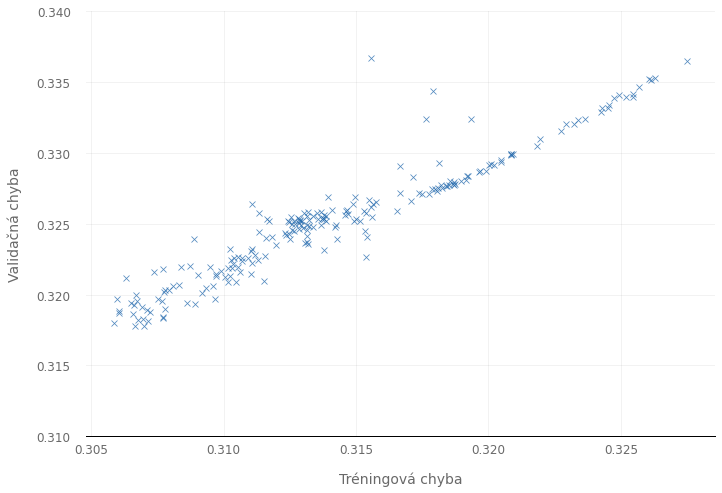

In [46]:
analyze_object.plot_regs('loss', 'val_loss')
plt.ylim((0.31,0.34))
plt.xlabel('Tréningová chyba')
plt.ylabel('Validačná chyba')

Text(14.875, 0.5, 'Validačná chyba')

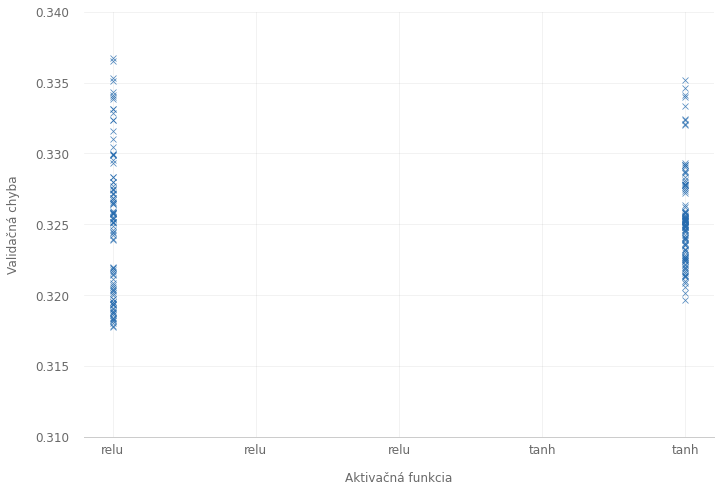

In [122]:
analyze_object.plot_regs('activation', 'val_loss')
plt.ylim((0.31,0.34))
plt.xlabel('Aktivačná funkcia')
plt.ylabel('Validačná chyba')

Text(0, 0.5, 'Validačná chyba')

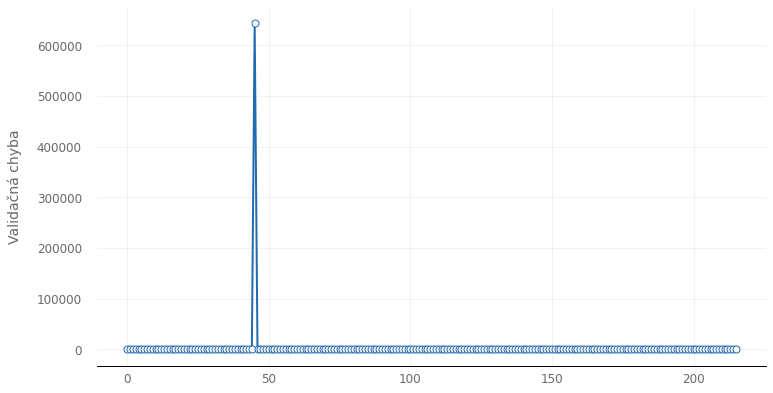

In [48]:
analyze_object.plot_line('val_loss')
plt.ylabel('Validačná chyba')

Text(0.5, 24.4, 'Tréningová chyba')

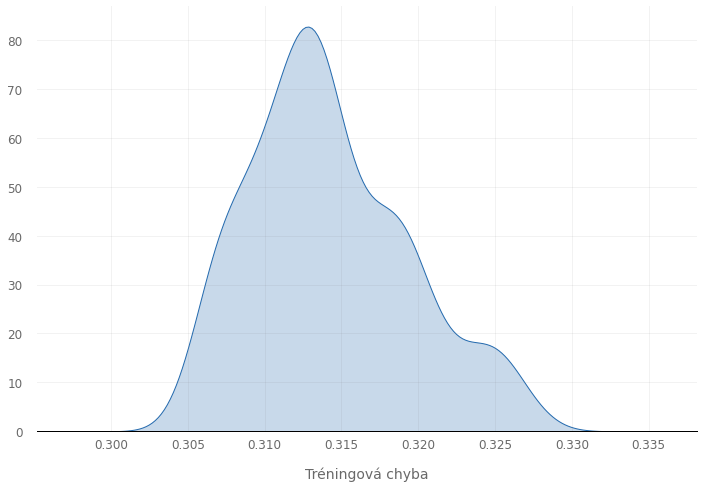

In [57]:
analyze_object.plot_kde('loss')
plt.xlabel('Tréningová chyba')


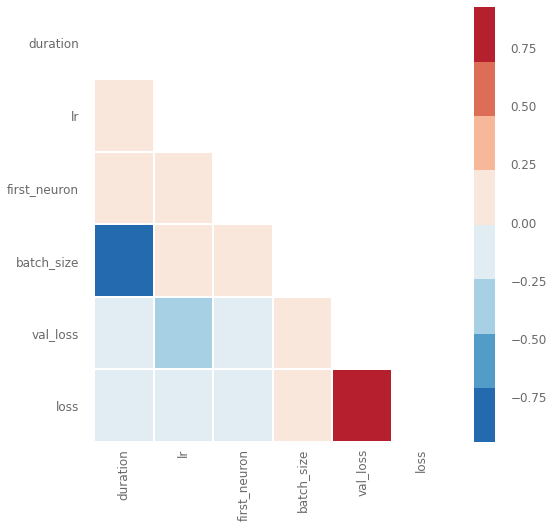

In [62]:
analyze_object.plot_corr('val_loss', ['round_epochs'])


Text(0.5, 0, 'N')

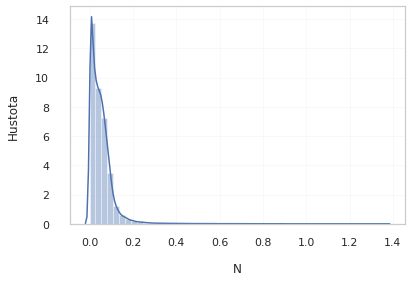

In [96]:
#best model
best_shallow = scan_shallow.best_model(metric = 'val_loss', asc=True)
predictions = best_shallow.predict([x_test, lv_test]).flatten()
ax = sns.distplot(predictions)
#sns.histplot(predictions,  stat = 'probability')
sns.set_theme(style="whitegrid")
ax.set_ylabel("Hustota")
ax.set_xlabel("N")

In [85]:
# mean freq
print(predictions.sum()/ v_test.sum())
# mean 
print(predictions.mean())

0.09778482008346892
0.05179085


In [97]:
prediction(best_shallow)

Deviancia na trenovacej mnozine je:  0.3058743428619286
Deviancia na testovacej mnozine je:  0.31775812978656354


In [67]:
talos.Deploy(scan_shallow, model_name = 'shalllow_scan', metric = 'val_loss', asc=True)

Deploy package shalllow_scan have been saved.


# Deep

In [ ]:
# hyperparametre
batch = 1024
epoch = 300
q1 = 32
q2 = 16
q3 = 8

In [ ]:
Design = tf.keras.Input(shape=(37,), name = 'Design')
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
layer1  = layers.Dense(q1, activation = 'tanh', name = 'Layer1')(Design)
layer2  = layers.Dense(q2, activation= 'tanh',  name = 'Layer2')(layer1)
layer3  = layers.Dense(q3, activation= 'tanh',  name = 'Layer3')(layer2)
Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                        kernel_initializer = tf.keras.initializers.Constant(0.),
 bias_initializer = tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer3)
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential'
, name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
 bias_initializer = tf.keras.initializers.Constant(0.))(addition)
deep = keras.Model(
    inputs = [Design,LogVol],
    outputs = response
)

deep.compile(loss = poisson_deviance, optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None))

deep.build(input_shape=(37,))
deep.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 37)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 32)           1216        Design[0][0]                     
__________________________________________________________________________________________________
Layer2 (Dense)                  (None, 16)           528         Layer1[0][0]                     
__________________________________________________________________________________________________
Layer3 (Dense)                  (None, 8)            136         Layer2[0][0]                     
____________________________________________________________________________________________

In [ ]:
# initial first bad guess
'''
model = keras.Sequential([
                          layers.InputLayer(input_shape=(41,)),
                          layers.Dense(20, activation = 'tanh'),
                          layers.Dense(15, activation= 'tanh'),
                          layers.Dense(10, activation= 'tanh'),
                          layers.Dense(1, activation= 'linear'),
                          layers.Dense(units = 1, activation= 'exponential', trainable=False)

])
model.compile(loss = 'poisson', optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07))

'''

"\nmodel = keras.Sequential([\n                          layers.InputLayer(input_shape=(41,)),\n                          layers.Dense(20, activation = 'tanh'),\n                          layers.Dense(15, activation= 'tanh'),\n                          layers.Dense(10, activation= 'tanh'),\n                          layers.Dense(1, activation= 'linear'),\n                          layers.Dense(units = 1, activation= 'exponential', trainable=False)\n\n])\nmodel.compile(loss = 'poisson', optimizer = tf.keras.optimizers.Nadam(\n    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07))\n\n"

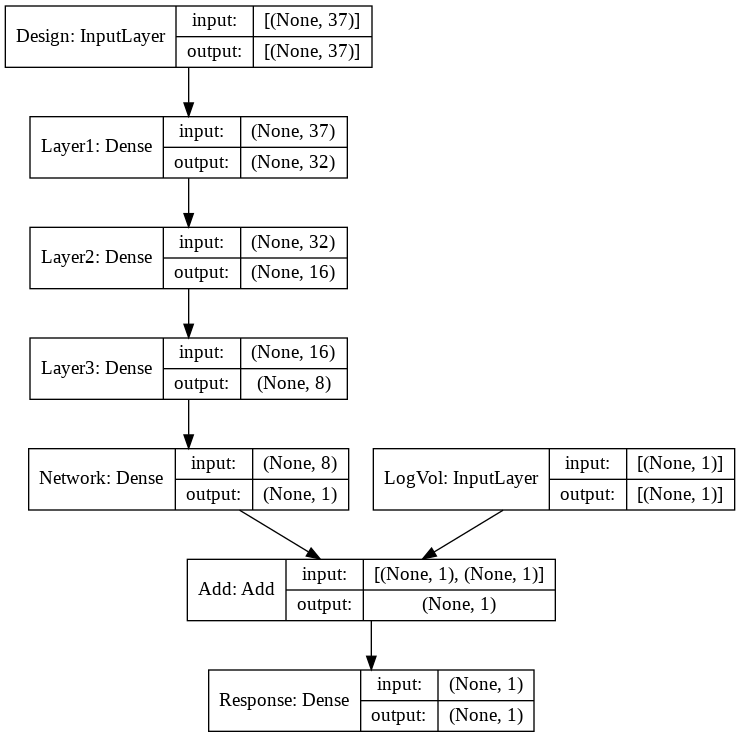

In [ ]:
keras.utils.plot_model(deep, "deep_3.png", show_shapes=True)

In [ ]:
%%time

history = deep.fit(
    #x = [x, lv],
    #y = y,
    x = [x_train, lv_train], y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose=2,
    epochs=epoch,
    batch_size = batch)

Epoch 1/300
596/596 - 2s - loss: 0.3215 - val_loss: 0.3280
Epoch 2/300
596/596 - 1s - loss: 0.3187 - val_loss: 0.3275
Epoch 3/300
596/596 - 1s - loss: 0.3183 - val_loss: 0.3271
Epoch 4/300
596/596 - 1s - loss: 0.3180 - val_loss: 0.3276
Epoch 5/300
596/596 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 6/300
596/596 - 1s - loss: 0.3173 - val_loss: 0.3274
Epoch 7/300
596/596 - 1s - loss: 0.3169 - val_loss: 0.3272
Epoch 8/300
596/596 - 1s - loss: 0.3166 - val_loss: 0.3262
Epoch 9/300
596/596 - 1s - loss: 0.3162 - val_loss: 0.3256
Epoch 10/300
596/596 - 1s - loss: 0.3159 - val_loss: 0.3259
Epoch 11/300
596/596 - 1s - loss: 0.3155 - val_loss: 0.3257
Epoch 12/300


KeyboardInterrupt: ignored

In [ ]:
deep.save('/content/drive/MyDrive/models/deep_3')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/deep_3/assets


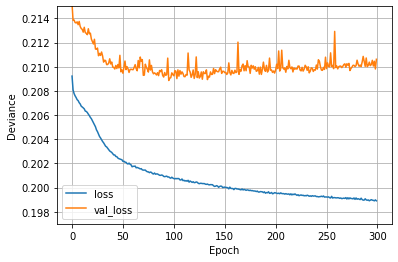

In [ ]:
plot_loss(history, yran=[0.197, 0.215])

In [ ]:
prediction(deep)

Deviancia na trenovacej mnozine je:  0.29995367200244255
Deviancia na testovacej mnozine je:  0.320761694585951


In [ ]:
tf.keras.backend.set_epsilon(1e-7)
